# Demonstration of SELFIES sets generation from the VAE latent space as a function of generative radius, along with generation from null generators for validity % comparison


### Import packages and libraries

In [1]:
import utils.Deep_AnoMolRep_utils as util
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import random
import rdkit
import selfies as sf
import string
import sys
import tempfile
import tensorflow as tf

from deepchem.feat.smiles_tokenizer import BasicSmilesTokenizer
from Deep_AnoMolRep_model import MolVariationalAutoencoder, kl_div, recon_cross_entropy_loss
from RandomSELFIESGenerator import RandomMolecularStringGenerator
from rdkit import Chem
from tensorflow import keras
from typing import List, Dict, Tuple, Union, NewType

#### Define the tokenizer

In [2]:
tokenizer = BasicSmilesTokenizer()

#### Read list of selfies strings

In [3]:
selfies_list = list(pd.read_csv('./data/selfies_zip_430k.txt')['SELFIES'])

#### Loading token vocabulary

In [4]:
code_to_char = np.load('./token_mappers/code_to_char.npy')
char_to_code = dict(np.load('./token_mappers/char_to_code.npy', allow_pickle=True))
char_to_code = {key: int(value) for key, value in char_to_code.items()}

#### Defining VAE parameters

In [5]:
latent_dim = 196
input_length = 91
vocab_size = len(code_to_char)
rnn_units = 256

model = MolVariationalAutoencoder(input_length = input_length,
                                  vocab_size = vocab_size,
                                  latent_dim = latent_dim,
                                  rnn_units = rnn_units)

#### Loading model weights

In [6]:
model.load_weights('./model_weights/final_vae_epoch_15')

#### Defining SELFIES constraints

In [7]:
constraints = {'Na+1':2, 'K+1':2, "Cl-1":0, "Br-1":0,"I-1":0, "Cl+3":4,
               'H': 1, 'F': 1, 'Cl': 1, 'Br': 1, 'I': 1, 'B': 3, 'B+1': 2,
               'B-1': 4, 'O': 2, 'O+1': 3, 'O-1': 1, 'N': 3, 'N+1': 4,
               'N-1': 2, 'C': 4, 'C+1': 5, 'C-1': 3, 'P': 5, 'P+1': 6,
               'P-1': 4, 'S': 6, 'S+1': 7, 'S-1': 5, '?': 8}


sf.set_semantic_constraints(constraints)

#### Decode all radii to SELFIES sets and calculate validity % per generative radius

In [8]:
def validity_at_radius(radius, 
                       num_to_gen,
                       model,
                       code_to_char,
                       latent_origin):
    
    batch_to_decode = np.array([util.random_sample_at_radius(latent_origin, radius) for _ in range(num_to_gen)])
    decoded_logits = model.decode(batch_to_decode)
    decoded_selfies = []
    converted_smiles = []
    valid_selfies_list = []
    invalid_selfies_list = []
    valid_count = 0

    for logit in decoded_logits:       
        generated_selfies = util.get_smiles_from_logits(tf.convert_to_tensor([logit.numpy()]),code_to_char)
        generated_smiles = sf.decoder(generated_selfies)
        decoded_selfies.append(generated_selfies)
        converted_smiles.append(generated_smiles)

        if Chem.MolFromSmiles(generated_smiles) is not None:
            valid_count +=1
            valid_selfies_list.append(generated_selfies)
        else:
            invalid_selfies_list.append(generated_selfies)

    validity_percentage = (valid_count/num_to_gen)*100
    
    return validity_percentage, valid_selfies_list, invalid_selfies_list

#### Radius list to decode from SELFIES

In [10]:
radius_list = [15.0,26.0,35.0,48.0,55.0,61.0,70.0,83.0,101.0,120.0,159.0,280.0,513.0,742.0]
num_to_gen = 10_000
latent_origin = np.zeros(latent_dim)
valid_selfies_example_per_radius = {radius: [] for radius in radius_list}
invalid_selfies_example_per_radius = {radius: [] for radius in radius_list}

#### Generate SELFIES sets at various radii and calculate validity percentage in generated sets

In [11]:
radius_validity_list = []

for radius in radius_list:
    validity_percentage, valid_selfies_list, invalid_selfies_list = validity_at_radius(radius, 
                                                                                       num_to_gen, 
                                                                                       model, 
                                                                                       code_to_char, 
                                                                                       latent_origin)
    radius_validity_list.append(validity_percentage)
    valid_selfies_example_per_radius[radius].extend(valid_selfies_list)
    invalid_selfies_example_per_radius[radius].extend(invalid_selfies_list)

[21:54:46] Explicit valence for atom # 16 K, 3, is greater than permitted
[21:54:49] Explicit valence for atom # 22 K, 3, is greater than permitted
[21:54:50] Explicit valence for atom # 18 Na, 2, is greater than permitted
[21:54:51] Explicit valence for atom # 18 K, 3, is greater than permitted
[21:54:56] Explicit valence for atom # 21 K, 2, is greater than permitted
[21:54:56] Explicit valence for atom # 19 Na, 3, is greater than permitted
[21:56:08] Explicit valence for atom # 9 Na, 3, is greater than permitted
[21:56:08] Explicit valence for atom # 11 K, 3, is greater than permitted
[21:56:08] Explicit valence for atom # 6 K, 2, is greater than permitted
[21:56:08] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:56:08] Explicit valence for atom # 15 K, 2, is greater than permitted
[21:56:08] Explicit valence for atom # 8 K, 3, is greater than permitted
[21:56:08] Explicit valence for atom # 15 K, 3, is greater than permitted
[21:56:08] Explicit valence for atom #

[21:56:09] Explicit valence for atom # 13 K, 2, is greater than permitted
[21:56:09] Explicit valence for atom # 11 K, 3, is greater than permitted
[21:56:09] Explicit valence for atom # 6 Na, 2, is greater than permitted
[21:56:09] Explicit valence for atom # 10 Na, 2, is greater than permitted
[21:56:09] Explicit valence for atom # 16 K, 3, is greater than permitted
[21:56:09] Explicit valence for atom # 8 K, 3, is greater than permitted
[21:56:09] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:56:09] Explicit valence for atom # 11 K, 3, is greater than permitted
[21:56:09] Explicit valence for atom # 8 Na, 2, is greater than permitted
[21:56:09] Explicit valence for atom # 15 Na, 2, is greater than permitted
[21:56:09] Explicit valence for atom # 22 K, 2, is greater than permitted
[21:56:09] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:56:09] Explicit valence for atom # 4 K, 3, is greater than permitted
[21:56:09] Explicit valence for atom #

[21:56:11] Explicit valence for atom # 5 K, 2, is greater than permitted
[21:56:11] Explicit valence for atom # 7 K, 2, is greater than permitted
[21:56:11] Explicit valence for atom # 11 K, 2, is greater than permitted
[21:56:11] Explicit valence for atom # 7 K, 3, is greater than permitted
[21:56:11] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:56:11] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:56:11] Explicit valence for atom # 6 K, 2, is greater than permitted
[21:56:11] Explicit valence for atom # 8 Na, 2, is greater than permitted
[21:56:11] Explicit valence for atom # 21 K, 2, is greater than permitted
[21:56:11] Explicit valence for atom # 16 K, 3, is greater than permitted
[21:56:11] Explicit valence for atom # 23 K, 2, is greater than permitted
[21:56:11] Explicit valence for atom # 10 K, 3, is greater than permitted
[21:56:11] Explicit valence for atom # 5 K, 2, is greater than permitted
[21:56:11] Explicit valence for atom # 15 K

[21:56:12] Explicit valence for atom # 3 Na, 3, is greater than permitted
[21:56:12] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:56:12] Explicit valence for atom # 6 K, 3, is greater than permitted
[21:56:12] Explicit valence for atom # 17 K, 3, is greater than permitted
[21:56:12] Explicit valence for atom # 21 Na, 3, is greater than permitted
[21:56:12] Explicit valence for atom # 11 K, 3, is greater than permitted
[21:56:12] Explicit valence for atom # 19 K, 2, is greater than permitted
[21:56:12] Explicit valence for atom # 9 Na, 3, is greater than permitted
[21:56:12] Explicit valence for atom # 23 Na, 2, is greater than permitted
[21:56:12] Explicit valence for atom # 9 K, 2, is greater than permitted
[21:56:12] Explicit valence for atom # 5 K, 2, is greater than permitted
[21:56:13] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:56:13] Explicit valence for atom # 9 Na, 3, is greater than permitted
[21:56:13] Explicit valence for atom # 

[21:56:14] Explicit valence for atom # 22 K, 3, is greater than permitted
[21:56:14] Explicit valence for atom # 18 K, 3, is greater than permitted
[21:56:14] Explicit valence for atom # 18 Na, 2, is greater than permitted
[21:56:14] Explicit valence for atom # 12 K, 3, is greater than permitted
[21:56:14] Explicit valence for atom # 21 K, 2, is greater than permitted
[21:56:14] Explicit valence for atom # 11 K, 2, is greater than permitted
[21:56:14] Explicit valence for atom # 17 Na, 2, is greater than permitted
[21:56:14] Explicit valence for atom # 16 Na, 3, is greater than permitted
[21:56:14] Explicit valence for atom # 19 Na, 2, is greater than permitted
[21:56:14] Explicit valence for atom # 4 K, 3, is greater than permitted
[21:56:14] Explicit valence for atom # 24 K, 2, is greater than permitted
[21:56:14] Explicit valence for atom # 11 K, 2, is greater than permitted
[21:56:14] Explicit valence for atom # 15 Na, 3, is greater than permitted
[21:56:14] Explicit valence for at

[21:56:15] Explicit valence for atom # 25 Na, 3, is greater than permitted
[21:56:15] Explicit valence for atom # 11 K, 3, is greater than permitted
[21:56:15] Explicit valence for atom # 24 K, 3, is greater than permitted
[21:56:15] Explicit valence for atom # 7 K, 3, is greater than permitted
[21:56:15] Explicit valence for atom # 15 K, 2, is greater than permitted
[21:56:15] Explicit valence for atom # 14 K, 3, is greater than permitted
[21:56:15] Explicit valence for atom # 17 Na, 2, is greater than permitted
[21:56:15] Explicit valence for atom # 9 K, 3, is greater than permitted
[21:56:15] Explicit valence for atom # 18 K, 3, is greater than permitted
[21:56:15] Explicit valence for atom # 12 K, 3, is greater than permitted
[21:56:15] Explicit valence for atom # 8 Na, 2, is greater than permitted
[21:56:15] Explicit valence for atom # 15 Na, 3, is greater than permitted
[21:56:15] Explicit valence for atom # 23 Na, 2, is greater than permitted
[21:56:15] Explicit valence for atom

[21:56:17] Explicit valence for atom # 7 K, 2, is greater than permitted
[21:56:17] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:56:17] Explicit valence for atom # 6 K, 2, is greater than permitted
[21:56:17] Explicit valence for atom # 18 K, 2, is greater than permitted
[21:56:17] Explicit valence for atom # 11 K, 3, is greater than permitted
[21:56:17] Explicit valence for atom # 15 K, 3, is greater than permitted
[21:56:17] Explicit valence for atom # 10 K, 3, is greater than permitted
[21:56:17] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:56:17] Explicit valence for atom # 18 K, 2, is greater than permitted
[21:56:17] Explicit valence for atom # 15 Na, 3, is greater than permitted
[21:56:17] Explicit valence for atom # 21 Na, 2, is greater than permitted
[21:56:17] Explicit valence for atom # 12 Na, 2, is greater than permitted
[21:56:17] Explicit valence for atom # 6 K, 3, is greater than permitted
[21:56:17] Explicit valence for atom # 

[21:56:18] Explicit valence for atom # 4 K, 2, is greater than permitted
[21:56:18] Explicit valence for atom # 19 K, 3, is greater than permitted
[21:56:18] Explicit valence for atom # 10 K, 3, is greater than permitted
[21:56:18] Explicit valence for atom # 15 K, 2, is greater than permitted
[21:56:18] Explicit valence for atom # 15 K, 3, is greater than permitted
[21:56:18] Explicit valence for atom # 10 Na, 2, is greater than permitted
[21:56:18] Explicit valence for atom # 22 K, 2, is greater than permitted
[21:56:18] Explicit valence for atom # 18 K, 3, is greater than permitted
[21:56:18] Explicit valence for atom # 13 Na, 3, is greater than permitted
[21:56:18] Explicit valence for atom # 14 Na, 2, is greater than permitted
[21:56:18] Explicit valence for atom # 10 K, 3, is greater than permitted
[21:56:18] Explicit valence for atom # 7 K, 3, is greater than permitted
[21:56:18] Explicit valence for atom # 19 Na, 2, is greater than permitted
[21:56:18] Explicit valence for atom

[21:56:19] Explicit valence for atom # 14 K, 2, is greater than permitted
[21:56:19] Explicit valence for atom # 18 K, 3, is greater than permitted
[21:56:19] Explicit valence for atom # 9 Na, 2, is greater than permitted
[21:56:19] Explicit valence for atom # 20 K, 3, is greater than permitted
[21:56:19] Explicit valence for atom # 16 K, 2, is greater than permitted
[21:56:19] Explicit valence for atom # 22 K, 3, is greater than permitted
[21:56:19] Explicit valence for atom # 22 Na, 2, is greater than permitted
[21:56:19] Explicit valence for atom # 19 K, 3, is greater than permitted
[21:56:19] Explicit valence for atom # 15 Na, 2, is greater than permitted
[21:56:19] Explicit valence for atom # 11 Na, 2, is greater than permitted
[21:56:19] Explicit valence for atom # 14 Na, 2, is greater than permitted
[21:56:19] Explicit valence for atom # 7 Na, 3, is greater than permitted
[21:56:19] Explicit valence for atom # 16 K, 3, is greater than permitted
[21:56:19] Explicit valence for at

[21:56:21] Explicit valence for atom # 9 K, 2, is greater than permitted
[21:56:21] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:56:21] Explicit valence for atom # 10 K, 3, is greater than permitted
[21:56:21] Explicit valence for atom # 10 K, 3, is greater than permitted
[21:56:21] Explicit valence for atom # 8 Na, 3, is greater than permitted
[21:56:21] Explicit valence for atom # 21 K, 2, is greater than permitted
[21:56:21] Explicit valence for atom # 5 Na, 2, is greater than permitted
[21:56:21] Explicit valence for atom # 13 K, 2, is greater than permitted
[21:56:21] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:56:21] Explicit valence for atom # 12 K, 3, is greater than permitted
[21:56:21] Explicit valence for atom # 16 K, 2, is greater than permitted
[21:56:21] Explicit valence for atom # 5 K, 2, is greater than permitted
[21:56:21] Explicit valence for atom # 29 Na, 3, is greater than permitted
[21:56:21] Explicit valence for atom # 9

[21:56:23] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:56:23] Explicit valence for atom # 7 Na, 3, is greater than permitted
[21:56:23] Explicit valence for atom # 9 K, 2, is greater than permitted
[21:56:23] Explicit valence for atom # 15 K, 2, is greater than permitted
[21:56:23] Explicit valence for atom # 10 Na, 2, is greater than permitted
[21:56:23] Explicit valence for atom # 6 Na, 2, is greater than permitted
[21:56:23] Explicit valence for atom # 24 Na, 3, is greater than permitted
[21:56:23] Explicit valence for atom # 18 K, 3, is greater than permitted
[21:56:23] Explicit valence for atom # 11 K, 2, is greater than permitted
[21:56:23] Explicit valence for atom # 9 K, 2, is greater than permitted
[21:56:23] Explicit valence for atom # 23 K, 2, is greater than permitted
[21:56:23] Explicit valence for atom # 17 K, 3, is greater than permitted
[21:56:23] Explicit valence for atom # 8 K, 3, is greater than permitted
[21:56:23] Explicit valence for atom # 

[21:56:24] Explicit valence for atom # 17 K, 2, is greater than permitted
[21:56:24] Explicit valence for atom # 14 Na, 3, is greater than permitted
[21:56:24] Explicit valence for atom # 15 K, 3, is greater than permitted
[21:56:24] Explicit valence for atom # 6 Na, 3, is greater than permitted
[21:56:24] Explicit valence for atom # 7 Na, 2, is greater than permitted
[21:56:24] Explicit valence for atom # 12 Na, 2, is greater than permitted
[21:56:24] Explicit valence for atom # 15 Na, 2, is greater than permitted
[21:56:24] Explicit valence for atom # 20 K, 3, is greater than permitted
[21:56:24] Explicit valence for atom # 17 K, 2, is greater than permitted
[21:56:24] Explicit valence for atom # 5 K, 2, is greater than permitted
[21:56:24] Explicit valence for atom # 14 Na, 3, is greater than permitted
[21:56:24] Explicit valence for atom # 14 K, 3, is greater than permitted
[21:56:24] Explicit valence for atom # 17 K, 2, is greater than permitted
[21:56:24] Explicit valence for ato

[21:56:26] Explicit valence for atom # 16 K, 3, is greater than permitted
[21:56:26] Explicit valence for atom # 16 Na, 2, is greater than permitted
[21:56:26] Explicit valence for atom # 18 Na, 3, is greater than permitted
[21:56:26] Explicit valence for atom # 14 K, 3, is greater than permitted
[21:56:26] Explicit valence for atom # 7 K, 3, is greater than permitted
[21:56:26] Explicit valence for atom # 22 Na, 2, is greater than permitted
[21:56:26] Explicit valence for atom # 6 K, 3, is greater than permitted
[21:56:26] Explicit valence for atom # 16 Na, 2, is greater than permitted
[21:56:26] Explicit valence for atom # 12 Na, 2, is greater than permitted
[21:56:26] Explicit valence for atom # 16 Na, 2, is greater than permitted
[21:56:26] Explicit valence for atom # 18 Na, 3, is greater than permitted
[21:56:26] Explicit valence for atom # 5 K, 2, is greater than permitted
[21:56:26] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:56:26] Explicit valence for at

[21:56:27] Explicit valence for atom # 17 K, 2, is greater than permitted
[21:56:27] Explicit valence for atom # 4 K, 2, is greater than permitted
[21:56:27] Explicit valence for atom # 17 K, 2, is greater than permitted
[21:56:27] Explicit valence for atom # 4 K, 2, is greater than permitted
[21:56:27] Explicit valence for atom # 16 K, 3, is greater than permitted
[21:56:27] Explicit valence for atom # 8 K, 3, is greater than permitted
[21:56:27] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:56:27] Explicit valence for atom # 14 K, 2, is greater than permitted
[21:56:27] Explicit valence for atom # 11 K, 2, is greater than permitted
[21:56:27] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:56:27] Explicit valence for atom # 24 K, 2, is greater than permitted
[21:56:27] Explicit valence for atom # 18 K, 3, is greater than permitted
[21:56:27] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:56:27] Explicit valence for atom # 12

[21:57:41] Explicit valence for atom # 8 Na, 3, is greater than permitted
[21:57:41] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:57:41] Explicit valence for atom # 11 Na, 2, is greater than permitted
[21:57:41] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:57:41] Explicit valence for atom # 9 K, 2, is greater than permitted
[21:57:41] Explicit valence for atom # 12 Na, 3, is greater than permitted
[21:57:41] Explicit valence for atom # 12 Na, 2, is greater than permitted
[21:57:41] Explicit valence for atom # 15 K, 3, is greater than permitted
[21:57:41] Explicit valence for atom # 17 K, 2, is greater than permitted
[21:57:41] Explicit valence for atom # 13 K, 2, is greater than permitted
[21:57:41] Explicit valence for atom # 19 K, 3, is greater than permitted
[21:57:41] Explicit valence for atom # 16 Na, 2, is greater than permitted
[21:57:41] Explicit valence for atom # 6 K, 2, is greater than permitted
[21:57:41] Explicit valence for atom

[21:57:41] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:57:41] Explicit valence for atom # 15 K, 2, is greater than permitted
[21:57:41] Explicit valence for atom # 16 K, 2, is greater than permitted
[21:57:41] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:57:41] Explicit valence for atom # 19 Na, 2, is greater than permitted
[21:57:41] Explicit valence for atom # 4 Na, 3, is greater than permitted
[21:57:41] Explicit valence for atom # 6 K, 2, is greater than permitted
[21:57:41] Explicit valence for atom # 7 Na, 3, is greater than permitted
[21:57:41] Explicit valence for atom # 6 K, 2, is greater than permitted
[21:57:41] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:57:41] Explicit valence for atom # 2 K, 3, is greater than permitted
[21:57:41] Explicit valence for atom # 15 Na, 2, is greater than permitted
[21:57:41] Explicit valence for atom # 5 Na, 2, is greater than permitted
[21:57:41] Explicit valence for atom # 

[21:57:41] Explicit valence for atom # 7 K, 3, is greater than permitted
[21:57:41] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:57:41] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:57:41] Explicit valence for atom # 11 K, 2, is greater than permitted
[21:57:41] Explicit valence for atom # 11 Na, 3, is greater than permitted
[21:57:41] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:57:41] Explicit valence for atom # 9 K, 3, is greater than permitted
[21:57:41] Explicit valence for atom # 13 Na, 3, is greater than permitted
[21:57:41] Explicit valence for atom # 11 K, 3, is greater than permitted
[21:57:41] Explicit valence for atom # 7 K, 2, is greater than permitted
[21:57:41] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:57:41] Explicit valence for atom # 8 K, 3, is greater than permitted
[21:57:41] Explicit valence for atom # 11 K, 3, is greater than permitted
[21:57:41] Explicit valence for atom # 

[21:57:42] Explicit valence for atom # 20 K, 2, is greater than permitted
[21:57:42] Explicit valence for atom # 21 K, 3, is greater than permitted
[21:57:42] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:57:42] Explicit valence for atom # 7 Na, 3, is greater than permitted
[21:57:42] Explicit valence for atom # 12 K, 3, is greater than permitted
[21:57:42] Explicit valence for atom # 15 K, 2, is greater than permitted
[21:57:42] Explicit valence for atom # 16 Na, 2, is greater than permitted
[21:57:42] Explicit valence for atom # 16 K, 2, is greater than permitted
[21:57:42] Explicit valence for atom # 17 K, 2, is greater than permitted
[21:57:42] Explicit valence for atom # 5 Na, 3, is greater than permitted
[21:57:42] Explicit valence for atom # 16 K, 3, is greater than permitted
[21:57:42] Explicit valence for atom # 10 Na, 2, is greater than permitted
[21:57:42] Explicit valence for atom # 16 Na, 2, is greater than permitted
[21:57:42] Explicit valence for at

[21:57:42] Explicit valence for atom # 3 K, 2, is greater than permitted
[21:57:42] Explicit valence for atom # 15 K, 2, is greater than permitted
[21:57:42] Explicit valence for atom # 16 Na, 2, is greater than permitted
[21:57:42] Explicit valence for atom # 7 K, 2, is greater than permitted
[21:57:42] Explicit valence for atom # 15 Na, 3, is greater than permitted
[21:57:42] Explicit valence for atom # 8 K, 3, is greater than permitted
[21:57:42] Explicit valence for atom # 19 Na, 2, is greater than permitted
[21:57:42] Explicit valence for atom # 16 K, 2, is greater than permitted
[21:57:42] Explicit valence for atom # 16 K, 2, is greater than permitted
[21:57:42] Explicit valence for atom # 3 K, 3, is greater than permitted
[21:57:42] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:57:42] Explicit valence for atom # 19 K, 2, is greater than permitted
[21:57:42] Explicit valence for atom # 7 Na, 2, is greater than permitted
[21:57:42] Explicit valence for atom # 

[21:57:43] Explicit valence for atom # 13 K, 3, is greater than permitted
[21:57:43] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:57:43] Explicit valence for atom # 9 K, 2, is greater than permitted
[21:57:43] Explicit valence for atom # 14 Na, 3, is greater than permitted
[21:57:43] Explicit valence for atom # 17 Na, 2, is greater than permitted
[21:57:43] Explicit valence for atom # 18 K, 2, is greater than permitted
[21:57:43] Explicit valence for atom # 7 Na, 3, is greater than permitted
[21:57:43] Explicit valence for atom # 6 Na, 2, is greater than permitted
[21:57:43] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:57:43] Explicit valence for atom # 9 Na, 3, is greater than permitted
[21:57:43] Explicit valence for atom # 8 Na, 3, is greater than permitted
[21:57:43] Explicit valence for atom # 21 K, 3, is greater than permitted
[21:57:43] Explicit valence for atom # 12 Na, 3, is greater than permitted
[21:57:43] Explicit valence for atom

[21:57:43] Explicit valence for atom # 9 K, 3, is greater than permitted
[21:57:43] Explicit valence for atom # 17 K, 2, is greater than permitted
[21:57:43] Explicit valence for atom # 6 Na, 2, is greater than permitted
[21:57:43] Explicit valence for atom # 2 Na, 3, is greater than permitted
[21:57:43] Explicit valence for atom # 14 Na, 3, is greater than permitted
[21:57:43] Explicit valence for atom # 14 K, 2, is greater than permitted
[21:57:43] Explicit valence for atom # 12 K, 3, is greater than permitted
[21:57:43] Explicit valence for atom # 12 Na, 3, is greater than permitted
[21:57:43] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:57:43] Explicit valence for atom # 16 Na, 2, is greater than permitted
[21:57:43] Explicit valence for atom # 12 Na, 3, is greater than permitted
[21:57:43] Explicit valence for atom # 4 K, 2, is greater than permitted
[21:57:43] Explicit valence for atom # 11 K, 2, is greater than permitted
[21:57:43] Explicit valence for atom 

[21:57:44] Explicit valence for atom # 9 K, 3, is greater than permitted
[21:57:44] Explicit valence for atom # 14 Na, 3, is greater than permitted
[21:57:44] Explicit valence for atom # 7 K, 2, is greater than permitted
[21:57:44] Explicit valence for atom # 6 Na, 2, is greater than permitted
[21:57:44] Explicit valence for atom # 9 Na, 2, is greater than permitted
[21:57:44] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:57:44] Explicit valence for atom # 5 K, 2, is greater than permitted
[21:57:44] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:57:44] Explicit valence for atom # 28 K, 3, is greater than permitted
[21:57:44] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:57:44] Explicit valence for atom # 17 Na, 3, is greater than permitted
[21:57:44] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:57:44] Explicit valence for atom # 21 K, 3, is greater than permitted
[21:57:44] Explicit valence for atom # 18

[21:57:44] Explicit valence for atom # 18 Na, 2, is greater than permitted
[21:57:44] Explicit valence for atom # 27 K, 3, is greater than permitted
[21:57:44] Explicit valence for atom # 11 Na, 2, is greater than permitted
[21:57:44] Explicit valence for atom # 8 K, 3, is greater than permitted
[21:57:44] Explicit valence for atom # 8 Na, 2, is greater than permitted
[21:57:44] Explicit valence for atom # 10 K, 3, is greater than permitted
[21:57:44] Explicit valence for atom # 15 K, 2, is greater than permitted
[21:57:44] Explicit valence for atom # 6 K, 2, is greater than permitted
[21:57:44] Explicit valence for atom # 2 K, 3, is greater than permitted
[21:57:44] Explicit valence for atom # 19 Na, 2, is greater than permitted
[21:57:44] Explicit valence for atom # 15 K, 2, is greater than permitted
[21:57:44] Explicit valence for atom # 17 Na, 2, is greater than permitted
[21:57:44] Explicit valence for atom # 5 Na, 2, is greater than permitted
[21:57:44] Explicit valence for atom 

[21:57:44] Explicit valence for atom # 31 K, 2, is greater than permitted
[21:57:44] Explicit valence for atom # 7 Na, 2, is greater than permitted
[21:57:44] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:57:44] Explicit valence for atom # 14 K, 2, is greater than permitted
[21:57:44] Explicit valence for atom # 16 K, 3, is greater than permitted
[21:57:44] Explicit valence for atom # 7 K, 2, is greater than permitted
[21:57:44] Explicit valence for atom # 12 Na, 2, is greater than permitted
[21:57:44] Explicit valence for atom # 5 Na, 2, is greater than permitted
[21:57:44] Explicit valence for atom # 15 Na, 2, is greater than permitted
[21:57:44] Explicit valence for atom # 9 K, 2, is greater than permitted
[21:57:44] Explicit valence for atom # 9 K, 3, is greater than permitted
[21:57:44] Explicit valence for atom # 8 K, 3, is greater than permitted
[21:57:44] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:57:44] Explicit valence for atom # 18

[21:57:45] Explicit valence for atom # 19 Na, 3, is greater than permitted
[21:57:45] Explicit valence for atom # 12 Na, 3, is greater than permitted
[21:57:45] Explicit valence for atom # 7 K, 2, is greater than permitted
[21:57:45] Explicit valence for atom # 9 Na, 2, is greater than permitted
[21:57:45] Explicit valence for atom # 17 Na, 3, is greater than permitted
[21:57:45] Explicit valence for atom # 15 K, 2, is greater than permitted
[21:57:45] Explicit valence for atom # 5 K, 2, is greater than permitted
[21:57:45] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:57:45] Explicit valence for atom # 16 K, 2, is greater than permitted
[21:57:45] Explicit valence for atom # 14 Na, 3, is greater than permitted
[21:57:45] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:57:45] Explicit valence for atom # 15 K, 3, is greater than permitted
[21:57:45] Explicit valence for atom # 15 K, 3, is greater than permitted
[21:57:45] Explicit valence for atom

[21:57:45] Explicit valence for atom # 13 Na, 2, is greater than permitted
[21:57:45] Explicit valence for atom # 22 Na, 2, is greater than permitted
[21:57:45] Explicit valence for atom # 4 K, 3, is greater than permitted
[21:57:45] Explicit valence for atom # 14 K, 3, is greater than permitted
[21:57:45] Explicit valence for atom # 18 Na, 2, is greater than permitted
[21:57:45] Explicit valence for atom # 9 Na, 2, is greater than permitted
[21:57:45] Explicit valence for atom # 14 Na, 2, is greater than permitted
[21:57:45] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:57:45] Explicit valence for atom # 19 K, 2, is greater than permitted
[21:57:45] Explicit valence for atom # 8 Na, 3, is greater than permitted
[21:57:45] Explicit valence for atom # 14 Na, 2, is greater than permitted
[21:57:45] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:57:45] Explicit valence for atom # 9 Na, 3, is greater than permitted
[21:57:45] Explicit valence for ato

[21:57:46] Explicit valence for atom # 4 K, 2, is greater than permitted
[21:57:46] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:57:46] Explicit valence for atom # 22 K, 3, is greater than permitted
[21:57:46] Explicit valence for atom # 16 K, 3, is greater than permitted
[21:57:46] Explicit valence for atom # 6 K, 2, is greater than permitted
[21:57:46] Explicit valence for atom # 4 Na, 3, is greater than permitted
[21:57:46] Explicit valence for atom # 20 Na, 2, is greater than permitted
[21:57:46] Explicit valence for atom # 11 K, 3, is greater than permitted
[21:57:46] Explicit valence for atom # 5 K, 2, is greater than permitted
[21:57:46] Explicit valence for atom # 14 K, 2, is greater than permitted
[21:57:46] Explicit valence for atom # 4 K, 3, is greater than permitted
[21:57:46] Explicit valence for atom # 4 K, 3, is greater than permitted
[21:57:46] Explicit valence for atom # 12 K, 3, is greater than permitted
[21:57:46] Explicit valence for atom # 6 

[21:57:46] Explicit valence for atom # 25 K, 2, is greater than permitted
[21:57:46] Explicit valence for atom # 13 K, 3, is greater than permitted
[21:57:46] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:57:46] Explicit valence for atom # 17 K, 2, is greater than permitted
[21:57:46] Explicit valence for atom # 21 Na, 2, is greater than permitted
[21:57:46] Explicit valence for atom # 8 K, 3, is greater than permitted
[21:57:46] Explicit valence for atom # 12 Na, 3, is greater than permitted
[21:57:46] Explicit valence for atom # 7 K, 2, is greater than permitted
[21:57:46] Explicit valence for atom # 21 K, 3, is greater than permitted
[21:57:46] Explicit valence for atom # 10 Na, 2, is greater than permitted
[21:57:46] Explicit valence for atom # 27 K, 3, is greater than permitted
[21:57:46] Explicit valence for atom # 21 Na, 3, is greater than permitted
[21:57:46] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:57:46] Explicit valence for atom 

[21:57:47] Explicit valence for atom # 9 K, 2, is greater than permitted
[21:57:47] Explicit valence for atom # 21 K, 2, is greater than permitted
[21:57:47] Explicit valence for atom # 6 K, 2, is greater than permitted
[21:57:47] Explicit valence for atom # 17 Na, 3, is greater than permitted
[21:57:47] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:57:47] Explicit valence for atom # 17 K, 2, is greater than permitted
[21:57:47] Explicit valence for atom # 13 Na, 2, is greater than permitted
[21:57:47] Explicit valence for atom # 9 K, 2, is greater than permitted
[21:57:47] Explicit valence for atom # 20 Na, 3, is greater than permitted
[21:57:47] Explicit valence for atom # 15 K, 2, is greater than permitted
[21:57:47] Explicit valence for atom # 3 Na, 3, is greater than permitted
[21:57:47] Explicit valence for atom # 8 Na, 3, is greater than permitted
[21:57:47] Explicit valence for atom # 17 K, 3, is greater than permitted
[21:57:47] Explicit valence for atom # 

[21:57:47] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:57:47] Explicit valence for atom # 11 K, 2, is greater than permitted
[21:57:47] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:57:47] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:57:47] Explicit valence for atom # 13 K, 3, is greater than permitted
[21:57:47] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:57:47] Explicit valence for atom # 3 Na, 2, is greater than permitted
[21:57:47] Explicit valence for atom # 15 Na, 2, is greater than permitted
[21:57:47] Explicit valence for atom # 14 K, 3, is greater than permitted
[21:57:47] Explicit valence for atom # 8 K, 3, is greater than permitted
[21:57:47] Explicit valence for atom # 11 K, 3, is greater than permitted
[21:57:47] Explicit valence for atom # 16 K, 2, is greater than permitted
[21:57:47] Explicit valence for atom # 14 K, 3, is greater than permitted
[21:57:47] Explicit valence for atom #

[21:57:47] Explicit valence for atom # 6 K, 3, is greater than permitted
[21:57:47] Explicit valence for atom # 17 Na, 2, is greater than permitted
[21:57:47] Explicit valence for atom # 11 K, 2, is greater than permitted
[21:57:47] Explicit valence for atom # 11 K, 2, is greater than permitted
[21:57:47] Explicit valence for atom # 11 K, 2, is greater than permitted
[21:57:47] Explicit valence for atom # 19 K, 2, is greater than permitted
[21:57:47] Explicit valence for atom # 2 Na, 3, is greater than permitted
[21:57:47] Explicit valence for atom # 17 Na, 3, is greater than permitted
[21:57:47] Explicit valence for atom # 16 K, 3, is greater than permitted
[21:57:47] Explicit valence for atom # 14 Na, 2, is greater than permitted
[21:57:48] Explicit valence for atom # 11 K, 2, is greater than permitted
[21:57:48] Explicit valence for atom # 12 K, 3, is greater than permitted
[21:57:48] Explicit valence for atom # 9 Na, 2, is greater than permitted
[21:57:48] Explicit valence for atom

[21:57:48] Explicit valence for atom # 13 Na, 2, is greater than permitted
[21:57:48] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:57:48] Explicit valence for atom # 5 Na, 3, is greater than permitted
[21:57:48] Explicit valence for atom # 20 Na, 2, is greater than permitted
[21:57:48] Explicit valence for atom # 14 Na, 3, is greater than permitted
[21:57:48] Explicit valence for atom # 3 K, 2, is greater than permitted
[21:57:48] Explicit valence for atom # 13 K, 3, is greater than permitted
[21:57:48] Explicit valence for atom # 11 K, 2, is greater than permitted
[21:57:48] Explicit valence for atom # 11 Na, 3, is greater than permitted
[21:57:48] Explicit valence for atom # 12 K, 3, is greater than permitted
[21:57:48] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:57:48] Explicit valence for atom # 6 Na, 2, is greater than permitted
[21:57:48] Explicit valence for atom # 12 K, 3, is greater than permitted
[21:57:48] Explicit valence for atom

[21:57:48] Explicit valence for atom # 13 Na, 2, is greater than permitted
[21:57:48] Explicit valence for atom # 6 Na, 3, is greater than permitted
[21:57:48] Explicit valence for atom # 11 Na, 3, is greater than permitted
[21:57:48] Explicit valence for atom # 9 Na, 2, is greater than permitted
[21:57:48] Explicit valence for atom # 21 Na, 2, is greater than permitted
[21:57:48] Explicit valence for atom # 6 Na, 3, is greater than permitted
[21:57:48] Explicit valence for atom # 6 Na, 3, is greater than permitted
[21:57:48] Explicit valence for atom # 12 Na, 2, is greater than permitted
[21:57:48] Explicit valence for atom # 16 K, 3, is greater than permitted
[21:57:48] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:57:48] Explicit valence for atom # 11 Na, 2, is greater than permitted
[21:57:48] Explicit valence for atom # 14 K, 3, is greater than permitted
[21:57:48] Explicit valence for atom # 16 K, 3, is greater than permitted
[21:57:48] Explicit valence for a

[21:57:49] Explicit valence for atom # 13 Na, 3, is greater than permitted
[21:57:49] Explicit valence for atom # 2 K, 3, is greater than permitted
[21:57:49] Explicit valence for atom # 3 K, 3, is greater than permitted
[21:57:49] Explicit valence for atom # 17 K, 3, is greater than permitted
[21:57:49] Explicit valence for atom # 12 K, 3, is greater than permitted
[21:57:49] Explicit valence for atom # 24 Na, 3, is greater than permitted
[21:57:49] Explicit valence for atom # 12 Na, 3, is greater than permitted
[21:57:49] Explicit valence for atom # 6 Na, 3, is greater than permitted
[21:57:49] Explicit valence for atom # 18 Na, 2, is greater than permitted
[21:57:49] Explicit valence for atom # 9 K, 3, is greater than permitted
[21:57:49] Explicit valence for atom # 14 Na, 3, is greater than permitted
[21:57:49] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:57:49] Explicit valence for atom # 11 Na, 2, is greater than permitted
[21:57:49] Explicit valence for at

[21:57:49] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:57:49] Explicit valence for atom # 7 K, 3, is greater than permitted
[21:57:49] Explicit valence for atom # 13 Na, 2, is greater than permitted
[21:57:49] Explicit valence for atom # 9 K, 3, is greater than permitted
[21:57:49] Explicit valence for atom # 12 Na, 2, is greater than permitted
[21:57:49] Explicit valence for atom # 12 Na, 2, is greater than permitted
[21:57:49] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:57:49] Explicit valence for atom # 7 K, 2, is greater than permitted
[21:57:49] Explicit valence for atom # 16 Na, 2, is greater than permitted
[21:57:49] Explicit valence for atom # 10 Na, 2, is greater than permitted
[21:57:49] Explicit valence for atom # 15 K, 2, is greater than permitted
[21:57:49] Explicit valence for atom # 9 Na, 3, is greater than permitted
[21:57:49] Explicit valence for atom # 15 K, 2, is greater than permitted
[21:57:49] Explicit valence for atom

[21:57:50] Explicit valence for atom # 15 K, 3, is greater than permitted
[21:57:50] Explicit valence for atom # 23 K, 2, is greater than permitted
[21:57:50] Explicit valence for atom # 6 K, 2, is greater than permitted
[21:57:50] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:57:50] Explicit valence for atom # 9 K, 2, is greater than permitted
[21:57:50] Explicit valence for atom # 9 Na, 3, is greater than permitted
[21:57:50] Explicit valence for atom # 5 Na, 2, is greater than permitted
[21:57:50] Explicit valence for atom # 6 K, 2, is greater than permitted
[21:57:50] Explicit valence for atom # 6 K, 3, is greater than permitted
[21:57:50] Explicit valence for atom # 10 Na, 2, is greater than permitted
[21:57:50] Explicit valence for atom # 12 Na, 3, is greater than permitted
[21:57:50] Explicit valence for atom # 6 Na, 3, is greater than permitted
[21:57:50] Explicit valence for atom # 11 K, 3, is greater than permitted
[21:57:50] Explicit valence for atom # 

[21:57:50] Explicit valence for atom # 16 K, 3, is greater than permitted
[21:57:50] Explicit valence for atom # 11 Na, 2, is greater than permitted
[21:57:50] Explicit valence for atom # 6 K, 3, is greater than permitted
[21:57:50] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:57:50] Explicit valence for atom # 13 Na, 3, is greater than permitted
[21:57:50] Explicit valence for atom # 14 Na, 2, is greater than permitted
[21:57:50] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:57:50] Explicit valence for atom # 6 K, 3, is greater than permitted
[21:57:50] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:57:50] Explicit valence for atom # 17 K, 3, is greater than permitted
[21:57:50] Explicit valence for atom # 5 Na, 3, is greater than permitted
[21:57:50] Explicit valence for atom # 13 K, 3, is greater than permitted
[21:57:50] Explicit valence for atom # 13 Na, 3, is greater than permitted
[21:57:50] Explicit valence for ato

[21:57:50] Explicit valence for atom # 11 K, 2, is greater than permitted
[21:57:50] Explicit valence for atom # 16 K, 2, is greater than permitted
[21:57:50] Explicit valence for atom # 12 K, 3, is greater than permitted
[21:57:50] Explicit valence for atom # 12 Na, 3, is greater than permitted
[21:57:50] Explicit valence for atom # 10 Na, 2, is greater than permitted
[21:57:50] Explicit valence for atom # 6 K, 3, is greater than permitted
[21:57:50] Explicit valence for atom # 13 K, 2, is greater than permitted
[21:57:50] Explicit valence for atom # 6 K, 2, is greater than permitted
[21:57:50] Explicit valence for atom # 14 Na, 2, is greater than permitted
[21:57:50] Explicit valence for atom # 15 K, 3, is greater than permitted
[21:57:50] Explicit valence for atom # 14 K, 2, is greater than permitted
[21:57:50] Explicit valence for atom # 6 Na, 2, is greater than permitted
[21:57:50] Explicit valence for atom # 11 K, 2, is greater than permitted
[21:57:50] Explicit valence for atom 

[21:57:51] Explicit valence for atom # 6 K, 3, is greater than permitted
[21:57:51] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:57:51] Explicit valence for atom # 14 K, 2, is greater than permitted
[21:57:51] Explicit valence for atom # 8 K, 3, is greater than permitted
[21:57:51] Explicit valence for atom # 12 K, 3, is greater than permitted
[21:57:51] Explicit valence for atom # 16 Na, 3, is greater than permitted
[21:57:51] Explicit valence for atom # 16 K, 3, is greater than permitted
[21:57:51] Explicit valence for atom # 12 Na, 3, is greater than permitted
[21:57:51] Explicit valence for atom # 3 Na, 2, is greater than permitted
[21:57:51] Explicit valence for atom # 5 Na, 3, is greater than permitted
[21:57:51] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:57:51] Explicit valence for atom # 19 K, 2, is greater than permitted
[21:57:51] Explicit valence for atom # 11 Na, 3, is greater than permitted
[21:57:51] Explicit valence for atom # 

[21:57:51] Explicit valence for atom # 2 Na, 3, is greater than permitted
[21:57:51] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:57:51] Explicit valence for atom # 15 Na, 3, is greater than permitted
[21:57:51] Explicit valence for atom # 20 K, 2, is greater than permitted
[21:57:51] Explicit valence for atom # 13 K, 3, is greater than permitted
[21:57:51] Explicit valence for atom # 19 Na, 2, is greater than permitted
[21:57:51] Explicit valence for atom # 8 Na, 2, is greater than permitted
[21:57:51] Explicit valence for atom # 17 Na, 3, is greater than permitted
[21:57:51] Explicit valence for atom # 17 K, 3, is greater than permitted
[21:57:51] Explicit valence for atom # 4 K, 3, is greater than permitted
[21:57:51] Explicit valence for atom # 19 Na, 2, is greater than permitted
[21:57:51] Explicit valence for atom # 5 K, 2, is greater than permitted
[21:57:51] Explicit valence for atom # 2 Na, 3, is greater than permitted
[21:57:51] Explicit valence for atom

[21:57:52] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:57:52] Explicit valence for atom # 21 K, 3, is greater than permitted
[21:57:52] Explicit valence for atom # 14 K, 2, is greater than permitted
[21:57:52] Explicit valence for atom # 8 Na, 2, is greater than permitted
[21:57:52] Explicit valence for atom # 15 K, 2, is greater than permitted
[21:57:52] Explicit valence for atom # 16 Na, 2, is greater than permitted
[21:57:52] Explicit valence for atom # 16 Na, 2, is greater than permitted
[21:57:52] Explicit valence for atom # 9 K, 2, is greater than permitted
[21:57:52] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:57:52] Explicit valence for atom # 8 Na, 3, is greater than permitted
[21:57:52] Explicit valence for atom # 11 K, 3, is greater than permitted
[21:57:52] Explicit valence for atom # 19 Na, 3, is greater than permitted
[21:57:52] Explicit valence for atom # 3 Na, 2, is greater than permitted
[21:57:52] Explicit valence for atom

[21:57:52] Explicit valence for atom # 20 Na, 3, is greater than permitted
[21:57:52] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:57:52] Explicit valence for atom # 11 K, 3, is greater than permitted
[21:57:52] Explicit valence for atom # 9 K, 3, is greater than permitted
[21:57:52] Explicit valence for atom # 21 Na, 2, is greater than permitted
[21:57:52] Explicit valence for atom # 9 K, 3, is greater than permitted
[21:57:52] Explicit valence for atom # 4 Na, 3, is greater than permitted
[21:57:52] Explicit valence for atom # 18 K, 2, is greater than permitted
[21:57:52] Explicit valence for atom # 7 Na, 3, is greater than permitted
[21:57:52] Explicit valence for atom # 3 Na, 3, is greater than permitted
[21:57:52] Explicit valence for atom # 12 Na, 3, is greater than permitted
[21:57:52] Explicit valence for atom # 7 Na, 2, is greater than permitted
[21:57:52] Explicit valence for atom # 13 K, 3, is greater than permitted
[21:57:52] Explicit valence for atom 

[21:57:53] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:57:53] Explicit valence for atom # 11 K, 2, is greater than permitted
[21:57:53] Explicit valence for atom # 7 K, 2, is greater than permitted
[21:57:53] Explicit valence for atom # 25 Na, 3, is greater than permitted
[21:57:53] Explicit valence for atom # 14 Na, 3, is greater than permitted
[21:57:53] Explicit valence for atom # 9 Na, 2, is greater than permitted
[21:57:53] Explicit valence for atom # 11 Na, 2, is greater than permitted
[21:57:53] Explicit valence for atom # 13 K, 2, is greater than permitted
[21:57:53] Explicit valence for atom # 13 K, 3, is greater than permitted
[21:57:53] Explicit valence for atom # 11 K, 2, is greater than permitted
[21:57:53] Explicit valence for atom # 27 K, 2, is greater than permitted
[21:57:53] Explicit valence for atom # 21 K, 3, is greater than permitted
[21:57:53] Explicit valence for atom # 2 Na, 3, is greater than permitted
[21:57:53] Explicit valence for ato

[21:57:53] Explicit valence for atom # 16 K, 3, is greater than permitted
[21:57:53] Explicit valence for atom # 20 K, 3, is greater than permitted
[21:57:53] Explicit valence for atom # 16 Na, 2, is greater than permitted
[21:57:53] Explicit valence for atom # 4 Na, 3, is greater than permitted
[21:57:53] Explicit valence for atom # 18 K, 3, is greater than permitted
[21:57:53] Explicit valence for atom # 14 Na, 2, is greater than permitted
[21:57:53] Explicit valence for atom # 4 K, 3, is greater than permitted
[21:57:53] Explicit valence for atom # 9 K, 2, is greater than permitted
[21:57:53] Explicit valence for atom # 6 K, 2, is greater than permitted
[21:57:53] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:57:53] Explicit valence for atom # 2 K, 3, is greater than permitted
[21:57:53] Explicit valence for atom # 14 Na, 3, is greater than permitted
[21:57:53] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:57:53] Explicit valence for atom # 1

[21:57:53] Explicit valence for atom # 20 K, 2, is greater than permitted
[21:57:53] Explicit valence for atom # 9 Na, 2, is greater than permitted
[21:57:53] Explicit valence for atom # 13 K, 2, is greater than permitted
[21:57:53] Explicit valence for atom # 13 K, 2, is greater than permitted
[21:57:53] Explicit valence for atom # 17 K, 2, is greater than permitted
[21:57:53] Explicit valence for atom # 17 Na, 2, is greater than permitted
[21:57:53] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:57:53] Explicit valence for atom # 20 Na, 2, is greater than permitted
[21:57:53] Explicit valence for atom # 24 K, 2, is greater than permitted
[21:57:53] Explicit valence for atom # 24 Na, 2, is greater than permitted
[21:57:53] Explicit valence for atom # 8 K, 3, is greater than permitted
[21:57:53] Explicit valence for atom # 7 K, 2, is greater than permitted
[21:57:53] Explicit valence for atom # 6 K, 3, is greater than permitted
[21:57:53] Explicit valence for atom #

[21:57:54] Explicit valence for atom # 6 K, 2, is greater than permitted
[21:57:54] Explicit valence for atom # 10 Na, 2, is greater than permitted
[21:57:54] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:57:54] Explicit valence for atom # 13 K, 2, is greater than permitted
[21:57:54] Explicit valence for atom # 9 Na, 3, is greater than permitted
[21:57:54] Explicit valence for atom # 9 Na, 3, is greater than permitted
[21:57:54] Explicit valence for atom # 17 Na, 2, is greater than permitted
[21:57:54] Explicit valence for atom # 14 K, 2, is greater than permitted
[21:57:54] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:57:54] Explicit valence for atom # 3 K, 3, is greater than permitted
[21:57:54] Explicit valence for atom # 14 Na, 3, is greater than permitted
[21:57:54] Explicit valence for atom # 7 K, 2, is greater than permitted
[21:57:54] Explicit valence for atom # 13 Na, 2, is greater than permitted
[21:57:54] Explicit valence for atom 

[21:57:54] Explicit valence for atom # 8 Na, 3, is greater than permitted
[21:57:54] Explicit valence for atom # 15 K, 2, is greater than permitted
[21:57:54] Explicit valence for atom # 2 K, 2, is greater than permitted
[21:57:54] Explicit valence for atom # 8 K, 3, is greater than permitted
[21:57:54] Explicit valence for atom # 7 K, 2, is greater than permitted
[21:57:54] Explicit valence for atom # 23 Na, 2, is greater than permitted
[21:57:54] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:57:54] Explicit valence for atom # 14 Na, 2, is greater than permitted
[21:57:54] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:57:54] Explicit valence for atom # 16 K, 2, is greater than permitted
[21:57:54] Explicit valence for atom # 25 K, 2, is greater than permitted
[21:57:54] Explicit valence for atom # 7 Na, 3, is greater than permitted
[21:57:54] Explicit valence for atom # 18 K, 2, is greater than permitted
[21:57:54] Explicit valence for atom # 2

[21:57:55] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:57:55] Explicit valence for atom # 20 K, 3, is greater than permitted
[21:57:55] Explicit valence for atom # 19 K, 3, is greater than permitted
[21:57:55] Explicit valence for atom # 11 K, 2, is greater than permitted
[21:57:55] Explicit valence for atom # 6 Na, 3, is greater than permitted
[21:57:55] Explicit valence for atom # 11 Na, 2, is greater than permitted
[21:57:55] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:57:55] Explicit valence for atom # 7 Na, 3, is greater than permitted
[21:57:55] Explicit valence for atom # 6 Na, 2, is greater than permitted
[21:57:55] Explicit valence for atom # 11 K, 3, is greater than permitted
[21:57:55] Explicit valence for atom # 13 Na, 2, is greater than permitted
[21:57:55] Explicit valence for atom # 13 K, 3, is greater than permitted
[21:57:55] Explicit valence for atom # 11 Na, 3, is greater than permitted
[21:57:55] Explicit valence for atom

[21:57:56] Explicit valence for atom # 15 Na, 2, is greater than permitted
[21:57:56] Explicit valence for atom # 21 K, 2, is greater than permitted
[21:57:56] Explicit valence for atom # 12 Na, 2, is greater than permitted
[21:57:56] Explicit valence for atom # 9 K, 3, is greater than permitted
[21:57:56] Explicit valence for atom # 13 K, 3, is greater than permitted
[21:57:56] Explicit valence for atom # 3 Na, 2, is greater than permitted
[21:57:56] Explicit valence for atom # 12 Na, 2, is greater than permitted
[21:57:56] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:57:56] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:57:56] Explicit valence for atom # 11 Na, 2, is greater than permitted
[21:57:56] Explicit valence for atom # 13 K, 3, is greater than permitted
[21:57:56] Explicit valence for atom # 7 K, 2, is greater than permitted
[21:57:56] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:57:56] Explicit valence for atom #

[21:57:56] Explicit valence for atom # 15 K, 3, is greater than permitted
[21:57:56] Explicit valence for atom # 14 Na, 3, is greater than permitted
[21:57:56] Explicit valence for atom # 9 Na, 2, is greater than permitted
[21:57:56] Explicit valence for atom # 11 Na, 2, is greater than permitted
[21:57:56] Explicit valence for atom # 14 K, 3, is greater than permitted
[21:57:56] Explicit valence for atom # 11 Na, 2, is greater than permitted
[21:57:56] Explicit valence for atom # 11 K, 2, is greater than permitted
[21:57:56] Explicit valence for atom # 11 Na, 2, is greater than permitted
[21:57:56] Explicit valence for atom # 12 K, 3, is greater than permitted
[21:57:56] Explicit valence for atom # 13 K, 2, is greater than permitted
[21:57:56] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:57:56] Explicit valence for atom # 13 Na, 3, is greater than permitted
[21:57:56] Explicit valence for atom # 8 K, 3, is greater than permitted
[21:57:56] Explicit valence for ato

[21:57:56] Explicit valence for atom # 18 Na, 3, is greater than permitted
[21:57:56] Explicit valence for atom # 4 Na, 3, is greater than permitted
[21:57:56] Explicit valence for atom # 4 K, 3, is greater than permitted
[21:57:56] Explicit valence for atom # 8 Na, 2, is greater than permitted
[21:57:56] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:57:56] Explicit valence for atom # 6 K, 2, is greater than permitted
[21:57:56] Explicit valence for atom # 17 K, 2, is greater than permitted
[21:57:56] Explicit valence for atom # 16 Na, 3, is greater than permitted
[21:57:56] Explicit valence for atom # 13 K, 3, is greater than permitted
[21:57:57] Explicit valence for atom # 5 K, 2, is greater than permitted
[21:57:57] Explicit valence for atom # 2 K, 3, is greater than permitted
[21:57:57] Explicit valence for atom # 18 Na, 2, is greater than permitted
[21:57:57] Explicit valence for atom # 17 K, 2, is greater than permitted
[21:57:57] Explicit valence for atom # 

[21:57:57] Explicit valence for atom # 16 K, 3, is greater than permitted
[21:57:57] Explicit valence for atom # 14 Na, 2, is greater than permitted
[21:57:57] Explicit valence for atom # 15 K, 3, is greater than permitted
[21:57:57] Explicit valence for atom # 6 K, 3, is greater than permitted
[21:57:57] Explicit valence for atom # 11 Na, 2, is greater than permitted
[21:57:57] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:57:57] Explicit valence for atom # 14 Na, 3, is greater than permitted
[21:57:57] Explicit valence for atom # 10 K, 3, is greater than permitted
[21:57:57] Explicit valence for atom # 8 Na, 3, is greater than permitted
[21:57:57] Explicit valence for atom # 14 Na, 3, is greater than permitted
[21:57:57] Explicit valence for atom # 9 K, 2, is greater than permitted
[21:57:57] Explicit valence for atom # 12 K, 3, is greater than permitted
[21:57:57] Explicit valence for atom # 16 K, 3, is greater than permitted
[21:57:57] Explicit valence for atom 

[21:57:57] Explicit valence for atom # 7 Na, 3, is greater than permitted
[21:57:57] Explicit valence for atom # 15 K, 3, is greater than permitted
[21:57:57] Explicit valence for atom # 4 Na, 3, is greater than permitted
[21:57:57] Explicit valence for atom # 7 Na, 3, is greater than permitted
[21:57:57] Explicit valence for atom # 17 K, 2, is greater than permitted
[21:57:57] Explicit valence for atom # 5 K, 2, is greater than permitted
[21:57:57] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:57:57] Explicit valence for atom # 15 Na, 3, is greater than permitted
[21:57:57] Explicit valence for atom # 15 K, 3, is greater than permitted
[21:57:57] Explicit valence for atom # 23 Na, 2, is greater than permitted
[21:57:57] Explicit valence for atom # 21 K, 2, is greater than permitted
[21:57:57] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:57:57] Explicit valence for atom # 4 Na, 3, is greater than permitted
[21:57:57] Explicit valence for atom #

[21:57:58] Explicit valence for atom # 7 K, 2, is greater than permitted
[21:57:58] Explicit valence for atom # 6 K, 3, is greater than permitted
[21:57:58] Explicit valence for atom # 13 K, 3, is greater than permitted
[21:57:58] Explicit valence for atom # 15 Na, 2, is greater than permitted
[21:57:58] Explicit valence for atom # 10 K, 3, is greater than permitted
[21:57:58] Explicit valence for atom # 10 K, 3, is greater than permitted
[21:57:58] Explicit valence for atom # 15 K, 2, is greater than permitted
[21:57:58] Explicit valence for atom # 12 Na, 2, is greater than permitted
[21:57:58] Explicit valence for atom # 14 K, 2, is greater than permitted
[21:57:58] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:57:58] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:57:58] Explicit valence for atom # 3 K, 2, is greater than permitted
[21:57:58] Explicit valence for atom # 14 Na, 2, is greater than permitted
[21:57:58] Explicit valence for atom #

[21:57:58] Explicit valence for atom # 17 K, 2, is greater than permitted
[21:57:58] Explicit valence for atom # 19 K, 3, is greater than permitted
[21:57:58] Explicit valence for atom # 3 Na, 3, is greater than permitted
[21:57:58] Explicit valence for atom # 12 K, 3, is greater than permitted
[21:57:58] Explicit valence for atom # 22 K, 2, is greater than permitted
[21:57:58] Explicit valence for atom # 14 Na, 3, is greater than permitted
[21:57:58] Explicit valence for atom # 14 K, 2, is greater than permitted
[21:57:58] Explicit valence for atom # 17 K, 2, is greater than permitted
[21:57:58] Explicit valence for atom # 17 K, 2, is greater than permitted
[21:57:58] Explicit valence for atom # 9 K, 2, is greater than permitted
[21:57:58] Explicit valence for atom # 9 K, 3, is greater than permitted
[21:57:58] Explicit valence for atom # 3 K, 3, is greater than permitted
[21:57:58] Explicit valence for atom # 15 K, 3, is greater than permitted
[21:57:58] Explicit valence for atom # 1

[21:57:59] Explicit valence for atom # 11 K, 3, is greater than permitted
[21:57:59] Explicit valence for atom # 11 K, 2, is greater than permitted
[21:57:59] Explicit valence for atom # 7 K, 2, is greater than permitted
[21:57:59] Explicit valence for atom # 16 K, 2, is greater than permitted
[21:57:59] Explicit valence for atom # 4 K, 3, is greater than permitted
[21:57:59] Explicit valence for atom # 6 Na, 2, is greater than permitted
[21:57:59] Explicit valence for atom # 4 Na, 2, is greater than permitted
[21:57:59] Explicit valence for atom # 4 K, 2, is greater than permitted
[21:57:59] Explicit valence for atom # 10 Na, 2, is greater than permitted
[21:57:59] Explicit valence for atom # 6 Na, 2, is greater than permitted
[21:57:59] Explicit valence for atom # 7 K, 2, is greater than permitted
[21:57:59] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:57:59] Explicit valence for atom # 11 K, 2, is greater than permitted
[21:57:59] Explicit valence for atom # 5 

[21:59:08] Explicit valence for atom # 13 Na, 2, is greater than permitted
[21:59:08] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:59:08] Explicit valence for atom # 6 Na, 3, is greater than permitted
[21:59:08] Explicit valence for atom # 6 K, 3, is greater than permitted
[21:59:08] Explicit valence for atom # 7 Na, 2, is greater than permitted
[21:59:08] Explicit valence for atom # 8 K, 3, is greater than permitted
[21:59:08] Explicit valence for atom # 15 K, 3, is greater than permitted
[21:59:08] Explicit valence for atom # 22 Na, 3, is greater than permitted
[21:59:08] Explicit valence for atom # 9 Na, 3, is greater than permitted
[21:59:08] Explicit valence for atom # 12 Na, 3, is greater than permitted
[21:59:08] Explicit valence for atom # 7 Na, 2, is greater than permitted
[21:59:08] Explicit valence for atom # 4 Na, 2, is greater than permitted
[21:59:08] Explicit valence for atom # 5 Na, 3, is greater than permitted
[21:59:08] Explicit valence for atom 

[21:59:08] Explicit valence for atom # 3 K, 3, is greater than permitted
[21:59:08] Explicit valence for atom # 3 Na, 3, is greater than permitted
[21:59:08] Explicit valence for atom # 16 Na, 2, is greater than permitted
[21:59:08] Explicit valence for atom # 4 Na, 3, is greater than permitted
[21:59:08] Explicit valence for atom # 7 Na, 2, is greater than permitted
[21:59:08] Explicit valence for atom # 16 K, 2, is greater than permitted
[21:59:08] Explicit valence for atom # 5 Na, 2, is greater than permitted
[21:59:08] Explicit valence for atom # 15 K, 2, is greater than permitted
[21:59:08] Explicit valence for atom # 13 K, 2, is greater than permitted
[21:59:08] Explicit valence for atom # 11 K, 3, is greater than permitted
[21:59:08] Explicit valence for atom # 7 K, 3, is greater than permitted
[21:59:08] Explicit valence for atom # 4 K, 3, is greater than permitted
[21:59:08] Explicit valence for atom # 16 Na, 2, is greater than permitted
[21:59:08] Explicit valence for atom # 

[21:59:09] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:59:09] Explicit valence for atom # 13 Na, 3, is greater than permitted
[21:59:09] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:59:09] Explicit valence for atom # 12 Na, 3, is greater than permitted
[21:59:09] Explicit valence for atom # 8 K, 3, is greater than permitted
[21:59:09] Explicit valence for atom # 3 Na, 3, is greater than permitted
[21:59:09] Explicit valence for atom # 15 Na, 3, is greater than permitted
[21:59:09] Explicit valence for atom # 17 Na, 2, is greater than permitted
[21:59:09] Explicit valence for atom # 12 Na, 2, is greater than permitted
[21:59:09] Explicit valence for atom # 7 Na, 2, is greater than permitted
[21:59:09] Explicit valence for atom # 4 K, 2, is greater than permitted
[21:59:09] Explicit valence for atom # 5 Na, 3, is greater than permitted
[21:59:09] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:59:09] Explicit valence for atom #

[21:59:09] Explicit valence for atom # 2 K, 2, is greater than permitted
[21:59:09] Explicit valence for atom # 14 Na, 3, is greater than permitted
[21:59:09] Explicit valence for atom # 6 Na, 3, is greater than permitted
[21:59:09] Explicit valence for atom # 8 Na, 3, is greater than permitted
[21:59:09] Explicit valence for atom # 20 K, 2, is greater than permitted
[21:59:09] Explicit valence for atom # 25 K, 3, is greater than permitted
[21:59:09] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:59:09] Explicit valence for atom # 4 Na, 3, is greater than permitted
[21:59:09] Explicit valence for atom # 13 K, 2, is greater than permitted
[21:59:09] Explicit valence for atom # 18 K, 3, is greater than permitted
[21:59:09] Explicit valence for atom # 17 K, 2, is greater than permitted
[21:59:09] Explicit valence for atom # 3 K, 2, is greater than permitted
[21:59:09] Explicit valence for atom # 9 K, 3, is greater than permitted
[21:59:09] Explicit valence for atom # 9 

[21:59:10] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:59:10] Explicit valence for atom # 4 K, 3, is greater than permitted
[21:59:10] Explicit valence for atom # 7 K, 3, is greater than permitted
[21:59:10] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:59:10] Explicit valence for atom # 6 K, 3, is greater than permitted
[21:59:10] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:59:10] Explicit valence for atom # 30 Na, 2, is greater than permitted
[21:59:10] Explicit valence for atom # 15 Na, 2, is greater than permitted
[21:59:10] Explicit valence for atom # 8 Na, 3, is greater than permitted
[21:59:10] Explicit valence for atom # 16 K, 2, is greater than permitted
[21:59:10] Explicit valence for atom # 11 K, 2, is greater than permitted
[21:59:10] Explicit valence for atom # 20 K, 2, is greater than permitted
[21:59:10] Explicit valence for atom # 5 Na, 2, is greater than permitted
[21:59:10] Explicit valence for atom # 18

[21:59:10] Explicit valence for atom # 13 K, 2, is greater than permitted
[21:59:10] Explicit valence for atom # 16 Na, 3, is greater than permitted
[21:59:10] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:59:10] Explicit valence for atom # 11 K, 2, is greater than permitted
[21:59:10] Explicit valence for atom # 11 K, 2, is greater than permitted
[21:59:10] Explicit valence for atom # 11 Na, 3, is greater than permitted
[21:59:10] Explicit valence for atom # 6 Na, 2, is greater than permitted
[21:59:10] Explicit valence for atom # 17 Na, 2, is greater than permitted
[21:59:10] Explicit valence for atom # 4 Na, 2, is greater than permitted
[21:59:10] Explicit valence for atom # 17 K, 2, is greater than permitted
[21:59:10] Explicit valence for atom # 4 K, 3, is greater than permitted
[21:59:10] Explicit valence for atom # 9 Na, 3, is greater than permitted
[21:59:10] Explicit valence for atom # 8 Na, 3, is greater than permitted
[21:59:10] Explicit valence for atom 

[21:59:10] Explicit valence for atom # 16 K, 3, is greater than permitted
[21:59:10] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:59:10] Explicit valence for atom # 15 K, 2, is greater than permitted
[21:59:10] Explicit valence for atom # 16 K, 3, is greater than permitted
[21:59:10] Explicit valence for atom # 14 K, 2, is greater than permitted
[21:59:10] Explicit valence for atom # 6 Na, 3, is greater than permitted
[21:59:10] Explicit valence for atom # 11 Na, 3, is greater than permitted
[21:59:11] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:59:11] Explicit valence for atom # 14 K, 2, is greater than permitted
[21:59:11] Explicit valence for atom # 9 Na, 3, is greater than permitted
[21:59:11] Explicit valence for atom # 3 K, 3, is greater than permitted
[21:59:11] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:59:11] Explicit valence for atom # 4 K, 3, is greater than permitted
[21:59:11] Explicit valence for atom # 

[21:59:11] Explicit valence for atom # 5 Na, 3, is greater than permitted
[21:59:11] Explicit valence for atom # 18 Na, 3, is greater than permitted
[21:59:11] Explicit valence for atom # 4 K, 3, is greater than permitted
[21:59:11] Explicit valence for atom # 23 Na, 3, is greater than permitted
[21:59:11] Explicit valence for atom # 13 Na, 2, is greater than permitted
[21:59:11] Explicit valence for atom # 12 K, 3, is greater than permitted
[21:59:11] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:59:11] Explicit valence for atom # 13 Na, 3, is greater than permitted
[21:59:11] Explicit valence for atom # 21 K, 3, is greater than permitted
[21:59:11] Explicit valence for atom # 22 Na, 2, is greater than permitted
[21:59:11] Explicit valence for atom # 11 K, 2, is greater than permitted
[21:59:11] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:59:11] Explicit valence for atom # 11 Na, 3, is greater than permitted
[21:59:11] Explicit valence for

[21:59:11] Explicit valence for atom # 15 Na, 3, is greater than permitted
[21:59:11] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:59:11] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:59:11] Explicit valence for atom # 7 K, 3, is greater than permitted
[21:59:11] Explicit valence for atom # 31 Na, 2, is greater than permitted
[21:59:11] Explicit valence for atom # 10 Na, 2, is greater than permitted
[21:59:11] Explicit valence for atom # 2 Na, 3, is greater than permitted
[21:59:11] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:59:11] Explicit valence for atom # 6 Na, 3, is greater than permitted
[21:59:11] Explicit valence for atom # 2 Na, 2, is greater than permitted
[21:59:11] Explicit valence for atom # 12 Na, 3, is greater than permitted
[21:59:11] Explicit valence for atom # 6 K, 3, is greater than permitted
[21:59:11] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:59:11] Explicit valence for ato

[21:59:12] Explicit valence for atom # 3 Na, 3, is greater than permitted
[21:59:12] Explicit valence for atom # 9 K, 2, is greater than permitted
[21:59:12] Explicit valence for atom # 20 K, 2, is greater than permitted
[21:59:12] Explicit valence for atom # 8 K, 3, is greater than permitted
[21:59:12] Explicit valence for atom # 18 Na, 2, is greater than permitted
[21:59:12] Explicit valence for atom # 13 Na, 2, is greater than permitted
[21:59:12] Explicit valence for atom # 8 Na, 3, is greater than permitted
[21:59:12] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:59:12] Explicit valence for atom # 4 K, 3, is greater than permitted
[21:59:12] Explicit valence for atom # 6 K, 2, is greater than permitted
[21:59:12] Explicit valence for atom # 9 K, 2, is greater than permitted
[21:59:12] Explicit valence for atom # 5 K, 2, is greater than permitted
[21:59:12] Explicit valence for atom # 13 Na, 2, is greater than permitted
[21:59:12] Explicit valence for atom # 1

[21:59:12] Explicit valence for atom # 12 Na, 3, is greater than permitted
[21:59:12] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:59:12] Explicit valence for atom # 7 K, 3, is greater than permitted
[21:59:12] Explicit valence for atom # 9 K, 3, is greater than permitted
[21:59:12] Explicit valence for atom # 4 K, 3, is greater than permitted
[21:59:12] Explicit valence for atom # 5 K, 2, is greater than permitted
[21:59:12] Explicit valence for atom # 13 Na, 3, is greater than permitted
[21:59:12] Explicit valence for atom # 9 K, 3, is greater than permitted
[21:59:12] Explicit valence for atom # 6 Na, 2, is greater than permitted
[21:59:12] Explicit valence for atom # 11 K, 2, is greater than permitted
[21:59:12] Explicit valence for atom # 8 K, 3, is greater than permitted
[21:59:12] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:59:12] Explicit valence for atom # 2 K, 3, is greater than permitted
[21:59:12] Explicit valence for atom # 4 Na

[21:59:13] Explicit valence for atom # 15 Na, 3, is greater than permitted
[21:59:13] Explicit valence for atom # 3 Na, 2, is greater than permitted
[21:59:13] Explicit valence for atom # 5 Na, 2, is greater than permitted
[21:59:13] Explicit valence for atom # 6 Na, 3, is greater than permitted
[21:59:13] Explicit valence for atom # 6 Na, 3, is greater than permitted
[21:59:13] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:59:13] Explicit valence for atom # 8 Na, 2, is greater than permitted
[21:59:13] Explicit valence for atom # 11 Na, 2, is greater than permitted
[21:59:13] Explicit valence for atom # 4 Na, 3, is greater than permitted
[21:59:13] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:59:13] Explicit valence for atom # 16 K, 3, is greater than permitted
[21:59:13] Explicit valence for atom # 12 K, 3, is greater than permitted
[21:59:13] Explicit valence for atom # 3 K, 3, is greater than permitted
[21:59:13] Explicit valence for atom

[21:59:13] Explicit valence for atom # 13 Na, 3, is greater than permitted
[21:59:13] Explicit valence for atom # 16 K, 3, is greater than permitted
[21:59:13] Explicit valence for atom # 6 Na, 2, is greater than permitted
[21:59:13] Explicit valence for atom # 4 K, 2, is greater than permitted
[21:59:13] Explicit valence for atom # 7 Na, 3, is greater than permitted
[21:59:13] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:59:13] Explicit valence for atom # 15 K, 2, is greater than permitted
[21:59:13] Explicit valence for atom # 9 K, 3, is greater than permitted
[21:59:13] Explicit valence for atom # 12 K, 3, is greater than permitted
[21:59:13] Explicit valence for atom # 4 K, 3, is greater than permitted
[21:59:13] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:59:13] Explicit valence for atom # 5 Na, 3, is greater than permitted
[21:59:13] Explicit valence for atom # 11 K, 3, is greater than permitted
[21:59:13] Explicit valence for atom # 5 K

[21:59:14] Explicit valence for atom # 15 K, 3, is greater than permitted
[21:59:14] Explicit valence for atom # 14 Na, 3, is greater than permitted
[21:59:14] Explicit valence for atom # 15 K, 3, is greater than permitted
[21:59:14] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:59:14] Explicit valence for atom # 12 Na, 3, is greater than permitted
[21:59:14] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:59:14] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:59:14] Explicit valence for atom # 7 K, 3, is greater than permitted
[21:59:14] Explicit valence for atom # 7 Na, 3, is greater than permitted
[21:59:14] Explicit valence for atom # 11 Na, 3, is greater than permitted
[21:59:14] Explicit valence for atom # 6 K, 2, is greater than permitted
[21:59:14] Explicit valence for atom # 13 K, 2, is greater than permitted
[21:59:14] Explicit valence for atom # 16 K, 3, is greater than permitted
[21:59:14] Explicit valence for atom 

[21:59:14] Explicit valence for atom # 13 K, 3, is greater than permitted
[21:59:14] Explicit valence for atom # 8 Na, 2, is greater than permitted
[21:59:14] Explicit valence for atom # 8 Na, 3, is greater than permitted
[21:59:14] Explicit valence for atom # 9 Na, 3, is greater than permitted
[21:59:14] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:59:14] Explicit valence for atom # 9 Na, 3, is greater than permitted
[21:59:14] Explicit valence for atom # 14 K, 2, is greater than permitted
[21:59:14] Explicit valence for atom # 7 K, 3, is greater than permitted
[21:59:14] Explicit valence for atom # 9 K, 3, is greater than permitted
[21:59:14] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:59:14] Explicit valence for atom # 7 K, 2, is greater than permitted
[21:59:14] Explicit valence for atom # 9 K, 3, is greater than permitted
[21:59:14] Explicit valence for atom # 13 K, 2, is greater than permitted
[21:59:14] Explicit valence for atom # 8 K

[21:59:14] Explicit valence for atom # 6 Na, 3, is greater than permitted
[21:59:14] Explicit valence for atom # 20 K, 2, is greater than permitted
[21:59:14] Explicit valence for atom # 7 K, 3, is greater than permitted
[21:59:14] Explicit valence for atom # 9 K, 3, is greater than permitted
[21:59:14] Explicit valence for atom # 9 Na, 3, is greater than permitted
[21:59:14] Explicit valence for atom # 7 K, 2, is greater than permitted
[21:59:14] Explicit valence for atom # 10 K, 3, is greater than permitted
[21:59:14] Explicit valence for atom # 2 Na, 3, is greater than permitted
[21:59:14] Explicit valence for atom # 7 Na, 3, is greater than permitted
[21:59:14] Explicit valence for atom # 9 K, 3, is greater than permitted
[21:59:14] Explicit valence for atom # 26 K, 2, is greater than permitted
[21:59:14] Explicit valence for atom # 8 Na, 2, is greater than permitted
[21:59:14] Explicit valence for atom # 14 K, 2, is greater than permitted
[21:59:14] Explicit valence for atom # 16 

[21:59:15] Explicit valence for atom # 14 K, 3, is greater than permitted
[21:59:15] Explicit valence for atom # 16 K, 2, is greater than permitted
[21:59:15] Explicit valence for atom # 12 K, 3, is greater than permitted
[21:59:15] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:59:15] Explicit valence for atom # 4 K, 2, is greater than permitted
[21:59:15] Explicit valence for atom # 17 K, 2, is greater than permitted
[21:59:15] Explicit valence for atom # 3 K, 3, is greater than permitted
[21:59:15] Explicit valence for atom # 11 K, 3, is greater than permitted
[21:59:15] Explicit valence for atom # 11 K, 3, is greater than permitted
[21:59:15] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:59:15] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:59:15] Explicit valence for atom # 12 Na, 2, is greater than permitted
[21:59:15] Explicit valence for atom # 14 K, 2, is greater than permitted
[21:59:15] Explicit valence for atom # 

[21:59:15] Explicit valence for atom # 10 Na, 2, is greater than permitted
[21:59:15] Explicit valence for atom # 8 K, 3, is greater than permitted
[21:59:15] Explicit valence for atom # 11 K, 3, is greater than permitted
[21:59:15] Explicit valence for atom # 18 K, 3, is greater than permitted
[21:59:15] Explicit valence for atom # 4 Na, 3, is greater than permitted
[21:59:15] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:59:15] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:59:15] Explicit valence for atom # 12 Na, 3, is greater than permitted
[21:59:15] Explicit valence for atom # 15 Na, 3, is greater than permitted
[21:59:15] Explicit valence for atom # 10 K, 3, is greater than permitted
[21:59:15] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:59:15] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:59:15] Explicit valence for atom # 10 K, 3, is greater than permitted
[21:59:15] Explicit valence for atom #

[21:59:16] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:59:16] Explicit valence for atom # 15 Na, 3, is greater than permitted
[21:59:16] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:59:16] Explicit valence for atom # 7 K, 2, is greater than permitted
[21:59:16] Explicit valence for atom # 8 Na, 2, is greater than permitted
[21:59:16] Explicit valence for atom # 14 K, 2, is greater than permitted
[21:59:16] Explicit valence for atom # 6 Na, 3, is greater than permitted
[21:59:16] Explicit valence for atom # 5 Na, 3, is greater than permitted
[21:59:16] Explicit valence for atom # 5 K, 2, is greater than permitted
[21:59:16] Explicit valence for atom # 15 K, 2, is greater than permitted
[21:59:16] Explicit valence for atom # 16 Na, 3, is greater than permitted
[21:59:16] Explicit valence for atom # 7 Na, 3, is greater than permitted
[21:59:16] Explicit valence for atom # 13 K, 3, is greater than permitted
[21:59:16] Explicit valence for atom # 

[21:59:16] Explicit valence for atom # 19 Na, 2, is greater than permitted
[21:59:16] Explicit valence for atom # 11 Na, 2, is greater than permitted
[21:59:16] Explicit valence for atom # 4 K, 3, is greater than permitted
[21:59:16] Explicit valence for atom # 7 K, 2, is greater than permitted
[21:59:16] Explicit valence for atom # 11 K, 2, is greater than permitted
[21:59:16] Explicit valence for atom # 10 K, 3, is greater than permitted
[21:59:16] Explicit valence for atom # 21 Na, 2, is greater than permitted
[21:59:16] Explicit valence for atom # 6 Na, 3, is greater than permitted
[21:59:16] Explicit valence for atom # 23 K, 2, is greater than permitted
[21:59:16] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:59:16] Explicit valence for atom # 9 Na, 3, is greater than permitted
[21:59:16] Explicit valence for atom # 9 K, 3, is greater than permitted
[21:59:16] Explicit valence for atom # 4 K, 2, is greater than permitted
[21:59:16] Explicit valence for atom #

[21:59:16] Explicit valence for atom # 11 Na, 2, is greater than permitted
[21:59:16] Explicit valence for atom # 4 Na, 2, is greater than permitted
[21:59:16] Explicit valence for atom # 7 Na, 2, is greater than permitted
[21:59:16] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:59:17] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:59:17] Explicit valence for atom # 6 K, 2, is greater than permitted
[21:59:17] Explicit valence for atom # 6 K, 2, is greater than permitted
[21:59:17] Explicit valence for atom # 2 K, 3, is greater than permitted
[21:59:17] Explicit valence for atom # 9 Na, 2, is greater than permitted
[21:59:17] Explicit valence for atom # 6 Na, 3, is greater than permitted
[21:59:17] Explicit valence for atom # 16 K, 3, is greater than permitted
[21:59:17] Explicit valence for atom # 11 Na, 3, is greater than permitted
[21:59:17] Explicit valence for atom # 7 K, 3, is greater than permitted
[21:59:17] Explicit valence for atom # 4 

[21:59:17] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:59:17] Explicit valence for atom # 18 K, 3, is greater than permitted
[21:59:17] Explicit valence for atom # 11 Na, 3, is greater than permitted
[21:59:17] Explicit valence for atom # 5 Na, 3, is greater than permitted
[21:59:17] Explicit valence for atom # 7 Na, 3, is greater than permitted
[21:59:17] Explicit valence for atom # 14 K, 2, is greater than permitted
[21:59:17] Explicit valence for atom # 6 K, 3, is greater than permitted
[21:59:17] Explicit valence for atom # 16 K, 2, is greater than permitted
[21:59:17] Explicit valence for atom # 14 Na, 3, is greater than permitted
[21:59:17] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:59:17] Explicit valence for atom # 9 K, 2, is greater than permitted
[21:59:17] Explicit valence for atom # 16 K, 3, is greater than permitted
[21:59:17] Explicit valence for atom # 3 Na, 2, is greater than permitted
[21:59:17] Explicit valence for atom # 

[21:59:17] Explicit valence for atom # 6 Na, 3, is greater than permitted
[21:59:17] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:59:17] Explicit valence for atom # 9 K, 3, is greater than permitted
[21:59:17] Explicit valence for atom # 7 Na, 3, is greater than permitted
[21:59:17] Explicit valence for atom # 14 K, 2, is greater than permitted
[21:59:17] Explicit valence for atom # 8 K, 3, is greater than permitted
[21:59:17] Explicit valence for atom # 18 Na, 2, is greater than permitted
[21:59:17] Explicit valence for atom # 18 K, 3, is greater than permitted
[21:59:17] Explicit valence for atom # 14 Na, 2, is greater than permitted
[21:59:17] Explicit valence for atom # 11 Na, 3, is greater than permitted
[21:59:17] Explicit valence for atom # 12 Na, 3, is greater than permitted
[21:59:17] Explicit valence for atom # 7 Na, 3, is greater than permitted
[21:59:17] Explicit valence for atom # 8 Na, 2, is greater than permitted
[21:59:17] Explicit valence for atom

[21:59:18] Explicit valence for atom # 8 K, 3, is greater than permitted
[21:59:18] Explicit valence for atom # 9 Na, 3, is greater than permitted
[21:59:18] Explicit valence for atom # 12 Na, 3, is greater than permitted
[21:59:18] Explicit valence for atom # 8 K, 3, is greater than permitted
[21:59:18] Explicit valence for atom # 6 K, 2, is greater than permitted
[21:59:18] Explicit valence for atom # 13 K, 2, is greater than permitted
[21:59:18] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:59:18] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:59:18] Explicit valence for atom # 8 Na, 2, is greater than permitted
[21:59:18] Explicit valence for atom # 11 Na, 3, is greater than permitted
[21:59:18] Explicit valence for atom # 6 K, 3, is greater than permitted
[21:59:18] Explicit valence for atom # 10 Na, 2, is greater than permitted
[21:59:18] Explicit valence for atom # 5 Na, 3, is greater than permitted
[21:59:18] Explicit valence for atom # 

[21:59:18] Explicit valence for atom # 11 Na, 3, is greater than permitted
[21:59:18] Explicit valence for atom # 9 Na, 2, is greater than permitted
[21:59:18] Explicit valence for atom # 8 Na, 2, is greater than permitted
[21:59:18] Explicit valence for atom # 12 Na, 2, is greater than permitted
[21:59:18] Explicit valence for atom # 22 Na, 2, is greater than permitted
[21:59:18] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:59:18] Explicit valence for atom # 6 Na, 3, is greater than permitted
[21:59:18] Explicit valence for atom # 9 K, 3, is greater than permitted
[21:59:18] Explicit valence for atom # 3 Na, 3, is greater than permitted
[21:59:18] Explicit valence for atom # 14 Na, 2, is greater than permitted
[21:59:18] Explicit valence for atom # 7 K, 2, is greater than permitted
[21:59:18] Explicit valence for atom # 3 Na, 2, is greater than permitted
[21:59:18] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:59:18] Explicit valence for atom

[21:59:19] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:59:19] Explicit valence for atom # 13 K, 2, is greater than permitted
[21:59:19] Explicit valence for atom # 2 Na, 2, is greater than permitted
[21:59:19] Explicit valence for atom # 4 K, 3, is greater than permitted
[21:59:19] Explicit valence for atom # 13 Na, 3, is greater than permitted
[21:59:19] Explicit valence for atom # 11 Na, 3, is greater than permitted
[21:59:19] Explicit valence for atom # 14 K, 2, is greater than permitted
[21:59:19] Explicit valence for atom # 4 K, 2, is greater than permitted
[21:59:19] Explicit valence for atom # 13 K, 3, is greater than permitted
[21:59:19] Explicit valence for atom # 8 K, 3, is greater than permitted
[21:59:19] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:59:19] Explicit valence for atom # 17 K, 2, is greater than permitted
[21:59:19] Explicit valence for atom # 11 Na, 3, is greater than permitted
[21:59:19] Explicit valence for atom # 1

[21:59:19] Explicit valence for atom # 3 K, 2, is greater than permitted
[21:59:19] Explicit valence for atom # 4 K, 3, is greater than permitted
[21:59:19] Explicit valence for atom # 13 K, 2, is greater than permitted
[21:59:19] Explicit valence for atom # 16 K, 2, is greater than permitted
[21:59:19] Explicit valence for atom # 4 Na, 2, is greater than permitted
[21:59:19] Explicit valence for atom # 22 Na, 2, is greater than permitted
[21:59:19] Explicit valence for atom # 14 K, 2, is greater than permitted
[21:59:19] Explicit valence for atom # 6 Na, 3, is greater than permitted
[21:59:19] Explicit valence for atom # 20 K, 2, is greater than permitted
[21:59:19] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:59:19] Explicit valence for atom # 5 K, 2, is greater than permitted
[21:59:19] Explicit valence for atom # 11 K, 2, is greater than permitted
[21:59:19] Explicit valence for atom # 16 K, 2, is greater than permitted
[21:59:19] Explicit valence for atom # 18

[21:59:20] Explicit valence for atom # 28 Na, 2, is greater than permitted
[21:59:20] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:59:20] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:59:20] Explicit valence for atom # 17 Na, 2, is greater than permitted
[21:59:20] Explicit valence for atom # 7 Na, 3, is greater than permitted
[21:59:20] Explicit valence for atom # 7 Na, 2, is greater than permitted
[21:59:20] Explicit valence for atom # 21 K, 2, is greater than permitted
[21:59:20] Explicit valence for atom # 10 K, 3, is greater than permitted
[21:59:20] Explicit valence for atom # 14 K, 2, is greater than permitted
[21:59:20] Explicit valence for atom # 12 K, 3, is greater than permitted
[21:59:20] Explicit valence for atom # 12 Na, 2, is greater than permitted
[21:59:20] Explicit valence for atom # 15 K, 3, is greater than permitted
[21:59:20] Explicit valence for atom # 4 K, 3, is greater than permitted
[21:59:20] Explicit valence for atom 

[21:59:20] Explicit valence for atom # 14 Na, 3, is greater than permitted
[21:59:20] Explicit valence for atom # 17 Na, 3, is greater than permitted
[21:59:20] Explicit valence for atom # 4 K, 3, is greater than permitted
[21:59:20] Explicit valence for atom # 15 K, 3, is greater than permitted
[21:59:20] Explicit valence for atom # 8 Na, 2, is greater than permitted
[21:59:20] Explicit valence for atom # 7 Na, 3, is greater than permitted
[21:59:20] Explicit valence for atom # 7 K, 3, is greater than permitted
[21:59:20] Explicit valence for atom # 11 K, 3, is greater than permitted
[21:59:20] Explicit valence for atom # 28 Na, 2, is greater than permitted
[21:59:20] Explicit valence for atom # 14 Na, 3, is greater than permitted
[21:59:20] Explicit valence for atom # 5 Na, 3, is greater than permitted
[21:59:20] Explicit valence for atom # 13 Na, 3, is greater than permitted
[21:59:20] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:59:20] Explicit valence for ato

[21:59:20] Explicit valence for atom # 11 Na, 3, is greater than permitted
[21:59:20] Explicit valence for atom # 11 K, 2, is greater than permitted
[21:59:20] Explicit valence for atom # 12 Na, 3, is greater than permitted
[21:59:20] Explicit valence for atom # 6 K, 3, is greater than permitted
[21:59:20] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:59:20] Explicit valence for atom # 15 Na, 2, is greater than permitted
[21:59:20] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:59:20] Explicit valence for atom # 12 Na, 3, is greater than permitted
[21:59:20] Explicit valence for atom # 11 K, 3, is greater than permitted
[21:59:20] Explicit valence for atom # 15 K, 2, is greater than permitted
[21:59:20] Explicit valence for atom # 9 Na, 2, is greater than permitted
[21:59:20] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:59:20] Explicit valence for atom # 11 Na, 2, is greater than permitted
[21:59:20] Explicit valence for atom 

[21:59:21] Explicit valence for atom # 9 Na, 2, is greater than permitted
[21:59:21] Explicit valence for atom # 7 Na, 2, is greater than permitted
[21:59:21] Explicit valence for atom # 23 K, 2, is greater than permitted
[21:59:21] Explicit valence for atom # 13 K, 2, is greater than permitted
[21:59:21] Explicit valence for atom # 3 Na, 3, is greater than permitted
[21:59:21] Explicit valence for atom # 7 Na, 3, is greater than permitted
[21:59:21] Explicit valence for atom # 5 Na, 3, is greater than permitted
[21:59:21] Explicit valence for atom # 8 Na, 3, is greater than permitted
[21:59:21] Explicit valence for atom # 8 K, 3, is greater than permitted
[21:59:21] Explicit valence for atom # 3 K, 2, is greater than permitted
[21:59:21] Explicit valence for atom # 10 K, 3, is greater than permitted
[21:59:21] Explicit valence for atom # 4 K, 2, is greater than permitted
[21:59:21] Explicit valence for atom # 6 Na, 3, is greater than permitted
[21:59:21] Explicit valence for atom # 8 

[21:59:21] Explicit valence for atom # 8 Na, 3, is greater than permitted
[21:59:21] Explicit valence for atom # 2 K, 3, is greater than permitted
[21:59:21] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:59:21] Explicit valence for atom # 15 K, 2, is greater than permitted
[21:59:21] Explicit valence for atom # 24 Na, 3, is greater than permitted
[21:59:21] Explicit valence for atom # 8 Na, 2, is greater than permitted
[21:59:21] Explicit valence for atom # 12 Na, 3, is greater than permitted
[21:59:21] Explicit valence for atom # 9 Na, 3, is greater than permitted
[21:59:21] Explicit valence for atom # 18 K, 3, is greater than permitted
[21:59:21] Explicit valence for atom # 8 K, 3, is greater than permitted
[21:59:21] Explicit valence for atom # 18 K, 2, is greater than permitted
[21:59:21] Explicit valence for atom # 11 K, 2, is greater than permitted
[21:59:21] Explicit valence for atom # 14 Na, 3, is greater than permitted
[21:59:21] Explicit valence for atom 

[21:59:22] Explicit valence for atom # 8 Na, 2, is greater than permitted
[21:59:22] Explicit valence for atom # 4 Na, 3, is greater than permitted
[21:59:22] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:59:22] Explicit valence for atom # 8 Na, 3, is greater than permitted
[21:59:22] Explicit valence for atom # 19 K, 3, is greater than permitted
[21:59:22] Explicit valence for atom # 9 Na, 2, is greater than permitted
[21:59:22] Explicit valence for atom # 7 K, 2, is greater than permitted
[21:59:22] Explicit valence for atom # 15 K, 2, is greater than permitted
[21:59:22] Explicit valence for atom # 6 K, 3, is greater than permitted
[21:59:22] Explicit valence for atom # 5 Na, 3, is greater than permitted
[21:59:22] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:59:22] Explicit valence for atom # 25 Na, 2, is greater than permitted
[21:59:22] Explicit valence for atom # 14 Na, 2, is greater than permitted
[21:59:22] Explicit valence for atom # 1

[21:59:22] Explicit valence for atom # 10 K, 3, is greater than permitted
[21:59:22] Explicit valence for atom # 6 Na, 3, is greater than permitted
[21:59:22] Explicit valence for atom # 15 K, 3, is greater than permitted
[21:59:22] Explicit valence for atom # 12 Na, 2, is greater than permitted
[21:59:22] Explicit valence for atom # 11 K, 3, is greater than permitted
[21:59:22] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:59:22] Explicit valence for atom # 3 Na, 3, is greater than permitted
[21:59:22] Explicit valence for atom # 20 Na, 3, is greater than permitted
[21:59:22] Explicit valence for atom # 9 Na, 3, is greater than permitted
[21:59:22] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:59:22] Explicit valence for atom # 6 K, 3, is greater than permitted
[21:59:22] Explicit valence for atom # 4 Na, 2, is greater than permitted
[21:59:22] Explicit valence for atom # 16 Na, 3, is greater than permitted
[21:59:22] Explicit valence for atom #

[21:59:22] Explicit valence for atom # 9 K, 2, is greater than permitted
[21:59:22] Explicit valence for atom # 16 K, 2, is greater than permitted
[21:59:22] Explicit valence for atom # 13 Na, 2, is greater than permitted
[21:59:22] Explicit valence for atom # 5 Na, 3, is greater than permitted
[21:59:22] Explicit valence for atom # 6 K, 2, is greater than permitted
[21:59:22] Explicit valence for atom # 13 K, 2, is greater than permitted
[21:59:22] Explicit valence for atom # 10 K, 3, is greater than permitted
[21:59:22] Explicit valence for atom # 6 Na, 3, is greater than permitted
[21:59:22] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:59:22] Explicit valence for atom # 9 K, 3, is greater than permitted
[21:59:22] Explicit valence for atom # 21 K, 3, is greater than permitted
[21:59:23] Explicit valence for atom # 3 Na, 3, is greater than permitted
[21:59:23] Explicit valence for atom # 7 Na, 3, is greater than permitted
[21:59:23] Explicit valence for atom # 15

[21:59:23] Explicit valence for atom # 8 Na, 2, is greater than permitted
[21:59:23] Explicit valence for atom # 4 Na, 2, is greater than permitted
[21:59:23] Explicit valence for atom # 5 Na, 3, is greater than permitted
[21:59:23] Explicit valence for atom # 2 Na, 2, is greater than permitted
[21:59:23] Explicit valence for atom # 7 K, 2, is greater than permitted
[21:59:23] Explicit valence for atom # 15 K, 2, is greater than permitted
[21:59:23] Explicit valence for atom # 15 Na, 3, is greater than permitted
[21:59:23] Explicit valence for atom # 13 Na, 3, is greater than permitted
[21:59:23] Explicit valence for atom # 7 Na, 3, is greater than permitted
[21:59:23] Explicit valence for atom # 12 Na, 2, is greater than permitted
[21:59:23] Explicit valence for atom # 13 Na, 2, is greater than permitted
[21:59:23] Explicit valence for atom # 4 K, 3, is greater than permitted
[21:59:23] Explicit valence for atom # 16 K, 2, is greater than permitted
[21:59:23] Explicit valence for atom

[21:59:23] Explicit valence for atom # 13 K, 3, is greater than permitted
[21:59:23] Explicit valence for atom # 10 Na, 2, is greater than permitted
[21:59:23] Explicit valence for atom # 3 Na, 3, is greater than permitted
[21:59:23] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:59:23] Explicit valence for atom # 3 K, 2, is greater than permitted
[21:59:23] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:59:23] Explicit valence for atom # 11 K, 3, is greater than permitted
[21:59:23] Explicit valence for atom # 6 Na, 2, is greater than permitted
[21:59:23] Explicit valence for atom # 5 K, 2, is greater than permitted
[21:59:23] Explicit valence for atom # 17 K, 2, is greater than permitted
[21:59:23] Explicit valence for atom # 8 K, 3, is greater than permitted
[21:59:23] Explicit valence for atom # 3 K, 3, is greater than permitted
[21:59:23] Explicit valence for atom # 19 Na, 2, is greater than permitted
[21:59:23] Explicit valence for atom # 9 

[21:59:24] Explicit valence for atom # 10 K, 3, is greater than permitted
[21:59:24] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:59:24] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:59:24] Explicit valence for atom # 11 K, 3, is greater than permitted
[21:59:24] Explicit valence for atom # 18 K, 2, is greater than permitted
[21:59:24] Explicit valence for atom # 7 Na, 3, is greater than permitted
[21:59:24] Explicit valence for atom # 4 Na, 3, is greater than permitted
[21:59:24] Explicit valence for atom # 17 K, 3, is greater than permitted
[21:59:24] Explicit valence for atom # 4 K, 3, is greater than permitted
[21:59:24] Explicit valence for atom # 2 Na, 3, is greater than permitted
[21:59:24] Explicit valence for atom # 5 K, 2, is greater than permitted
[21:59:24] Explicit valence for atom # 8 Na, 3, is greater than permitted
[21:59:24] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:59:24] Explicit valence for atom # 

[21:59:24] Explicit valence for atom # 6 Na, 2, is greater than permitted
[21:59:24] Explicit valence for atom # 9 K, 2, is greater than permitted
[21:59:24] Explicit valence for atom # 4 Na, 3, is greater than permitted
[21:59:24] Explicit valence for atom # 4 K, 2, is greater than permitted
[21:59:24] Explicit valence for atom # 6 Na, 3, is greater than permitted
[21:59:24] Explicit valence for atom # 10 Na, 2, is greater than permitted
[21:59:24] Explicit valence for atom # 14 K, 3, is greater than permitted
[21:59:24] Explicit valence for atom # 16 Na, 3, is greater than permitted
[21:59:24] Explicit valence for atom # 7 Na, 3, is greater than permitted
[21:59:24] Explicit valence for atom # 19 K, 3, is greater than permitted
[21:59:24] Explicit valence for atom # 12 Na, 3, is greater than permitted
[21:59:24] Explicit valence for atom # 14 K, 2, is greater than permitted
[21:59:24] Explicit valence for atom # 21 K, 2, is greater than permitted
[21:59:24] Explicit valence for atom 

[21:59:25] Explicit valence for atom # 9 Na, 3, is greater than permitted
[21:59:25] Explicit valence for atom # 14 K, 2, is greater than permitted
[21:59:25] Explicit valence for atom # 3 Na, 2, is greater than permitted
[21:59:25] Explicit valence for atom # 9 K, 3, is greater than permitted
[21:59:25] Explicit valence for atom # 17 Na, 3, is greater than permitted
[21:59:25] Explicit valence for atom # 13 Na, 2, is greater than permitted
[21:59:25] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:59:25] Explicit valence for atom # 16 K, 2, is greater than permitted
[21:59:25] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:59:25] Explicit valence for atom # 6 Na, 2, is greater than permitted
[21:59:25] Explicit valence for atom # 14 K, 3, is greater than permitted
[21:59:25] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:59:25] Explicit valence for atom # 25 K, 2, is greater than permitted
[21:59:25] Explicit valence for atom 

[21:59:25] Explicit valence for atom # 8 Na, 3, is greater than permitted
[21:59:25] Explicit valence for atom # 19 Na, 2, is greater than permitted
[21:59:25] Explicit valence for atom # 6 K, 2, is greater than permitted
[21:59:25] Explicit valence for atom # 14 K, 2, is greater than permitted
[21:59:25] Explicit valence for atom # 11 K, 3, is greater than permitted
[21:59:25] Explicit valence for atom # 4 K, 3, is greater than permitted
[21:59:25] Explicit valence for atom # 4 K, 2, is greater than permitted
[21:59:25] Explicit valence for atom # 3 K, 2, is greater than permitted
[21:59:25] Explicit valence for atom # 5 K, 2, is greater than permitted
[21:59:25] Explicit valence for atom # 11 Na, 3, is greater than permitted
[21:59:25] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:59:25] Explicit valence for atom # 11 K, 3, is greater than permitted
[21:59:25] Explicit valence for atom # 5 K, 2, is greater than permitted
[21:59:25] Explicit valence for atom # 18 K

[21:59:25] Explicit valence for atom # 6 Na, 3, is greater than permitted
[21:59:25] Explicit valence for atom # 3 K, 2, is greater than permitted
[21:59:25] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:59:25] Explicit valence for atom # 14 K, 3, is greater than permitted
[21:59:25] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:59:25] Explicit valence for atom # 18 K, 3, is greater than permitted
[21:59:25] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:59:26] Explicit valence for atom # 13 Na, 3, is greater than permitted
[21:59:26] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:59:26] Explicit valence for atom # 24 Na, 3, is greater than permitted
[21:59:26] Explicit valence for atom # 15 Na, 3, is greater than permitted
[21:59:26] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:59:26] Explicit valence for atom # 8 K, 3, is greater than permitted
[21:59:26] Explicit valence for atom 

[21:59:26] Explicit valence for atom # 8 Na, 2, is greater than permitted
[21:59:26] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:59:26] Explicit valence for atom # 18 K, 3, is greater than permitted
[21:59:26] Explicit valence for atom # 7 Na, 2, is greater than permitted
[21:59:26] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:59:26] Explicit valence for atom # 5 K, 3, is greater than permitted
[21:59:26] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:59:26] Explicit valence for atom # 4 K, 2, is greater than permitted
[21:59:26] Explicit valence for atom # 6 Na, 3, is greater than permitted
[21:59:26] Explicit valence for atom # 6 K, 3, is greater than permitted
[21:59:26] Explicit valence for atom # 13 Na, 2, is greater than permitted
[21:59:26] Explicit valence for atom # 10 K, 3, is greater than permitted
[21:59:26] Explicit valence for atom # 20 K, 3, is greater than permitted
[21:59:26] Explicit valence for atom # 20

[21:59:26] Explicit valence for atom # 15 Na, 3, is greater than permitted
[21:59:26] Explicit valence for atom # 22 Na, 2, is greater than permitted
[21:59:26] Explicit valence for atom # 2 Na, 2, is greater than permitted
[21:59:26] Explicit valence for atom # 6 Na, 3, is greater than permitted
[21:59:26] Explicit valence for atom # 24 K, 2, is greater than permitted
[21:59:26] Explicit valence for atom # 13 Na, 3, is greater than permitted
[21:59:26] Explicit valence for atom # 14 K, 2, is greater than permitted
[21:59:26] Explicit valence for atom # 5 Na, 3, is greater than permitted
[21:59:26] Explicit valence for atom # 6 Na, 3, is greater than permitted
[21:59:26] Explicit valence for atom # 8 K, 3, is greater than permitted
[21:59:26] Explicit valence for atom # 21 Na, 2, is greater than permitted
[21:59:26] Explicit valence for atom # 26 K, 2, is greater than permitted
[21:59:26] Explicit valence for atom # 4 K, 3, is greater than permitted
[21:59:26] Explicit valence for atom

[21:59:27] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:59:27] Explicit valence for atom # 17 K, 3, is greater than permitted
[21:59:27] Explicit valence for atom # 23 Na, 2, is greater than permitted
[21:59:27] Explicit valence for atom # 15 Na, 2, is greater than permitted
[21:59:27] Explicit valence for atom # 9 K, 2, is greater than permitted
[21:59:27] Explicit valence for atom # 16 K, 3, is greater than permitted
[21:59:27] Explicit valence for atom # 13 Na, 3, is greater than permitted
[21:59:27] Explicit valence for atom # 6 Na, 2, is greater than permitted
[21:59:27] Explicit valence for atom # 13 K, 3, is greater than permitted
[21:59:27] Explicit valence for atom # 4 K, 3, is greater than permitted
[21:59:27] Explicit valence for atom # 16 K, 2, is greater than permitted
[21:59:27] Explicit valence for atom # 25 K, 3, is greater than permitted
[21:59:27] Explicit valence for atom # 16 K, 2, is greater than permitted
[21:59:27] Explicit valence for atom #

[21:59:27] Explicit valence for atom # 7 K, 3, is greater than permitted
[21:59:27] Explicit valence for atom # 4 Na, 3, is greater than permitted
[21:59:27] Explicit valence for atom # 15 K, 2, is greater than permitted
[21:59:27] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:59:27] Explicit valence for atom # 16 Na, 2, is greater than permitted
[21:59:27] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:59:27] Explicit valence for atom # 4 Na, 3, is greater than permitted
[21:59:27] Explicit valence for atom # 5 Na, 2, is greater than permitted
[21:59:27] Explicit valence for atom # 13 Na, 2, is greater than permitted
[21:59:27] Explicit valence for atom # 13 K, 2, is greater than permitted
[21:59:27] Explicit valence for atom # 5 K, 2, is greater than permitted
[21:59:27] Explicit valence for atom # 18 Na, 3, is greater than permitted
[21:59:27] Explicit valence for atom # 9 K, 3, is greater than permitted
[21:59:27] Explicit valence for atom 

[21:59:28] Explicit valence for atom # 13 Na, 2, is greater than permitted
[21:59:28] Explicit valence for atom # 4 K, 2, is greater than permitted
[21:59:28] Explicit valence for atom # 6 Na, 3, is greater than permitted
[21:59:28] Explicit valence for atom # 8 K, 3, is greater than permitted
[21:59:28] Explicit valence for atom # 12 Na, 2, is greater than permitted
[21:59:28] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:59:28] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:59:28] Explicit valence for atom # 12 Na, 2, is greater than permitted
[21:59:28] Explicit valence for atom # 8 Na, 3, is greater than permitted
[21:59:28] Explicit valence for atom # 3 Na, 3, is greater than permitted
[21:59:28] Explicit valence for atom # 14 Na, 3, is greater than permitted
[21:59:28] Explicit valence for atom # 18 K, 3, is greater than permitted
[21:59:28] Explicit valence for atom # 8 Na, 3, is greater than permitted
[21:59:28] Explicit valence for atom

[21:59:28] Explicit valence for atom # 7 K, 3, is greater than permitted
[21:59:28] Explicit valence for atom # 18 K, 2, is greater than permitted
[21:59:28] Explicit valence for atom # 9 K, 3, is greater than permitted
[21:59:28] Explicit valence for atom # 9 Na, 3, is greater than permitted
[21:59:28] Explicit valence for atom # 20 K, 2, is greater than permitted
[21:59:28] Explicit valence for atom # 9 K, 3, is greater than permitted
[21:59:28] Explicit valence for atom # 11 Na, 2, is greater than permitted
[21:59:28] Explicit valence for atom # 10 K, 3, is greater than permitted
[21:59:28] Explicit valence for atom # 3 Na, 3, is greater than permitted
[21:59:28] Explicit valence for atom # 18 K, 2, is greater than permitted
[21:59:28] Explicit valence for atom # 8 Na, 3, is greater than permitted
[21:59:28] Explicit valence for atom # 16 Na, 2, is greater than permitted
[21:59:28] Explicit valence for atom # 7 K, 2, is greater than permitted
[21:59:28] Explicit valence for atom # 1

[21:59:28] Explicit valence for atom # 8 K, 3, is greater than permitted
[21:59:28] Explicit valence for atom # 6 Na, 2, is greater than permitted
[21:59:28] Explicit valence for atom # 3 K, 3, is greater than permitted
[21:59:28] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:59:28] Explicit valence for atom # 4 Na, 3, is greater than permitted
[21:59:28] Explicit valence for atom # 15 Na, 3, is greater than permitted
[21:59:28] Explicit valence for atom # 15 Na, 2, is greater than permitted
[21:59:28] Explicit valence for atom # 12 K, 2, is greater than permitted
[21:59:28] Explicit valence for atom # 7 Na, 3, is greater than permitted
[21:59:28] Explicit valence for atom # 8 Na, 2, is greater than permitted
[21:59:28] Explicit valence for atom # 18 K, 3, is greater than permitted
[21:59:28] Explicit valence for atom # 12 Na, 3, is greater than permitted
[21:59:28] Explicit valence for atom # 11 K, 2, is greater than permitted
[21:59:28] Explicit valence for atom

[21:59:29] Explicit valence for atom # 19 K, 3, is greater than permitted
[21:59:29] Explicit valence for atom # 8 Na, 2, is greater than permitted
[21:59:29] Explicit valence for atom # 11 K, 3, is greater than permitted
[21:59:29] Explicit valence for atom # 28 Na, 3, is greater than permitted
[21:59:29] Explicit valence for atom # 7 K, 2, is greater than permitted
[21:59:29] Explicit valence for atom # 11 K, 3, is greater than permitted
[21:59:29] Explicit valence for atom # 18 K, 2, is greater than permitted
[21:59:29] Explicit valence for atom # 8 K, 3, is greater than permitted
[21:59:29] Explicit valence for atom # 6 K, 3, is greater than permitted
[21:59:29] Explicit valence for atom # 3 Na, 2, is greater than permitted
[21:59:29] Explicit valence for atom # 6 Na, 3, is greater than permitted
[21:59:29] Explicit valence for atom # 11 Na, 3, is greater than permitted
[21:59:29] Explicit valence for atom # 7 Na, 2, is greater than permitted
[21:59:29] Explicit valence for atom # 

[21:59:29] Explicit valence for atom # 22 K, 2, is greater than permitted
[21:59:29] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:59:29] Explicit valence for atom # 7 K, 3, is greater than permitted
[21:59:29] Explicit valence for atom # 11 K, 3, is greater than permitted
[21:59:29] Explicit valence for atom # 5 Na, 3, is greater than permitted
[21:59:29] Explicit valence for atom # 8 K, 2, is greater than permitted
[21:59:29] Explicit valence for atom # 5 Na, 3, is greater than permitted
[21:59:29] Explicit valence for atom # 10 K, 2, is greater than permitted
[21:59:29] Explicit valence for atom # 4 Na, 2, is greater than permitted
[21:59:29] Explicit valence for atom # 10 Na, 3, is greater than permitted
[21:59:29] Explicit valence for atom # 6 K, 2, is greater than permitted
[21:59:29] Explicit valence for atom # 9 Na, 2, is greater than permitted
[21:59:29] Explicit valence for atom # 7 K, 3, is greater than permitted
[21:59:29] Explicit valence for atom # 10 

[22:00:45] Explicit valence for atom # 15 Na, 2, is greater than permitted
[22:00:45] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:00:45] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:00:45] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:00:45] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:00:45] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:00:45] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:00:45] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:00:45] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:00:45] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:00:45] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:00:45] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:00:45] Explicit valence for atom # 14 Na, 2, is greater than permitted
[22:00:45] Explicit valence for atom # 8 

[22:00:46] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:00:46] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:00:46] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:00:46] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:00:46] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:00:46] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:00:46] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:00:46] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:00:46] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:00:46] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:00:46] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:00:46] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:00:46] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:00:46] Explicit valence for atom # 6 K,

[22:00:46] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:00:46] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:00:46] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:00:46] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:00:46] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:00:46] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:00:46] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:00:46] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:00:46] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:00:46] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:00:46] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:00:46] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:00:46] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:00:46] Explicit valence for atom # 6 K

[22:00:46] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:00:46] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:00:46] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:00:46] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:00:46] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:00:46] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:00:46] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:00:46] Explicit valence for atom # 5 Na, 2, is greater than permitted
[22:00:46] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:00:46] Explicit valence for atom # 28 Na, 3, is greater than permitted
[22:00:46] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:00:47] Explicit valence for atom # 16 Na, 3, is greater than permitted
[22:00:47] Explicit valence for atom # 13 Na, 2, is greater than permitted
[22:00:47] Explicit valence for atom 

[22:00:47] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:00:47] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:00:47] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:00:47] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:00:47] Explicit valence for atom # 2 Na, 2, is greater than permitted
[22:00:47] Explicit valence for atom # 20 K, 2, is greater than permitted
[22:00:47] Explicit valence for atom # 22 Na, 3, is greater than permitted
[22:00:47] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:00:47] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:00:47] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:00:47] Explicit valence for atom # 28 K, 2, is greater than permitted
[22:00:47] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:00:47] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:00:47] Explicit valence for atom # 9

[22:00:47] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:00:47] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:00:47] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:00:47] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:00:47] Explicit valence for atom # 23 Na, 3, is greater than permitted
[22:00:47] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:00:47] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:00:47] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:00:47] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:00:47] Explicit valence for atom # 10 Na, 2, is greater than permitted
[22:00:47] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:00:47] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:00:47] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:00:47] Explicit valence for atom # 

[22:00:48] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:00:48] Explicit valence for atom # 25 K, 2, is greater than permitted
[22:00:48] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:00:48] Explicit valence for atom # 15 Na, 3, is greater than permitted
[22:00:48] Explicit valence for atom # 15 Na, 2, is greater than permitted
[22:00:48] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:00:48] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:00:48] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:00:48] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:00:48] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:00:48] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:00:48] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:00:48] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:00:48] Explicit valence for atom

[22:00:48] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:00:48] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:00:48] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:00:48] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:00:48] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:00:48] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:00:48] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:00:48] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:00:48] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:00:48] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:00:48] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:00:48] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:00:48] Explicit valence for atom # 27 K, 2, is greater than permitted
[22:00:48] Explicit valence for atom # 14

[22:00:49] Explicit valence for atom # 21 Na, 2, is greater than permitted
[22:00:49] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:00:49] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:00:49] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:00:49] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:00:49] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:00:49] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:00:49] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:00:49] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:00:49] Explicit valence for atom # 11 Na, 2, is greater than permitted
[22:00:49] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:00:49] Explicit valence for atom # 26 Na, 3, is greater than permitted
[22:00:49] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:00:49] Explicit valence for atom # 

[22:00:49] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:00:49] Explicit valence for atom # 22 Na, 2, is greater than permitted
[22:00:49] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:00:49] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:00:49] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:00:49] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:00:49] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:00:49] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:00:49] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:00:49] Explicit valence for atom # 2 K, 2, is greater than permitted
[22:00:49] Explicit valence for atom # 10 Na, 2, is greater than permitted
[22:00:49] Explicit valence for atom # 12 Na, 2, is greater than permitted
[22:00:49] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:00:49] Explicit valence for atom

[22:00:49] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:00:49] Explicit valence for atom # 14 Na, 2, is greater than permitted
[22:00:49] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:00:49] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:00:49] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:00:49] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:00:49] Explicit valence for atom # 12 Na, 2, is greater than permitted
[22:00:50] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:00:50] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:00:50] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:00:50] Explicit valence for atom # 26 K, 3, is greater than permitted
[22:00:50] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:00:50] Explicit valence for atom # 5 Na, 2, is greater than permitted
[22:00:50] Explicit valence for atom #

[22:00:50] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:00:50] Explicit valence for atom # 6 Na, 2, is greater than permitted
[22:00:50] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:00:50] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:00:50] Explicit valence for atom # 21 K, 2, is greater than permitted
[22:00:50] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:00:50] Explicit valence for atom # 21 K, 2, is greater than permitted
[22:00:50] Explicit valence for atom # 23 Na, 3, is greater than permitted
[22:00:50] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:00:50] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:00:50] Explicit valence for atom # 16 Na, 2, is greater than permitted
[22:00:50] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:00:50] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:00:50] Explicit valence for atom # 1

[22:00:50] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:00:50] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:00:50] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:00:50] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:00:50] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:00:50] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:00:50] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:00:50] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:00:50] Explicit valence for atom # 22 K, 2, is greater than permitted
[22:00:50] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:00:50] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:00:50] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:00:50] Explicit valence for atom # 20 Na, 3, is greater than permitted
[22:00:50] Explicit valence for atom # 11

[22:00:51] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:00:51] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:00:51] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:00:51] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:00:51] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:00:51] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:00:51] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:00:51] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:00:51] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:00:51] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:00:51] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:00:51] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:00:51] Explicit valence for atom # 23 Na, 2, is greater than permitted
[22:00:51] Explicit valence for atom # 2

[22:00:51] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:00:51] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:00:51] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:00:51] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:00:51] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:00:51] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:00:51] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:00:51] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:00:51] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:00:51] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:00:51] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:00:51] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:00:51] Explicit valence for atom # 15 Na, 2, is greater than permitted
[22:00:51] Explicit valence for atom # 5 K,

[22:00:52] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:00:52] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:00:52] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:00:52] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:00:52] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:00:52] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:00:52] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:00:52] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:00:52] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:00:52] Explicit valence for atom # 16 Na, 3, is greater than permitted
[22:00:52] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:00:52] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:00:52] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:00:52] Explicit valence for atom # 17 

[22:00:52] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:00:52] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:00:52] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:00:52] Explicit valence for atom # 18 Na, 3, is greater than permitted
[22:00:52] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:00:52] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:00:52] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:00:52] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:00:52] Explicit valence for atom # 15 Na, 2, is greater than permitted
[22:00:52] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:00:52] Explicit valence for atom # 19 Na, 2, is greater than permitted
[22:00:52] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:00:52] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:00:52] Explicit valence for atom #

[22:00:52] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:00:52] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:00:52] Explicit valence for atom # 2 Na, 2, is greater than permitted
[22:00:52] Explicit valence for atom # 6 Na, 2, is greater than permitted
[22:00:52] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:00:52] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:00:52] Explicit valence for atom # 24 K, 3, is greater than permitted
[22:00:52] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:00:52] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:00:53] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:00:53] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:00:53] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:00:53] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:00:53] Explicit valence for atom #

[22:00:53] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:00:53] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:00:53] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:00:53] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:00:53] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:00:53] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:00:53] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:00:53] Explicit valence for atom # 13 Na, 2, is greater than permitted
[22:00:53] Explicit valence for atom # 20 Na, 2, is greater than permitted
[22:00:53] Explicit valence for atom # 14 Na, 2, is greater than permitted
[22:00:53] Explicit valence for atom # 28 K, 3, is greater than permitted
[22:00:53] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:00:53] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:00:53] Explicit valence for atom 

[22:00:53] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:00:53] Explicit valence for atom # 12 Na, 2, is greater than permitted
[22:00:53] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:00:53] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:00:53] Explicit valence for atom # 17 Na, 2, is greater than permitted
[22:00:53] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:00:53] Explicit valence for atom # 2 K, 2, is greater than permitted
[22:00:53] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:00:53] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:00:53] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:00:53] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:00:53] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:00:53] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:00:53] Explicit valence for atom # 4 K

[22:00:54] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:00:54] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:00:54] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:00:54] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:00:54] Explicit valence for atom # 5 Na, 2, is greater than permitted
[22:00:54] Explicit valence for atom # 19 Na, 2, is greater than permitted
[22:00:54] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:00:54] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:00:54] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:00:54] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:00:54] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:00:54] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:00:54] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:00:54] Explicit valence for atom #

[22:00:54] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:00:54] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:00:54] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:00:54] Explicit valence for atom # 31 K, 3, is greater than permitted
[22:00:54] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:00:54] Explicit valence for atom # 25 Na, 3, is greater than permitted
[22:00:54] Explicit valence for atom # 6 Na, 2, is greater than permitted
[22:00:54] Explicit valence for atom # 20 Na, 3, is greater than permitted
[22:00:54] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:00:54] Explicit valence for atom # 14 Na, 2, is greater than permitted
[22:00:54] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:00:54] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:00:54] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:00:54] Explicit valence for atom 

[22:00:55] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:00:55] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:00:55] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:00:55] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:00:55] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:00:55] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:00:55] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:00:55] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:00:55] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:00:55] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:00:55] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:00:55] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:00:55] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:00:55] Explicit valence for atom # 13 

[22:00:55] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:00:55] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:00:55] Explicit valence for atom # 10 Na, 2, is greater than permitted
[22:00:55] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:00:55] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:00:55] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:00:55] Explicit valence for atom # 17 Na, 3, is greater than permitted
[22:00:55] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:00:55] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:00:55] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:00:55] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:00:55] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:00:55] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:00:55] Explicit valence for atom # 6 

[22:00:56] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:00:56] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:00:56] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:00:56] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:00:56] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:00:56] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:00:56] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:00:56] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:00:56] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:00:56] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:00:56] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:00:56] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:00:56] Explicit valence for atom # 19 Na, 3, is greater than permitted
[22:00:56] Explicit valence for atom # 1

[22:00:56] Explicit valence for atom # 15 Na, 2, is greater than permitted
[22:00:56] Explicit valence for atom # 2 Na, 2, is greater than permitted
[22:00:56] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:00:56] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:00:56] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:00:56] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:00:56] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:00:56] Explicit valence for atom # 21 K, 2, is greater than permitted
[22:00:56] Explicit valence for atom # 22 Na, 3, is greater than permitted
[22:00:56] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:00:56] Explicit valence for atom # 22 Na, 3, is greater than permitted
[22:00:56] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:00:56] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:00:56] Explicit valence for atom

[22:00:56] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:00:56] Explicit valence for atom # 11 Na, 2, is greater than permitted
[22:00:56] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:00:56] Explicit valence for atom # 15 Na, 3, is greater than permitted
[22:00:56] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:00:56] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:00:56] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:00:56] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:00:56] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:00:56] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:00:56] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:00:56] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:00:56] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:00:56] Explicit valence for atom

[22:00:57] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:00:57] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:00:57] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:00:57] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:00:57] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:00:57] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:00:57] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:00:57] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:00:57] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:00:57] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:00:57] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:00:57] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:00:57] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:00:57] Explicit valence for atom # 

[22:00:57] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:00:57] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:00:57] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:00:57] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:00:57] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:00:57] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:00:57] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:00:57] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:00:57] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:00:57] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:00:57] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:00:57] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:00:57] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:00:57] Explicit valence for atom # 1

[22:00:58] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:00:58] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:00:58] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:00:58] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:00:58] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:00:58] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:00:58] Explicit valence for atom # 16 Na, 2, is greater than permitted
[22:00:58] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:00:58] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:00:58] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:00:58] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:00:58] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:00:58] Explicit valence for atom # 21 K, 2, is greater than permitted
[22:00:58] Explicit valence for atom #

[22:00:58] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:00:58] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:00:58] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:00:58] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:00:58] Explicit valence for atom # 2 Na, 2, is greater than permitted
[22:00:58] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:00:58] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:00:58] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:00:58] Explicit valence for atom # 10 Na, 2, is greater than permitted
[22:00:58] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:00:58] Explicit valence for atom # 13 Na, 2, is greater than permitted
[22:00:58] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:00:58] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:00:58] Explicit valence for atom 

[22:00:59] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:00:59] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:00:59] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:00:59] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:00:59] Explicit valence for atom # 29 K, 2, is greater than permitted
[22:00:59] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:00:59] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:00:59] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:00:59] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:00:59] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:00:59] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:00:59] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:00:59] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:00:59] Explicit valence for atom # 11 

[22:00:59] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:00:59] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:00:59] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:00:59] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:00:59] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:00:59] Explicit valence for atom # 31 K, 3, is greater than permitted
[22:00:59] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:00:59] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:00:59] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:00:59] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:00:59] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:00:59] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:00:59] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:00:59] Explicit valence for atom # 14

[22:00:59] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:00:59] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:00:59] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:00:59] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:00:59] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:00:59] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:00:59] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:00:59] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:00:59] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:00:59] Explicit valence for atom # 23 Na, 2, is greater than permitted
[22:00:59] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:00:59] Explicit valence for atom # 17 Na, 3, is greater than permitted
[22:00:59] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:00:59] Explicit valence for atom # 

[22:01:00] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:01:00] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:01:00] Explicit valence for atom # 18 Na, 3, is greater than permitted
[22:01:00] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:01:00] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:01:00] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:01:00] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:01:00] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:01:00] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:01:00] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:01:00] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:01:00] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:01:00] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:01:00] Explicit valence for atom # 

[22:01:00] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:01:00] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:01:00] Explicit valence for atom # 27 Na, 2, is greater than permitted
[22:01:00] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:01:00] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:01:00] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:01:00] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:01:00] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:01:00] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:01:00] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:01:00] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:01:00] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:01:00] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:01:00] Explicit valence for atom # 10

[22:01:01] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:01:01] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:01:01] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:01:01] Explicit valence for atom # 12 Na, 2, is greater than permitted
[22:01:01] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:01:01] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:01:01] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:01:01] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:01:01] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:01:01] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:01:01] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:01:01] Explicit valence for atom # 10 Na, 2, is greater than permitted
[22:01:01] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:01:01] Explicit valence for atom # 

[22:01:01] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:01:01] Explicit valence for atom # 23 K, 2, is greater than permitted
[22:01:01] Explicit valence for atom # 24 K, 2, is greater than permitted
[22:01:01] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:01:01] Explicit valence for atom # 12 Na, 2, is greater than permitted
[22:01:01] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:01:01] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:01:01] Explicit valence for atom # 15 Na, 2, is greater than permitted
[22:01:01] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:01:01] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:01:01] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:01:01] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:01:01] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:01:01] Explicit valence for atom #

[22:01:01] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:01:01] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:01:01] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:01:01] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:01:01] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:01:01] Explicit valence for atom # 15 Na, 2, is greater than permitted
[22:01:01] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:01:01] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:01:01] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:01:01] Explicit valence for atom # 10 Na, 2, is greater than permitted
[22:01:01] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:01:01] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:01:01] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:01:01] Explicit valence for atom #

[22:01:02] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:01:02] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:01:02] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:01:02] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:01:02] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:01:02] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:01:02] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:01:02] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:01:02] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:01:02] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:01:02] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:01:02] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:01:02] Explicit valence for atom # 11 Na, 2, is greater than permitted
[22:01:02] Explicit valence for atom # 11 N

[22:01:02] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:01:02] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:01:02] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:01:02] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:01:02] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:01:02] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:01:02] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:01:02] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:01:02] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:01:02] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:01:02] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:01:02] Explicit valence for atom # 16 Na, 3, is greater than permitted
[22:01:02] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:01:02] Explicit valence for atom # 8 K, 

[22:01:03] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:01:03] Explicit valence for atom # 15 Na, 2, is greater than permitted
[22:01:03] Explicit valence for atom # 15 Na, 3, is greater than permitted
[22:01:03] Explicit valence for atom # 20 Na, 3, is greater than permitted
[22:01:03] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:01:03] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:01:03] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:01:03] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:01:03] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:01:03] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:01:03] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:01:03] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:01:03] Explicit valence for atom # 11 Na, 2, is greater than permitted
[22:01:03] Explicit valence for atom # 

[22:01:03] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:01:03] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:01:03] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:01:03] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:01:03] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:01:03] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:01:03] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:01:03] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:01:03] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:01:03] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:01:03] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:01:03] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:01:03] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:01:03] Explicit valence for atom # 11

[22:01:04] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:01:04] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:01:04] Explicit valence for atom # 15 Na, 3, is greater than permitted
[22:01:04] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:01:04] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:01:04] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:01:04] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:01:04] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:01:04] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:01:04] Explicit valence for atom # 25 Na, 2, is greater than permitted
[22:01:04] Explicit valence for atom # 12 Na, 2, is greater than permitted
[22:01:04] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:01:04] Explicit valence for atom # 17 Na, 2, is greater than permitted
[22:01:04] Explicit valence for ato

[22:01:04] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:01:04] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:01:04] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:01:04] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:01:04] Explicit valence for atom # 20 Na, 2, is greater than permitted
[22:01:04] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:01:04] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:01:04] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:01:04] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:01:04] Explicit valence for atom # 20 Na, 3, is greater than permitted
[22:01:04] Explicit valence for atom # 18 Na, 2, is greater than permitted
[22:01:04] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:01:04] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:01:04] Explicit valence for atom #

[22:01:04] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:01:04] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:01:04] Explicit valence for atom # 17 Na, 2, is greater than permitted
[22:01:04] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:01:04] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:01:04] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:01:04] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:01:04] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:01:04] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:01:04] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:01:04] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:01:04] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:01:04] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:01:04] Explicit valence for atom 

[22:01:05] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:01:05] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:01:05] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:01:05] Explicit valence for atom # 2 K, 2, is greater than permitted
[22:01:05] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:01:05] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:01:05] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:01:05] Explicit valence for atom # 12 Na, 2, is greater than permitted
[22:01:05] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:01:05] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:01:05] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:01:05] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:01:05] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:01:05] Explicit valence for atom # 7

[22:02:20] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:02:20] Explicit valence for atom # 12 Na, 2, is greater than permitted
[22:02:20] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:02:20] Explicit valence for atom # 6 Na, 2, is greater than permitted
[22:02:20] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:02:20] Explicit valence for atom # 25 Na, 3, is greater than permitted
[22:02:20] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:02:20] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:02:20] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:02:20] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:02:20] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:02:20] Explicit valence for atom # 22 Na, 3, is greater than permitted
[22:02:20] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:02:20] Explicit valence for atom # 

[22:02:20] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:02:20] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:02:20] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:02:20] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:02:20] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:02:20] Explicit valence for atom # 19 Na, 3, is greater than permitted
[22:02:20] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:02:20] Explicit valence for atom # 21 K, 2, is greater than permitted
[22:02:20] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:02:20] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:02:20] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:02:20] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:02:20] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:02:20] Explicit valence for atom # 21 

[22:02:21] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:02:21] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:02:21] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:02:21] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:02:21] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:02:21] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:02:21] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:02:21] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:02:21] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:02:21] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:02:21] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:02:21] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:02:21] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:02:21] Explicit valence for atom # 12 K,

[22:02:21] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:02:21] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:02:21] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:02:21] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:02:21] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:02:21] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:02:21] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:02:21] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:02:21] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:02:21] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:02:21] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:02:21] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:02:21] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:02:21] Explicit valence for atom # 11

[22:02:22] Explicit valence for atom # 18 Na, 2, is greater than permitted
[22:02:22] Explicit valence for atom # 16 Na, 2, is greater than permitted
[22:02:22] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:02:22] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:02:22] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:02:22] Explicit valence for atom # 15 Na, 3, is greater than permitted
[22:02:22] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:02:22] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:02:22] Explicit valence for atom # 20 K, 2, is greater than permitted
[22:02:22] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:02:22] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:02:22] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:02:22] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:02:22] Explicit valence for atom #

[22:02:22] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:02:22] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:02:22] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:02:22] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:02:22] Explicit valence for atom # 33 Na, 2, is greater than permitted
[22:02:22] Explicit valence for atom # 28 K, 3, is greater than permitted
[22:02:22] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:02:22] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:02:22] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:02:22] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:02:22] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:02:22] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:02:22] Explicit valence for atom # 16 Na, 2, is greater than permitted
[22:02:22] Explicit valence for atom 

[22:02:22] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:02:22] Explicit valence for atom # 26 K, 2, is greater than permitted
[22:02:22] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:02:22] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:02:22] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:02:22] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:02:22] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:02:23] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:02:23] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:02:23] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:02:23] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:02:23] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:02:23] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:02:23] Explicit valence for atom # 

[22:02:23] Explicit valence for atom # 24 Na, 2, is greater than permitted
[22:02:23] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:02:23] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:02:23] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:02:23] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:02:23] Explicit valence for atom # 5 Na, 2, is greater than permitted
[22:02:23] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:02:23] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:02:23] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:02:23] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:02:23] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:02:23] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:02:23] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:02:23] Explicit valence for atom # 1

[22:02:23] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:02:23] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:02:23] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:02:23] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:02:23] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:02:23] Explicit valence for atom # 31 K, 2, is greater than permitted
[22:02:23] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:02:23] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:02:23] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:02:23] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:02:23] Explicit valence for atom # 19 Na, 2, is greater than permitted
[22:02:23] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:02:23] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:02:23] Explicit valence for atom # 

[22:02:24] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:02:24] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:02:24] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:02:24] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:02:24] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:02:24] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:02:24] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:02:24] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:02:24] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:02:24] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:02:24] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:02:24] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:02:24] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:02:24] Explicit valence for atom # 1

[22:02:24] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:02:24] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:02:24] Explicit valence for atom # 14 Na, 2, is greater than permitted
[22:02:24] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:02:24] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:02:24] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:02:24] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:02:24] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:02:24] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:02:24] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:02:24] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:02:24] Explicit valence for atom # 15 Na, 2, is greater than permitted
[22:02:24] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:02:24] Explicit valence for atom 

[22:02:25] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:02:25] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:02:25] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:02:25] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:02:25] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:02:25] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:02:25] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:02:25] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:02:25] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:02:25] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:02:25] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:02:25] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:02:25] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:02:25] Explicit valence for atom # 9 K

[22:02:25] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:02:25] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:02:25] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:02:25] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:02:25] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:02:25] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:02:25] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:02:25] Explicit valence for atom # 14 Na, 2, is greater than permitted
[22:02:25] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:02:25] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:02:25] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:02:25] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:02:25] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:02:25] Explicit valence for atom # 8 N

[22:02:25] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:02:25] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:02:25] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:02:25] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:02:25] Explicit valence for atom # 5 Na, 2, is greater than permitted
[22:02:25] Explicit valence for atom # 16 Na, 2, is greater than permitted
[22:02:25] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:02:25] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:02:25] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:02:25] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:02:25] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:02:25] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:02:25] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:02:25] Explicit valence for atom # 5 K

[22:02:26] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:02:26] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:02:26] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:02:26] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:02:26] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:02:26] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:02:26] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:02:26] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:02:26] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:02:26] Explicit valence for atom # 22 Na, 3, is greater than permitted
[22:02:26] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:02:26] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:02:26] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:02:26] Explicit valence for atom # 

[22:02:26] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:02:26] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:02:26] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:02:26] Explicit valence for atom # 17 Na, 2, is greater than permitted
[22:02:26] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:02:26] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:02:26] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:02:26] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:02:26] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:02:26] Explicit valence for atom # 27 K, 2, is greater than permitted
[22:02:26] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:02:26] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:02:26] Explicit valence for atom # 12 Na, 2, is greater than permitted
[22:02:26] Explicit valence for atom # 

[22:02:27] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:02:27] Explicit valence for atom # 17 Na, 3, is greater than permitted
[22:02:27] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:02:27] Explicit valence for atom # 31 K, 2, is greater than permitted
[22:02:27] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:02:27] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:02:27] Explicit valence for atom # 15 Na, 3, is greater than permitted
[22:02:27] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:02:27] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:02:27] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:02:27] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:02:27] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:02:27] Explicit valence for atom # 18 Na, 3, is greater than permitted
[22:02:27] Explicit valence for atom #

[22:02:27] Explicit valence for atom # 16 Na, 3, is greater than permitted
[22:02:27] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:02:27] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:02:27] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:02:27] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:02:27] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:02:27] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:02:27] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:02:27] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:02:27] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:02:27] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:02:27] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:02:27] Explicit valence for atom # 25 K, 3, is greater than permitted
[22:02:27] Explicit valence for atom # 8 K

[22:02:28] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:02:28] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:02:28] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:02:28] Explicit valence for atom # 21 K, 2, is greater than permitted
[22:02:28] Explicit valence for atom # 21 Na, 2, is greater than permitted
[22:02:28] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:02:28] Explicit valence for atom # 14 Na, 2, is greater than permitted
[22:02:28] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:02:28] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:02:28] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:02:28] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:02:28] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:02:28] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:02:28] Explicit valence for ato

[22:02:28] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:02:28] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:02:28] Explicit valence for atom # 15 Na, 3, is greater than permitted
[22:02:28] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:02:28] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:02:28] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:02:28] Explicit valence for atom # 2 Na, 2, is greater than permitted
[22:02:28] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:02:28] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:02:28] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:02:28] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:02:28] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:02:28] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:02:28] Explicit valence for atom # 

[22:02:28] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:02:28] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:02:28] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:02:28] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:02:28] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:02:28] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:02:28] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:02:28] Explicit valence for atom # 2 K, 2, is greater than permitted
[22:02:28] Explicit valence for atom # 21 Na, 3, is greater than permitted
[22:02:28] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:02:28] Explicit valence for atom # 25 K, 3, is greater than permitted
[22:02:28] Explicit valence for atom # 22 K, 2, is greater than permitted
[22:02:29] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:02:29] Explicit valence for atom 

[22:02:29] Explicit valence for atom # 10 Na, 2, is greater than permitted
[22:02:29] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:02:29] Explicit valence for atom # 11 Na, 2, is greater than permitted
[22:02:29] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:02:29] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:02:29] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:02:29] Explicit valence for atom # 17 Na, 2, is greater than permitted
[22:02:29] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:02:29] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:02:29] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:02:29] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:02:29] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:02:29] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:02:29] Explicit valence for atom

[22:02:29] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:02:29] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:02:29] Explicit valence for atom # 21 Na, 3, is greater than permitted
[22:02:29] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:02:29] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:02:29] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:02:29] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:02:29] Explicit valence for atom # 21 K, 2, is greater than permitted
[22:02:29] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:02:29] Explicit valence for atom # 16 Na, 3, is greater than permitted
[22:02:29] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:02:29] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:02:29] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:02:29] Explicit valence for atom # 5 

[22:02:30] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:02:30] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:02:30] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:02:30] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:02:30] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:02:30] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:02:30] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:02:30] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:02:30] Explicit valence for atom # 15 Na, 3, is greater than permitted
[22:02:30] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:02:30] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:02:30] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:02:30] Explicit valence for atom # 6 Na, 2, is greater than permitted
[22:02:30] Explicit valence for atom # 8 

[22:02:30] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:02:30] Explicit valence for atom # 25 Na, 2, is greater than permitted
[22:02:30] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:02:30] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:02:30] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:02:30] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:02:30] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:02:30] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:02:30] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:02:30] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:02:30] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:02:30] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:02:30] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:02:30] Explicit valence for atom # 

[22:02:31] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:02:31] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:02:31] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:02:31] Explicit valence for atom # 20 Na, 2, is greater than permitted
[22:02:31] Explicit valence for atom # 35 K, 2, is greater than permitted
[22:02:31] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:02:31] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:02:31] Explicit valence for atom # 18 Na, 3, is greater than permitted
[22:02:31] Explicit valence for atom # 23 K, 2, is greater than permitted
[22:02:31] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:02:31] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:02:31] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:02:31] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:02:31] Explicit valence for atom # 6 

[22:02:31] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:02:31] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:02:31] Explicit valence for atom # 19 Na, 3, is greater than permitted
[22:02:31] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:02:31] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:02:31] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:02:31] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:02:31] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:02:31] Explicit valence for atom # 17 Na, 3, is greater than permitted
[22:02:31] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:02:31] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:02:31] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:02:31] Explicit valence for atom # 10 Na, 2, is greater than permitted
[22:02:31] Explicit valence for atom #

[22:02:31] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:02:31] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:02:31] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:02:31] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:02:31] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:02:31] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:02:31] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:02:31] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:02:31] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:02:31] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:02:31] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:02:31] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:02:31] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:02:32] Explicit valence for atom # 9

[22:02:32] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:02:32] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:02:32] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:02:32] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:02:32] Explicit valence for atom # 15 Na, 3, is greater than permitted
[22:02:32] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:02:32] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:02:32] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:02:32] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:02:32] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:02:32] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:02:32] Explicit valence for atom # 24 Na, 2, is greater than permitted
[22:02:32] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:02:32] Explicit valence for atom # 

[22:02:32] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:02:32] Explicit valence for atom # 16 Na, 2, is greater than permitted
[22:02:32] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:02:32] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:02:32] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:02:32] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:02:32] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:02:32] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:02:32] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:02:32] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:02:32] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:02:32] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:02:32] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:02:32] Explicit valence for atom # 

[22:02:33] Explicit valence for atom # 11 Na, 2, is greater than permitted
[22:02:33] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:02:33] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:02:33] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:02:33] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:02:33] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:02:33] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:02:33] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:02:33] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:02:33] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:02:33] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:02:33] Explicit valence for atom # 15 Na, 3, is greater than permitted
[22:02:33] Explicit valence for atom # 28 Na, 2, is greater than permitted
[22:02:33] Explicit valence for atom

[22:02:33] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:02:33] Explicit valence for atom # 26 Na, 2, is greater than permitted
[22:02:33] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:02:33] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:02:33] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:02:33] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:02:33] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:02:33] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:02:33] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:02:33] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:02:33] Explicit valence for atom # 11 Na, 2, is greater than permitted
[22:02:33] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:02:33] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:02:33] Explicit valence for atom # 6

[22:02:34] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:02:34] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:02:34] Explicit valence for atom # 16 Na, 3, is greater than permitted
[22:02:34] Explicit valence for atom # 13 Na, 2, is greater than permitted
[22:02:34] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:02:34] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:02:34] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:02:34] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:02:34] Explicit valence for atom # 17 Na, 3, is greater than permitted
[22:02:34] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:02:34] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:02:34] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:02:34] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:02:34] Explicit valence for atom # 

[22:02:34] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:02:34] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:02:34] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:02:34] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:02:34] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:02:34] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:02:34] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:02:34] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:02:34] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:02:34] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:02:34] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:02:34] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:02:34] Explicit valence for atom # 6 Na, 2, is greater than permitted
[22:02:34] Explicit valence for atom # 5 

[22:02:34] Explicit valence for atom # 11 Na, 2, is greater than permitted
[22:02:34] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:02:34] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:02:34] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:02:34] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:02:34] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:02:34] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:02:34] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:02:34] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:02:34] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:02:34] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:02:34] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:02:34] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:02:34] Explicit valence for atom # 

[22:02:35] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:02:35] Explicit valence for atom # 20 K, 2, is greater than permitted
[22:02:35] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:02:35] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:02:35] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:02:35] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:02:35] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:02:35] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:02:35] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:02:35] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:02:35] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:02:35] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:02:35] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:02:35] Explicit valence for atom # 4 K,

[22:02:35] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:02:35] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:02:35] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:02:35] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:02:35] Explicit valence for atom # 11 Na, 2, is greater than permitted
[22:02:35] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:02:35] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:02:35] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:02:35] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:02:35] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:02:35] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:02:35] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:02:35] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:02:35] Explicit valence for atom # 7 N

[22:02:36] Explicit valence for atom # 16 Na, 2, is greater than permitted
[22:02:36] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:02:36] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:02:36] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:02:36] Explicit valence for atom # 20 K, 2, is greater than permitted
[22:02:36] Explicit valence for atom # 26 Na, 2, is greater than permitted
[22:02:36] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:02:36] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:02:36] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:02:36] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:02:36] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:02:36] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:02:36] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:02:36] Explicit valence for atom 

[22:02:36] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:02:36] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:02:36] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:02:36] Explicit valence for atom # 5 Na, 2, is greater than permitted
[22:02:36] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:02:36] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:02:36] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:02:36] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:02:36] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:02:36] Explicit valence for atom # 12 Na, 2, is greater than permitted
[22:02:36] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:02:36] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:02:36] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:02:36] Explicit valence for atom 

[22:02:37] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:02:37] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:02:37] Explicit valence for atom # 16 Na, 3, is greater than permitted
[22:02:37] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:02:37] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:02:37] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:02:37] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:02:37] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:02:37] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:02:37] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:02:37] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:02:37] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:02:37] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:02:37] Explicit valence for atom # 7 

[22:02:37] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:02:37] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:02:37] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:02:37] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:02:37] Explicit valence for atom # 6 Na, 2, is greater than permitted
[22:02:37] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:02:37] Explicit valence for atom # 16 Na, 3, is greater than permitted
[22:02:37] Explicit valence for atom # 13 Na, 2, is greater than permitted
[22:02:37] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:02:37] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:02:37] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:02:37] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:02:37] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:02:37] Explicit valence for atom # 9 K

[22:02:37] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:02:37] Explicit valence for atom # 20 K, 2, is greater than permitted
[22:02:37] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:02:37] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:02:37] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:02:37] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:02:37] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:02:37] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:02:37] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:02:37] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:02:37] Explicit valence for atom # 22 K, 2, is greater than permitted
[22:02:37] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:02:37] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:02:37] Explicit valence for atom # 1

[22:02:38] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:02:38] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:02:38] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:02:38] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:02:38] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:02:38] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:02:38] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:02:38] Explicit valence for atom # 2 Na, 2, is greater than permitted
[22:02:38] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:02:38] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:02:38] Explicit valence for atom # 6 Na, 2, is greater than permitted
[22:02:38] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:02:38] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:02:38] Explicit valence for atom #

[22:02:38] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:02:38] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:02:38] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:02:38] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:02:38] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:02:38] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:02:38] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:02:38] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:02:38] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:02:38] Explicit valence for atom # 5 Na, 2, is greater than permitted
[22:02:38] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:02:38] Explicit valence for atom # 19 Na, 3, is greater than permitted
[22:02:38] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:02:38] Explicit valence for atom # 13

[22:02:39] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:02:39] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:02:39] Explicit valence for atom # 22 Na, 2, is greater than permitted
[22:02:39] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:02:39] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:02:39] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:02:39] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:02:39] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:02:39] Explicit valence for atom # 22 K, 2, is greater than permitted
[22:02:39] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:02:39] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:02:39] Explicit valence for atom # 24 K, 2, is greater than permitted
[22:02:39] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:02:39] Explicit valence for atom # 7

[22:02:39] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:02:39] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:02:39] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:02:39] Explicit valence for atom # 21 K, 2, is greater than permitted
[22:02:39] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:02:39] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:02:39] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:02:39] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:02:39] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:02:39] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:02:39] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:02:39] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:02:39] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:02:39] Explicit valence for atom # 10

[22:02:39] Explicit valence for atom # 6 Na, 2, is greater than permitted
[22:02:39] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:02:39] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:02:39] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:02:39] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:02:39] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:02:39] Explicit valence for atom # 20 K, 2, is greater than permitted
[22:02:39] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:02:39] Explicit valence for atom # 39 K, 2, is greater than permitted
[22:02:39] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:02:39] Explicit valence for atom # 18 Na, 3, is greater than permitted
[22:02:39] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:02:39] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:02:40] Explicit valence for atom # 

[22:03:49] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:03:49] Explicit valence for atom # 21 K, 2, is greater than permitted
[22:03:49] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:03:49] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:03:49] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:03:49] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:03:49] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:03:49] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:03:49] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:03:49] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:03:49] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:03:49] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:03:49] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:03:49] Explicit valence for atom # 21 

[22:03:49] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:03:49] Explicit valence for atom # 16 Na, 3, is greater than permitted
[22:03:49] Explicit valence for atom # 24 Na, 2, is greater than permitted
[22:03:49] Explicit valence for atom # 11 Na, 2, is greater than permitted
[22:03:49] Explicit valence for atom # 5 Na, 2, is greater than permitted
[22:03:49] Explicit valence for atom # 23 Na, 2, is greater than permitted
[22:03:49] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:03:49] Explicit valence for atom # 29 K, 2, is greater than permitted
[22:03:49] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:03:49] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:03:49] Explicit valence for atom # 22 Na, 2, is greater than permitted
[22:03:49] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:03:49] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:03:49] Explicit valence for at

[22:03:50] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:03:50] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:03:50] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:03:50] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:03:50] Explicit valence for atom # 22 Na, 2, is greater than permitted
[22:03:50] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:03:50] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:03:50] Explicit valence for atom # 13 Na, 2, is greater than permitted
[22:03:50] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:03:50] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:03:50] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:03:50] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:03:50] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:03:50] Explicit valence for atom 

[22:03:50] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:03:50] Explicit valence for atom # 10 Na, 2, is greater than permitted
[22:03:50] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:03:50] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:03:50] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:03:50] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:03:50] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:03:50] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:03:50] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:03:50] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:03:50] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:03:50] Explicit valence for atom # 21 K, 2, is greater than permitted
[22:03:50] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:03:50] Explicit valence for atom # 16

[22:03:50] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:03:50] Explicit valence for atom # 11 Na, 2, is greater than permitted
[22:03:50] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:03:51] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:03:51] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:03:51] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:03:51] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:03:51] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:03:51] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:03:51] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:03:51] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:03:51] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:03:51] Explicit valence for atom # 17 Na, 3, is greater than permitted
[22:03:51] Explicit valence for atom # 2 

[22:03:51] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:03:51] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:03:51] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:03:51] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:03:51] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:03:51] Explicit valence for atom # 25 K, 3, is greater than permitted
[22:03:51] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:03:51] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:03:51] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:03:51] Explicit valence for atom # 15 Na, 3, is greater than permitted
[22:03:51] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:03:51] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:03:51] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:03:51] Explicit valence for atom #

[22:03:51] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:03:51] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:03:51] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:03:51] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:03:51] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:03:51] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:03:51] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:03:51] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:03:51] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:03:51] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:03:51] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:03:51] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:03:51] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:03:51] Explicit valence for atom # 11 

[22:03:52] Explicit valence for atom # 14 Na, 2, is greater than permitted
[22:03:52] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:03:52] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:03:52] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:03:52] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:03:52] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:03:52] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:03:52] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:03:52] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:03:52] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:03:52] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:03:52] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:03:52] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:03:52] Explicit valence for atom # 9

[22:03:52] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:03:52] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:03:52] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:03:52] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:03:52] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:03:52] Explicit valence for atom # 5 Na, 2, is greater than permitted
[22:03:52] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:03:52] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:03:52] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:03:52] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:03:52] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:03:52] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:03:52] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:03:52] Explicit valence for atom # 10

[22:03:53] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:03:53] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:03:53] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:03:53] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:03:53] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:03:53] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:03:53] Explicit valence for atom # 25 Na, 3, is greater than permitted
[22:03:53] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:03:53] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:03:53] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:03:53] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:03:53] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:03:53] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:03:53] Explicit valence for atom # 11

[22:03:53] Explicit valence for atom # 17 Na, 3, is greater than permitted
[22:03:53] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:03:53] Explicit valence for atom # 23 K, 2, is greater than permitted
[22:03:53] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:03:53] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:03:53] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:03:53] Explicit valence for atom # 5 Na, 2, is greater than permitted
[22:03:53] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:03:53] Explicit valence for atom # 25 Na, 3, is greater than permitted
[22:03:53] Explicit valence for atom # 17 Na, 3, is greater than permitted
[22:03:53] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:03:53] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:03:53] Explicit valence for atom # 10 Na, 2, is greater than permitted
[22:03:53] Explicit valence for ato

[22:03:54] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:03:54] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:03:54] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:03:54] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:03:54] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:03:54] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:03:54] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:03:54] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:03:54] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:03:54] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:03:54] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:03:54] Explicit valence for atom # 13 Na, 2, is greater than permitted
[22:03:54] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:03:54] Explicit valence for atom # 8 Na

[22:03:54] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:03:54] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:03:54] Explicit valence for atom # 11 Na, 2, is greater than permitted
[22:03:54] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:03:54] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:03:54] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:03:54] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:03:54] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:03:54] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:03:54] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:03:54] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:03:54] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:03:54] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:03:54] Explicit valence for atom # 2

[22:03:54] Explicit valence for atom # 2 K, 2, is greater than permitted
[22:03:54] Explicit valence for atom # 15 Na, 3, is greater than permitted
[22:03:54] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:03:54] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:03:54] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:03:54] Explicit valence for atom # 5 Na, 2, is greater than permitted
[22:03:54] Explicit valence for atom # 23 K, 2, is greater than permitted
[22:03:54] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:03:54] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:03:54] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:03:54] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:03:54] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:03:54] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:03:54] Explicit valence for atom # 10

[22:03:55] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:03:55] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:03:55] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:03:55] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:03:55] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:03:55] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:03:55] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:03:55] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:03:55] Explicit valence for atom # 19 Na, 3, is greater than permitted
[22:03:55] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:03:55] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:03:55] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:03:55] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:03:55] Explicit valence for atom # 10 Na

[22:03:55] Explicit valence for atom # 22 K, 2, is greater than permitted
[22:03:55] Explicit valence for atom # 26 K, 2, is greater than permitted
[22:03:55] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:03:55] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:03:55] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:03:55] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:03:55] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:03:55] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:03:55] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:03:55] Explicit valence for atom # 23 Na, 2, is greater than permitted
[22:03:55] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:03:55] Explicit valence for atom # 19 Na, 2, is greater than permitted
[22:03:55] Explicit valence for atom # 14 Na, 2, is greater than permitted
[22:03:55] Explicit valence for atom

[22:03:56] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:03:56] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:03:56] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:03:56] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:03:56] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:03:56] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:03:56] Explicit valence for atom # 16 Na, 3, is greater than permitted
[22:03:56] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:03:56] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:03:56] Explicit valence for atom # 26 Na, 2, is greater than permitted
[22:03:56] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:03:56] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:03:56] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:03:56] Explicit valence for atom # 8

[22:03:56] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:03:56] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:03:56] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:03:56] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:03:56] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:03:56] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:03:56] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:03:56] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:03:56] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:03:56] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:03:56] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:03:56] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:03:56] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:03:56] Explicit valence for atom # 7 K,

[22:03:57] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:03:57] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:03:57] Explicit valence for atom # 21 Na, 2, is greater than permitted
[22:03:57] Explicit valence for atom # 22 Na, 3, is greater than permitted
[22:03:57] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:03:57] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:03:57] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:03:57] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:03:57] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:03:57] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:03:57] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:03:57] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:03:57] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:03:57] Explicit valence for atom # 10

[22:03:57] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:03:57] Explicit valence for atom # 22 Na, 3, is greater than permitted
[22:03:57] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:03:57] Explicit valence for atom # 23 Na, 3, is greater than permitted
[22:03:57] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:03:57] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:03:57] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:03:57] Explicit valence for atom # 15 Na, 3, is greater than permitted
[22:03:57] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:03:57] Explicit valence for atom # 20 Na, 2, is greater than permitted
[22:03:57] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:03:57] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:03:57] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:03:57] Explicit valence for atom #

[22:03:57] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:03:57] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:03:57] Explicit valence for atom # 16 Na, 3, is greater than permitted
[22:03:57] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:03:57] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:03:57] Explicit valence for atom # 12 Na, 2, is greater than permitted
[22:03:57] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:03:57] Explicit valence for atom # 27 K, 2, is greater than permitted
[22:03:57] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:03:57] Explicit valence for atom # 23 K, 2, is greater than permitted
[22:03:57] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:03:57] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:03:57] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:03:57] Explicit valence for atom

[22:03:58] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:03:58] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:03:58] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:03:58] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:03:58] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:03:58] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:03:58] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:03:58] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:03:58] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:03:58] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:03:58] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:03:58] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:03:58] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:03:58] Explicit valence for atom # 12 

[22:03:58] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:03:58] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:03:58] Explicit valence for atom # 2 Na, 2, is greater than permitted
[22:03:58] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:03:58] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:03:58] Explicit valence for atom # 11 Na, 2, is greater than permitted
[22:03:58] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:03:58] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:03:58] Explicit valence for atom # 25 Na, 3, is greater than permitted
[22:03:58] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:03:58] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:03:58] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:03:58] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:03:58] Explicit valence for atom #

[22:03:59] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:03:59] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:03:59] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:03:59] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:03:59] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:03:59] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:03:59] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:03:59] Explicit valence for atom # 21 Na, 2, is greater than permitted
[22:03:59] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:03:59] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:03:59] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:03:59] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:03:59] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:03:59] Explicit valence for atom # 13 K

[22:03:59] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:03:59] Explicit valence for atom # 26 Na, 2, is greater than permitted
[22:03:59] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:03:59] Explicit valence for atom # 20 Na, 3, is greater than permitted
[22:03:59] Explicit valence for atom # 23 Na, 3, is greater than permitted
[22:03:59] Explicit valence for atom # 26 K, 2, is greater than permitted
[22:03:59] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:03:59] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:03:59] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:03:59] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:03:59] Explicit valence for atom # 28 K, 2, is greater than permitted
[22:03:59] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:03:59] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:03:59] Explicit valence for atom #

[22:04:00] Explicit valence for atom # 26 K, 3, is greater than permitted
[22:04:00] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:04:00] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:04:00] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:04:00] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:04:00] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:04:00] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:04:00] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:04:00] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:04:00] Explicit valence for atom # 21 K, 2, is greater than permitted
[22:04:00] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:04:00] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:04:00] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:04:00] Explicit valence for ato

[22:04:00] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:04:00] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:04:00] Explicit valence for atom # 11 Na, 2, is greater than permitted
[22:04:00] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:04:00] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:04:00] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:04:00] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:04:00] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:04:00] Explicit valence for atom # 18 Na, 3, is greater than permitted
[22:04:00] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:04:00] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:04:00] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:04:00] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:04:00] Explicit valence for atom #

[22:04:00] Explicit valence for atom # 10 Na, 2, is greater than permitted
[22:04:00] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:04:00] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:04:00] Explicit valence for atom # 22 K, 2, is greater than permitted
[22:04:00] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:04:00] Explicit valence for atom # 19 Na, 2, is greater than permitted
[22:04:00] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:04:00] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:04:00] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:04:00] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:04:00] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:04:00] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:04:00] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:04:00] Explicit valence for at

[22:04:01] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:04:01] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:04:01] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:04:01] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:04:01] Explicit valence for atom # 20 K, 2, is greater than permitted
[22:04:01] Explicit valence for atom # 23 Na, 3, is greater than permitted
[22:04:01] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:04:01] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:04:01] Explicit valence for atom # 18 Na, 3, is greater than permitted
[22:04:01] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:04:01] Explicit valence for atom # 20 K, 2, is greater than permitted
[22:04:01] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:04:01] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:04:01] Explicit valence for atom # 5 

[22:04:01] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:04:01] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:04:01] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:04:01] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:04:01] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:04:01] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:04:01] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:04:01] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:04:01] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:04:01] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:04:01] Explicit valence for atom # 13 Na, 2, is greater than permitted
[22:04:01] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:04:01] Explicit valence for atom # 17 Na, 2, is greater than permitted
[22:04:01] Explicit valence for atom

[22:04:02] Explicit valence for atom # 22 K, 2, is greater than permitted
[22:04:02] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:04:02] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:04:02] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:04:02] Explicit valence for atom # 35 K, 3, is greater than permitted
[22:04:02] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:04:02] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:04:02] Explicit valence for atom # 2 K, 2, is greater than permitted
[22:04:02] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:04:02] Explicit valence for atom # 11 Na, 2, is greater than permitted
[22:04:02] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:04:02] Explicit valence for atom # 11 Na, 2, is greater than permitted
[22:04:02] Explicit valence for atom # 22 K, 2, is greater than permitted
[22:04:02] Explicit valence for atom #

[22:04:02] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:04:02] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:04:02] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:04:02] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:04:02] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:04:02] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:04:02] Explicit valence for atom # 23 Na, 2, is greater than permitted
[22:04:02] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:04:02] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:04:02] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:04:02] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:04:02] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:04:02] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:04:02] Explicit valence for atom 

[22:04:03] Explicit valence for atom # 26 Na, 3, is greater than permitted
[22:04:03] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:04:03] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:04:03] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:04:03] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:04:03] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:04:03] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:04:03] Explicit valence for atom # 16 Na, 3, is greater than permitted
[22:04:03] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:04:03] Explicit valence for atom # 20 Na, 3, is greater than permitted
[22:04:03] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:04:03] Explicit valence for atom # 24 Na, 2, is greater than permitted
[22:04:03] Explicit valence for atom # 2 Na, 2, is greater than permitted
[22:04:03] Explicit valence for a

[22:04:03] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:04:03] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:04:03] Explicit valence for atom # 13 Na, 2, is greater than permitted
[22:04:03] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:04:03] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:04:03] Explicit valence for atom # 18 Na, 3, is greater than permitted
[22:04:03] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:04:03] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:04:03] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:04:03] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:04:03] Explicit valence for atom # 15 Na, 2, is greater than permitted
[22:04:03] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:04:03] Explicit valence for atom # 20 Na, 3, is greater than permitted
[22:04:03] Explicit valence for atom #

[22:04:03] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:04:03] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:04:03] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:04:03] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:04:03] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:04:03] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:04:03] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:04:03] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:04:03] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:04:03] Explicit valence for atom # 23 K, 2, is greater than permitted
[22:04:03] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:04:03] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:04:03] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:04:03] Explicit valence for atom # 13 

[22:04:04] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:04:04] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:04:04] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:04:04] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:04:04] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:04:04] Explicit valence for atom # 16 Na, 3, is greater than permitted
[22:04:04] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:04:04] Explicit valence for atom # 6 Na, 2, is greater than permitted
[22:04:04] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:04:04] Explicit valence for atom # 6 Na, 2, is greater than permitted
[22:04:04] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:04:04] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:04:04] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:04:04] Explicit valence for atom # 4

[22:04:04] Explicit valence for atom # 6 Na, 2, is greater than permitted
[22:04:04] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:04:04] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:04:04] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:04:04] Explicit valence for atom # 17 Na, 2, is greater than permitted
[22:04:04] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:04:04] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:04:04] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:04:04] Explicit valence for atom # 12 Na, 2, is greater than permitted
[22:04:04] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:04:04] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:04:04] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:04:04] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:04:04] Explicit valence for atom # 4 

[22:04:05] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:04:05] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:04:05] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:04:05] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:04:05] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:04:05] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:04:05] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:04:05] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:04:05] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:04:05] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:04:05] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:04:05] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:04:05] Explicit valence for atom # 11 Na, 2, is greater than permitted
[22:04:05] Explicit valence for atom # 8 K

[22:04:05] Explicit valence for atom # 17 Na, 3, is greater than permitted
[22:04:05] Explicit valence for atom # 6 Na, 2, is greater than permitted
[22:04:05] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:04:05] Explicit valence for atom # 23 K, 2, is greater than permitted
[22:04:05] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:04:05] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:04:05] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:04:05] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:04:05] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:04:05] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:04:05] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:04:05] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:04:05] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:04:05] Explicit valence for atom # 

[22:04:06] Explicit valence for atom # 26 K, 3, is greater than permitted
[22:04:06] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:04:06] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:04:06] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:04:06] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:04:06] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:04:06] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:04:06] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:04:06] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:04:06] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:04:06] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:04:06] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:04:06] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:04:06] Explicit valence for atom # 7 

[22:04:06] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:04:06] Explicit valence for atom # 5 Na, 2, is greater than permitted
[22:04:06] Explicit valence for atom # 6 Na, 2, is greater than permitted
[22:04:06] Explicit valence for atom # 16 Na, 3, is greater than permitted
[22:04:06] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:04:06] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:04:06] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:04:06] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:04:06] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:04:06] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:04:06] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:04:06] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:04:06] Explicit valence for atom # 21 K, 2, is greater than permitted
[22:04:06] Explicit valence for atom # 5 

[22:04:06] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:04:06] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:04:06] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:04:06] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:04:06] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:04:06] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:04:06] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:04:06] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:04:06] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:04:06] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:04:06] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:04:06] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:04:06] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:04:06] Explicit valence for atom # 3 

[22:04:07] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:04:07] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:04:07] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:04:07] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:04:07] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:04:07] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:04:07] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:04:07] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:04:07] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:04:07] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:04:07] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:04:07] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:04:07] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:04:07] Explicit valence for atom # 9 

[22:04:07] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:04:07] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:04:07] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:04:07] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:04:07] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:04:07] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:04:07] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:04:07] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:04:07] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:04:07] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:04:07] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:04:07] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:04:07] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:04:07] Explicit valence for atom # 4 K, 3,

[22:04:08] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:04:08] Explicit valence for atom # 24 K, 2, is greater than permitted
[22:04:08] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:04:08] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:04:08] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:04:08] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:04:08] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:04:08] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:04:08] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:04:08] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:04:08] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:04:08] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:04:08] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:04:08] Explicit valence for atom # 11 

[22:04:08] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:04:08] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:04:08] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:04:08] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:04:08] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:04:08] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:04:08] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:04:08] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:04:08] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:04:08] Explicit valence for atom # 14 Na, 2, is greater than permitted
[22:04:08] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:04:08] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:04:08] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:04:08] Explicit valence for atom #

[22:04:09] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:04:09] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:04:09] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:04:09] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:04:09] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:04:09] Explicit valence for atom # 23 Na, 2, is greater than permitted
[22:04:09] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:04:09] Explicit valence for atom # 31 K, 2, is greater than permitted
[22:04:09] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:04:09] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:04:09] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:04:09] Explicit valence for atom # 21 Na, 3, is greater than permitted
[22:04:09] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:04:09] Explicit valence for atom # 6

[22:04:09] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:04:09] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:04:09] Explicit valence for atom # 27 K, 3, is greater than permitted
[22:04:09] Explicit valence for atom # 11 Na, 2, is greater than permitted
[22:04:09] Explicit valence for atom # 27 K, 2, is greater than permitted
[22:04:09] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:04:09] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:04:09] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:04:09] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:04:09] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:04:09] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:04:09] Explicit valence for atom # 25 K, 2, is greater than permitted
[22:04:09] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:04:09] Explicit valence for atom # 8 K,

[22:05:24] Explicit valence for atom # 25 K, 2, is greater than permitted
[22:05:24] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:05:24] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:05:24] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:05:24] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:05:24] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:05:24] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:05:24] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:05:24] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:05:24] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:05:24] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:05:24] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:05:24] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:05:24] Explicit valence for atom # 

[22:05:24] Explicit valence for atom # 25 K, 2, is greater than permitted
[22:05:24] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:05:24] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:05:24] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:05:24] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:05:24] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:05:24] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:05:24] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:05:24] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:05:24] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:05:24] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:05:24] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:05:24] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:05:24] Explicit valence for atom # 6 K, 3

[22:05:24] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:05:24] Explicit valence for atom # 27 K, 2, is greater than permitted
[22:05:24] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:05:24] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:05:24] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:05:24] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:05:24] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:05:24] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:05:24] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:05:24] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:05:24] Explicit valence for atom # 21 K, 2, is greater than permitted
[22:05:24] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:05:25] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:05:25] Explicit valence for atom # 16 K

[22:05:25] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:05:25] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:05:25] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:05:25] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:05:25] Explicit valence for atom # 2 Na, 2, is greater than permitted
[22:05:25] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:05:25] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:05:25] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:05:25] Explicit valence for atom # 22 K, 2, is greater than permitted
[22:05:25] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:05:25] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:05:25] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:05:25] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:05:25] Explicit valence for atom # 

[22:05:25] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:05:25] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:05:25] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:05:25] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:05:25] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:05:25] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:05:25] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:05:25] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:05:25] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:05:25] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:05:25] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:05:25] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:05:25] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:05:25] Explicit valence for atom # 28 K

[22:05:26] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:05:26] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:05:26] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:05:26] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:05:26] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:05:26] Explicit valence for atom # 25 K, 2, is greater than permitted
[22:05:26] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:05:26] Explicit valence for atom # 15 Na, 3, is greater than permitted
[22:05:26] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:05:26] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:05:26] Explicit valence for atom # 31 Na, 3, is greater than permitted
[22:05:26] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:05:26] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:05:26] Explicit valence for atom # 1

[22:05:26] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:05:26] Explicit valence for atom # 15 Na, 2, is greater than permitted
[22:05:26] Explicit valence for atom # 16 Na, 3, is greater than permitted
[22:05:26] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:05:26] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:05:26] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:05:26] Explicit valence for atom # 15 Na, 3, is greater than permitted
[22:05:26] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:05:26] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:05:26] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:05:26] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:05:26] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:05:26] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:05:26] Explicit valence for atom 

[22:05:27] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:05:27] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:05:27] Explicit valence for atom # 21 K, 2, is greater than permitted
[22:05:27] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:05:27] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:05:27] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:05:27] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:05:27] Explicit valence for atom # 23 Na, 3, is greater than permitted
[22:05:27] Explicit valence for atom # 24 K, 2, is greater than permitted
[22:05:27] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:05:27] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:05:27] Explicit valence for atom # 12 Na, 2, is greater than permitted
[22:05:27] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:05:27] Explicit valence for atom #

[22:05:27] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:05:27] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:05:27] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:05:27] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:05:27] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:05:27] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:05:27] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:05:27] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:05:27] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:05:27] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:05:27] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:05:27] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:05:27] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:05:27] Explicit valence for atom # 15 K

[22:05:27] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:05:27] Explicit valence for atom # 25 K, 2, is greater than permitted
[22:05:28] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:05:28] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:05:28] Explicit valence for atom # 27 Na, 2, is greater than permitted
[22:05:28] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:05:28] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:05:28] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:05:28] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:05:28] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:05:28] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:05:28] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:05:28] Explicit valence for atom # 20 Na, 3, is greater than permitted
[22:05:28] Explicit valence for atom 

[22:05:28] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:05:28] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:05:28] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:05:28] Explicit valence for atom # 22 K, 2, is greater than permitted
[22:05:28] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:05:28] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:05:28] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:05:28] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:05:28] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:05:28] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:05:28] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:05:28] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:05:28] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:05:28] Explicit valence for atom # 10 

[22:05:28] Explicit valence for atom # 15 Na, 3, is greater than permitted
[22:05:28] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:05:28] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:05:28] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:05:28] Explicit valence for atom # 16 Na, 3, is greater than permitted
[22:05:28] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:05:28] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:05:28] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:05:28] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:05:28] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:05:28] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:05:28] Explicit valence for atom # 12 Na, 2, is greater than permitted
[22:05:28] Explicit valence for atom # 17 Na, 2, is greater than permitted
[22:05:28] Explicit valence for atom # 3

[22:05:29] Explicit valence for atom # 16 Na, 3, is greater than permitted
[22:05:29] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:05:29] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:05:29] Explicit valence for atom # 21 K, 2, is greater than permitted
[22:05:29] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:05:29] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:05:29] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:05:29] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:05:29] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:05:29] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:05:29] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:05:29] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:05:29] Explicit valence for atom # 15 Na, 2, is greater than permitted
[22:05:29] Explicit valence for atom # 

[22:05:29] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:05:29] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:05:29] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:05:29] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:05:29] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:05:29] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:05:29] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:05:29] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:05:29] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:05:29] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:05:29] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:05:29] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:05:29] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:05:29] Explicit valence for atom # 8 N

[22:05:30] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:05:30] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:05:30] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:05:30] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:05:30] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:05:30] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:05:30] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:05:30] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:05:30] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:05:30] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:05:30] Explicit valence for atom # 10 Na, 2, is greater than permitted
[22:05:30] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:05:30] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:05:30] Explicit valence for atom # 6

[22:05:30] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:05:30] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:05:30] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:05:30] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:05:30] Explicit valence for atom # 12 Na, 2, is greater than permitted
[22:05:30] Explicit valence for atom # 22 K, 2, is greater than permitted
[22:05:30] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:05:30] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:05:30] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:05:30] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:05:30] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:05:30] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:05:30] Explicit valence for atom # 24 Na, 3, is greater than permitted
[22:05:30] Explicit valence for atom #

[22:05:31] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:05:31] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:05:31] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:05:31] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:05:31] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:05:31] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:05:31] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:05:31] Explicit valence for atom # 15 Na, 2, is greater than permitted
[22:05:31] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:05:31] Explicit valence for atom # 16 Na, 3, is greater than permitted
[22:05:31] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:05:31] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:05:31] Explicit valence for atom # 20 Na, 3, is greater than permitted
[22:05:31] Explicit valence for atom # 22 

[22:05:31] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:05:31] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:05:31] Explicit valence for atom # 10 Na, 2, is greater than permitted
[22:05:31] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:05:31] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:05:31] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:05:31] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:05:31] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:05:31] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:05:31] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:05:31] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:05:31] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:05:31] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:05:31] Explicit valence for atom # 6 

[22:05:31] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:05:31] Explicit valence for atom # 25 K, 3, is greater than permitted
[22:05:31] Explicit valence for atom # 12 Na, 2, is greater than permitted
[22:05:31] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:05:31] Explicit valence for atom # 15 Na, 2, is greater than permitted
[22:05:31] Explicit valence for atom # 24 K, 2, is greater than permitted
[22:05:31] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:05:31] Explicit valence for atom # 16 Na, 2, is greater than permitted
[22:05:31] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:05:31] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:05:31] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:05:31] Explicit valence for atom # 13 Na, 2, is greater than permitted
[22:05:31] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:05:31] Explicit valence for atom 

[22:05:32] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:05:32] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:05:32] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:05:32] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:05:32] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:05:32] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:05:32] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:05:32] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:05:32] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:05:32] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:05:32] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:05:32] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:05:32] Explicit valence for atom # 13 Na, 2, is greater than permitted
[22:05:32] Explicit valence for atom 

[22:05:32] Explicit valence for atom # 10 Na, 2, is greater than permitted
[22:05:32] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:05:32] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:05:32] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:05:32] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:05:32] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:05:32] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:05:32] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:05:32] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:05:32] Explicit valence for atom # 27 K, 2, is greater than permitted
[22:05:32] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:05:32] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:05:32] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:05:32] Explicit valence for atom # 5 

[22:05:33] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:05:33] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:05:33] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:05:33] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:05:33] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:05:33] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:05:33] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:05:33] Explicit valence for atom # 2 K, 2, is greater than permitted
[22:05:33] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:05:33] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:05:33] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:05:33] Explicit valence for atom # 30 K, 2, is greater than permitted
[22:05:33] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:05:33] Explicit valence for atom # 9 K,

[22:05:33] Explicit valence for atom # 25 K, 2, is greater than permitted
[22:05:33] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:05:33] Explicit valence for atom # 18 Na, 3, is greater than permitted
[22:05:33] Explicit valence for atom # 23 K, 2, is greater than permitted
[22:05:33] Explicit valence for atom # 13 Na, 2, is greater than permitted
[22:05:33] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:05:33] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:05:33] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:05:33] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:05:33] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:05:33] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:05:33] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:05:33] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:05:33] Explicit valence for atom #

[22:05:34] Explicit valence for atom # 5 Na, 2, is greater than permitted
[22:05:34] Explicit valence for atom # 36 K, 2, is greater than permitted
[22:05:34] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:05:34] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:05:34] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:05:34] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:05:34] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:05:34] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:05:34] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:05:34] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:05:34] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:05:34] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:05:34] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:05:34] Explicit valence for atom # 5 Na

[22:05:34] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:05:34] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:05:34] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:05:34] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:05:34] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:05:34] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:05:34] Explicit valence for atom # 13 Na, 2, is greater than permitted
[22:05:34] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:05:34] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:05:34] Explicit valence for atom # 26 K, 2, is greater than permitted
[22:05:34] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:05:34] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:05:34] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:05:34] Explicit valence for atom # 2 Na

[22:05:34] Explicit valence for atom # 15 Na, 3, is greater than permitted
[22:05:34] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:05:34] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:05:34] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:05:34] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:05:34] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:05:34] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:05:34] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:05:34] Explicit valence for atom # 20 Na, 2, is greater than permitted
[22:05:34] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:05:34] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:05:34] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:05:34] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:05:34] Explicit valence for atom # 6 N

[22:05:35] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:05:35] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:05:35] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:05:35] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:05:35] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:05:35] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:05:35] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:05:35] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:05:35] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:05:35] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:05:35] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:05:35] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:05:35] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:05:35] Explicit valence for atom # 4 

[22:05:35] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:05:35] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:05:35] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:05:35] Explicit valence for atom # 28 Na, 2, is greater than permitted
[22:05:35] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:05:35] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:05:35] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:05:35] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:05:35] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:05:35] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:05:35] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:05:35] Explicit valence for atom # 25 K, 2, is greater than permitted
[22:05:35] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:05:35] Explicit valence for atom #

[22:05:36] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:05:36] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:05:36] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:05:36] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:05:36] Explicit valence for atom # 16 Na, 3, is greater than permitted
[22:05:36] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:05:36] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:05:36] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:05:36] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:05:36] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:05:36] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:05:36] Explicit valence for atom # 14 Na, 2, is greater than permitted
[22:05:36] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:05:36] Explicit valence for atom # 9

[22:05:36] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:05:36] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:05:36] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:05:36] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:05:36] Explicit valence for atom # 6 Na, 2, is greater than permitted
[22:05:36] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:05:36] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:05:36] Explicit valence for atom # 33 Na, 2, is greater than permitted
[22:05:36] Explicit valence for atom # 2 K, 2, is greater than permitted
[22:05:36] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:05:36] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:05:36] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:05:36] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:05:36] Explicit valence for atom # 11

[22:05:37] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:05:37] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:05:37] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:05:37] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:05:37] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:05:37] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:05:37] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:05:37] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:05:37] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:05:37] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:05:37] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:05:37] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:05:37] Explicit valence for atom # 22 K, 2, is greater than permitted
[22:05:37] Explicit valence for atom # 5 

[22:05:37] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:05:37] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:05:37] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:05:37] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:05:37] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:05:37] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:05:37] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:05:37] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:05:37] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:05:37] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:05:37] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:05:37] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:05:37] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:05:37] Explicit valence for atom # 14 K, 

[22:05:37] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:05:37] Explicit valence for atom # 17 Na, 2, is greater than permitted
[22:05:37] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:05:37] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:05:37] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:05:37] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:05:37] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:05:37] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:05:37] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:05:37] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:05:37] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:05:37] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:05:37] Explicit valence for atom # 23 K, 2, is greater than permitted
[22:05:37] Explicit valence for atom # 2 

[22:05:38] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:05:38] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:05:38] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:05:38] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:05:38] Explicit valence for atom # 24 K, 2, is greater than permitted
[22:05:38] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:05:38] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:05:38] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:05:38] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:05:38] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:05:38] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:05:38] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:05:38] Explicit valence for atom # 27 K, 2, is greater than permitted
[22:05:38] Explicit valence for atom # 8 K, 2

[22:05:38] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:05:38] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:05:38] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:05:38] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:05:38] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:05:38] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:05:38] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:05:38] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:05:38] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:05:38] Explicit valence for atom # 1 Na, 3, is greater than permitted
[22:05:38] Explicit valence for atom # 24 Na, 2, is greater than permitted
[22:05:38] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:05:38] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:05:38] Explicit valence for atom # 4

[22:05:39] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:05:39] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:05:39] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:05:39] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:05:39] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:05:39] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:05:39] Explicit valence for atom # 23 Na, 2, is greater than permitted
[22:05:39] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:05:39] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:05:39] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:05:39] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:05:39] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:05:39] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:05:39] Explicit valence for atom # 9 K, 

[22:05:39] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:05:39] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:05:39] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:05:39] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:05:39] Explicit valence for atom # 10 Na, 2, is greater than permitted
[22:05:39] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:05:39] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:05:39] Explicit valence for atom # 17 Na, 3, is greater than permitted
[22:05:39] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:05:39] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:05:39] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:05:39] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:05:39] Explicit valence for atom # 11 Na, 2, is greater than permitted
[22:05:39] Explicit valence for atom # 

[22:05:40] Explicit valence for atom # 20 K, 2, is greater than permitted
[22:05:40] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:05:40] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:05:40] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:05:40] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:05:40] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:05:40] Explicit valence for atom # 2 Na, 2, is greater than permitted
[22:05:40] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:05:40] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:05:40] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:05:40] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:05:40] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:05:40] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:05:40] Explicit valence for atom # 9 N

[22:05:40] Explicit valence for atom # 2 K, 2, is greater than permitted
[22:05:40] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:05:40] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:05:40] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:05:40] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:05:40] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:05:40] Explicit valence for atom # 34 K, 2, is greater than permitted
[22:05:40] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:05:40] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:05:40] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:05:40] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:05:40] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:05:40] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:05:40] Explicit valence for atom # 15 

[22:05:40] Explicit valence for atom # 14 Na, 2, is greater than permitted
[22:05:40] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:05:40] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:05:40] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:05:40] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:05:40] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:05:40] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:05:40] Explicit valence for atom # 15 Na, 2, is greater than permitted
[22:05:40] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:05:40] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:05:40] Explicit valence for atom # 23 K, 2, is greater than permitted
[22:05:40] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:05:40] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:05:40] Explicit valence for atom 

[22:05:41] Explicit valence for atom # 10 Na, 2, is greater than permitted
[22:05:41] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:05:41] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:05:41] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:05:41] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:05:41] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:05:41] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:05:41] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:05:41] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:05:41] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:05:41] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:05:41] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:05:41] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:05:41] Explicit valence for atom # 8 N

[22:05:41] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:05:41] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:05:41] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:05:41] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:05:41] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:05:41] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:05:41] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:05:41] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:05:41] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:05:41] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:05:41] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:05:41] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:05:41] Explicit valence for atom # 12 Na, 2, is greater than permitted
[22:05:41] Explicit valence for atom # 9

[22:05:42] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:05:42] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:05:42] Explicit valence for atom # 22 K, 2, is greater than permitted
[22:05:42] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:05:42] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:05:42] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:05:42] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:05:42] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:05:42] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:05:42] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:05:42] Explicit valence for atom # 22 Na, 3, is greater than permitted
[22:05:42] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:05:42] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:05:42] Explicit valence for atom # 15 K

[22:05:42] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:05:42] Explicit valence for atom # 10 Na, 2, is greater than permitted
[22:05:42] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:05:42] Explicit valence for atom # 24 K, 2, is greater than permitted
[22:05:42] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:05:42] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:05:42] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:05:42] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:05:42] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:05:42] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:05:42] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:05:42] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:05:42] Explicit valence for atom # 16 Na, 3, is greater than permitted
[22:05:42] Explicit valence for atom 

[22:05:42] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:05:42] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:05:42] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:05:42] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:05:42] Explicit valence for atom # 16 Na, 2, is greater than permitted
[22:05:42] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:05:43] Explicit valence for atom # 18 Na, 2, is greater than permitted
[22:05:43] Explicit valence for atom # 6 Na, 2, is greater than permitted
[22:05:43] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:05:43] Explicit valence for atom # 10 Na, 2, is greater than permitted
[22:05:43] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:05:43] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:05:43] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:05:43] Explicit valence for atom 

[22:05:43] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:05:43] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:05:43] Explicit valence for atom # 19 Na, 3, is greater than permitted
[22:05:43] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:05:43] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:05:43] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:05:43] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:05:43] Explicit valence for atom # 23 K, 2, is greater than permitted
[22:05:43] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:05:43] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:05:43] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:05:43] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:05:43] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:05:43] Explicit valence for atom # 4 

[22:05:43] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:05:43] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:05:43] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:05:43] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:05:43] Explicit valence for atom # 15 Na, 3, is greater than permitted
[22:05:43] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:05:43] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:05:43] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:05:43] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:05:43] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:05:43] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:05:43] Explicit valence for atom # 10 Na, 2, is greater than permitted
[22:05:43] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:05:43] Explicit valence for atom #

[22:05:44] Explicit valence for atom # 19 Na, 3, is greater than permitted
[22:05:44] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:05:44] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:05:44] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:05:44] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:05:44] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:05:44] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:05:44] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:05:44] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:05:44] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:05:44] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:05:44] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:05:44] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:05:44] Explicit valence for atom # 4 K,

[22:05:44] Explicit valence for atom # 26 Na, 3, is greater than permitted
[22:05:44] Explicit valence for atom # 16 Na, 2, is greater than permitted
[22:05:44] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:05:44] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:05:44] Explicit valence for atom # 17 Na, 2, is greater than permitted
[22:05:44] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:05:44] Explicit valence for atom # 22 K, 2, is greater than permitted
[22:05:44] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:05:44] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:05:44] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:05:44] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:05:44] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:05:44] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:05:44] Explicit valence for atom #

[22:06:54] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:06:54] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:06:54] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:06:54] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:06:54] Explicit valence for atom # 5 Na, 2, is greater than permitted
[22:06:54] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:06:54] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:06:54] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:06:54] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:06:54] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:06:54] Explicit valence for atom # 2 K, 2, is greater than permitted
[22:06:54] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:06:54] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:06:54] Explicit valence for atom # 14

[22:06:54] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:06:54] Explicit valence for atom # 2 Na, 2, is greater than permitted
[22:06:54] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:06:54] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:06:54] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:06:54] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:06:54] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:06:54] Explicit valence for atom # 27 K, 2, is greater than permitted
[22:06:54] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:06:54] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:06:54] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:06:54] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:06:54] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:06:54] Explicit valence for atom # 11

[22:06:55] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:06:55] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:06:55] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:06:55] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:06:55] Explicit valence for atom # 18 Na, 3, is greater than permitted
[22:06:55] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:06:55] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:06:55] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:06:55] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:06:55] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:06:55] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:06:55] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:06:55] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:06:55] Explicit valence for atom # 

[22:06:55] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:06:55] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:06:55] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:06:55] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:06:55] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:06:55] Explicit valence for atom # 22 K, 2, is greater than permitted
[22:06:55] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:06:55] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:06:55] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:06:55] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:06:55] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:06:55] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:06:55] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:06:55] Explicit valence for atom # 9 K,

[22:06:56] Explicit valence for atom # 21 K, 2, is greater than permitted
[22:06:56] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:06:56] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:06:56] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:06:56] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:06:56] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:06:56] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:06:56] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:06:56] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:06:56] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:06:56] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:06:56] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:06:56] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:06:56] Explicit valence for atom # 12 

[22:06:56] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:06:56] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:06:56] Explicit valence for atom # 5 Na, 2, is greater than permitted
[22:06:56] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:06:56] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:06:56] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:06:56] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:06:56] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:06:56] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:06:56] Explicit valence for atom # 14 Na, 2, is greater than permitted
[22:06:56] Explicit valence for atom # 23 Na, 3, is greater than permitted
[22:06:56] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:06:56] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:06:56] Explicit valence for atom # 

[22:06:57] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:06:57] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:06:57] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:06:57] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:06:57] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:06:57] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:06:57] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:06:57] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:06:57] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:06:57] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:06:57] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:06:57] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:06:57] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:06:57] Explicit valence for atom # 12 K,

[22:06:57] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:06:57] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:06:57] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:06:57] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:06:57] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:06:57] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:06:57] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:06:57] Explicit valence for atom # 24 K, 2, is greater than permitted
[22:06:57] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:06:57] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:06:57] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:06:57] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:06:57] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:06:57] Explicit valence for atom # 8

[22:06:57] Explicit valence for atom # 41 K, 2, is greater than permitted
[22:06:57] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:06:57] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:06:57] Explicit valence for atom # 2 Na, 2, is greater than permitted
[22:06:57] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:06:57] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:06:57] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:06:57] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:06:57] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:06:57] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:06:57] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:06:57] Explicit valence for atom # 26 K, 3, is greater than permitted
[22:06:57] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:06:57] Explicit valence for atom # 5 K

[22:06:58] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:06:58] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:06:58] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:06:58] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:06:58] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:06:58] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:06:58] Explicit valence for atom # 30 Na, 3, is greater than permitted
[22:06:58] Explicit valence for atom # 5 Na, 2, is greater than permitted
[22:06:58] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:06:58] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:06:58] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:06:58] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:06:58] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:06:58] Explicit valence for atom # 8 K,

[22:06:58] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:06:58] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:06:58] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:06:58] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:06:58] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:06:58] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:06:58] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:06:58] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:06:58] Explicit valence for atom # 20 K, 2, is greater than permitted
[22:06:58] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:06:58] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:06:58] Explicit valence for atom # 24 K, 2, is greater than permitted
[22:06:58] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:06:58] Explicit valence for atom #

[22:06:59] Explicit valence for atom # 34 K, 3, is greater than permitted
[22:06:59] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:06:59] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:06:59] Explicit valence for atom # 32 K, 3, is greater than permitted
[22:06:59] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:06:59] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:06:59] Explicit valence for atom # 21 Na, 3, is greater than permitted
[22:06:59] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:06:59] Explicit valence for atom # 5 Na, 2, is greater than permitted
[22:06:59] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:06:59] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:06:59] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:06:59] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:06:59] Explicit valence for atom # 23

[22:06:59] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:06:59] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:06:59] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:06:59] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:06:59] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:06:59] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:06:59] Explicit valence for atom # 23 K, 2, is greater than permitted
[22:06:59] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:06:59] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:06:59] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:06:59] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:06:59] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:06:59] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:06:59] Explicit valence for atom # 17 

[22:07:00] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:07:00] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:07:00] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:07:00] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:07:00] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:07:00] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:07:00] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:07:00] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:07:00] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:07:00] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:07:00] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:07:00] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:07:00] Explicit valence for atom # 5 Na, 2, is greater than permitted
[22:07:00] Explicit valence for atom # 23

[22:07:00] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:07:00] Explicit valence for atom # 22 K, 2, is greater than permitted
[22:07:00] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:07:00] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:07:00] Explicit valence for atom # 11 Na, 2, is greater than permitted
[22:07:00] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:07:00] Explicit valence for atom # 13 Na, 2, is greater than permitted
[22:07:00] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:07:00] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:07:00] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:07:00] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:07:00] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:07:00] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:07:00] Explicit valence for atom # 9 K,

[22:07:00] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:07:00] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:07:00] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:07:00] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:07:00] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:07:00] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:07:00] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:07:00] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:07:00] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:07:00] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:07:00] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:07:00] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:07:00] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:07:00] Explicit valence for atom # 13 K

[22:07:01] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:07:01] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:07:01] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:07:01] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:07:01] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:07:01] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:07:01] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:07:01] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:07:01] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:07:01] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:07:01] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:07:01] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:07:01] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:07:01] Explicit valence for atom # 14

[22:07:01] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:07:01] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:07:01] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:07:01] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:07:01] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:07:01] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:07:01] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:07:01] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:07:01] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:07:01] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:07:01] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:07:01] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:07:01] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:07:01] Explicit valence for atom # 11

[22:07:02] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:07:02] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:07:02] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:07:02] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:07:02] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:07:02] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:07:02] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:07:02] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:07:02] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:07:02] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:07:02] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:07:02] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:07:02] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:07:02] Explicit valence for atom # 7 K, 3,

[22:07:02] Explicit valence for atom # 21 K, 2, is greater than permitted
[22:07:02] Explicit valence for atom # 26 K, 2, is greater than permitted
[22:07:02] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:07:02] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:07:02] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:07:02] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:07:02] Explicit valence for atom # 27 K, 3, is greater than permitted
[22:07:02] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:07:02] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:07:02] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:07:02] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:07:02] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:07:02] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:07:02] Explicit valence for atom # 11 

[22:07:03] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:07:03] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:07:03] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:07:03] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:07:03] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:07:03] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:07:03] Explicit valence for atom # 10 Na, 2, is greater than permitted
[22:07:03] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:07:03] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:07:03] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:07:03] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:07:03] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:07:03] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:07:03] Explicit valence for atom # 14 

[22:07:03] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:07:03] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:07:03] Explicit valence for atom # 5 Na, 2, is greater than permitted
[22:07:03] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:07:03] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:07:03] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:07:03] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:07:03] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:07:03] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:07:03] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:07:03] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:07:03] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:07:03] Explicit valence for atom # 29 K, 2, is greater than permitted
[22:07:03] Explicit valence for atom # 14 K,

[22:07:03] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:07:03] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:07:03] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:07:03] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:07:03] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:07:03] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:07:03] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:07:03] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:07:03] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:07:03] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:07:03] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:07:03] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:07:03] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:07:03] Explicit valence for atom # 6 K

[22:07:04] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:07:04] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:07:04] Explicit valence for atom # 12 Na, 2, is greater than permitted
[22:07:04] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:07:04] Explicit valence for atom # 18 Na, 3, is greater than permitted
[22:07:04] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:07:04] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:07:04] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:07:04] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:07:04] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:07:04] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:07:04] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:07:04] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:07:04] Explicit valence for ato

[22:07:04] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:07:04] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:07:04] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:07:04] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:07:04] Explicit valence for atom # 17 Na, 2, is greater than permitted
[22:07:04] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:07:04] Explicit valence for atom # 24 Na, 3, is greater than permitted
[22:07:04] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:07:04] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:07:04] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:07:04] Explicit valence for atom # 26 K, 3, is greater than permitted
[22:07:04] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:07:04] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:07:04] Explicit valence for atom 

[22:07:05] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:07:05] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:07:05] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:07:05] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:07:05] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:07:05] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:07:05] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:07:05] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:07:05] Explicit valence for atom # 30 K, 2, is greater than permitted
[22:07:05] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:07:05] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:07:05] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:07:05] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:07:05] Explicit valence for atom # 1

[22:07:05] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:07:05] Explicit valence for atom # 15 Na, 3, is greater than permitted
[22:07:05] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:07:05] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:07:05] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:07:05] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:07:05] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:07:05] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:07:05] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:07:05] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:07:05] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:07:05] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:07:05] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:07:05] Explicit valence for atom # 7 Na, 

[22:07:05] Explicit valence for atom # 2 K, 2, is greater than permitted
[22:07:06] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:07:06] Explicit valence for atom # 11 Na, 2, is greater than permitted
[22:07:06] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:07:06] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:07:06] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:07:06] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:07:06] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:07:06] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:07:06] Explicit valence for atom # 11 Na, 2, is greater than permitted
[22:07:06] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:07:06] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:07:06] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:07:06] Explicit valence for atom # 9 

[22:07:06] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:07:06] Explicit valence for atom # 2 Na, 2, is greater than permitted
[22:07:06] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:07:06] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:07:06] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:07:06] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:07:06] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:07:06] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:07:06] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:07:06] Explicit valence for atom # 25 K, 2, is greater than permitted
[22:07:06] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:07:06] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:07:06] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:07:06] Explicit valence for atom # 6 Na,

[22:07:06] Explicit valence for atom # 24 K, 3, is greater than permitted
[22:07:06] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:07:06] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:07:06] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:07:06] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:07:06] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:07:06] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:07:06] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:07:06] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:07:06] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:07:06] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:07:06] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:07:06] Explicit valence for atom # 20 Na, 2, is greater than permitted
[22:07:06] Explicit valence for atom # 9

[22:07:07] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:07:07] Explicit valence for atom # 2 K, 2, is greater than permitted
[22:07:07] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:07:07] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:07:07] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:07:07] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:07:07] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:07:07] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:07:07] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:07:07] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:07:07] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:07:07] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:07:07] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:07:07] Explicit valence for atom # 22 Na,

[22:07:07] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:07:07] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:07:07] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:07:07] Explicit valence for atom # 40 K, 2, is greater than permitted
[22:07:07] Explicit valence for atom # 22 K, 2, is greater than permitted
[22:07:07] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:07:07] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:07:07] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:07:07] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:07:07] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:07:07] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:07:07] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:07:07] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:07:07] Explicit valence for atom # 6 K,

[22:07:08] Explicit valence for atom # 13 Na, 2, is greater than permitted
[22:07:08] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:07:08] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:07:08] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:07:08] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:07:08] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:07:08] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:07:08] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:07:08] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:07:08] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:07:08] Explicit valence for atom # 33 K, 3, is greater than permitted
[22:07:08] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:07:08] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:07:08] Explicit valence for atom # 1

[22:07:08] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:07:08] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:07:08] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:07:08] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:07:08] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:07:08] Explicit valence for atom # 30 Na, 3, is greater than permitted
[22:07:08] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:07:08] Explicit valence for atom # 2 Na, 2, is greater than permitted
[22:07:08] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:07:08] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:07:08] Explicit valence for atom # 12 Na, 2, is greater than permitted
[22:07:08] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:07:08] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:07:08] Explicit valence for atom # 8

[22:07:08] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:07:08] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:07:08] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:07:08] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:07:08] Explicit valence for atom # 26 K, 3, is greater than permitted
[22:07:08] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:07:08] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:07:08] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:07:09] Explicit valence for atom # 2 Na, 2, is greater than permitted
[22:07:09] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:07:09] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:07:09] Explicit valence for atom # 24 K, 3, is greater than permitted
[22:07:09] Explicit valence for atom # 29 Na, 2, is greater than permitted
[22:07:09] Explicit valence for atom #

[22:07:09] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:07:09] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:07:09] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:07:09] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:07:09] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:07:09] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:07:09] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:07:09] Explicit valence for atom # 23 K, 2, is greater than permitted
[22:07:09] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:07:09] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:07:09] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:07:09] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:07:09] Explicit valence for atom # 17 Na, 3, is greater than permitted
[22:07:09] Explicit valence for atom # 

[22:07:09] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:07:09] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:07:09] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:07:09] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:07:09] Explicit valence for atom # 6 Na, 2, is greater than permitted
[22:07:09] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:07:09] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:07:09] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:07:09] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:07:09] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:07:09] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:07:09] Explicit valence for atom # 20 K, 2, is greater than permitted
[22:07:09] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:07:09] Explicit valence for atom # 6 K, 2

[22:07:10] Explicit valence for atom # 10 Na, 2, is greater than permitted
[22:07:10] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:07:10] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:07:10] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:07:10] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:07:10] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:07:10] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:07:10] Explicit valence for atom # 24 K, 2, is greater than permitted
[22:07:10] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:07:10] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:07:10] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:07:10] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:07:10] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:07:10] Explicit valence for atom # 6 

[22:07:10] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:07:10] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:07:10] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:07:10] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:07:10] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:07:10] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:07:10] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:07:10] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:07:10] Explicit valence for atom # 33 Na, 3, is greater than permitted
[22:07:10] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:07:10] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:07:10] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:07:10] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:07:10] Explicit valence for atom #

[22:07:11] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:07:11] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:07:11] Explicit valence for atom # 10 Na, 2, is greater than permitted
[22:07:11] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:07:11] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:07:11] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:07:11] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:07:11] Explicit valence for atom # 25 K, 3, is greater than permitted
[22:07:11] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:07:11] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:07:11] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:07:11] Explicit valence for atom # 11 Na, 2, is greater than permitted
[22:07:11] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:07:11] Explicit valence for atom # 

[22:07:11] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:07:11] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:07:11] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:07:11] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:07:11] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:07:11] Explicit valence for atom # 23 K, 2, is greater than permitted
[22:07:11] Explicit valence for atom # 6 Na, 2, is greater than permitted
[22:07:11] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:07:11] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:07:11] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:07:11] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:07:11] Explicit valence for atom # 13 Na, 2, is greater than permitted
[22:07:11] Explicit valence for atom # 24 Na, 3, is greater than permitted
[22:07:11] Explicit valence for atom #

[22:07:11] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:07:11] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:07:11] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:07:11] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:07:11] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:07:11] Explicit valence for atom # 20 Na, 3, is greater than permitted
[22:07:11] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:07:11] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:07:11] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:07:11] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:07:11] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:07:11] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:07:11] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:07:11] Explicit valence for atom

[22:07:12] Explicit valence for atom # 11 Na, 2, is greater than permitted
[22:07:12] Explicit valence for atom # 30 K, 2, is greater than permitted
[22:07:12] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:07:12] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:07:12] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:07:12] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:07:12] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:07:12] Explicit valence for atom # 27 Na, 3, is greater than permitted
[22:07:12] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:07:12] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:07:12] Explicit valence for atom # 20 K, 2, is greater than permitted
[22:07:12] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:07:12] Explicit valence for atom # 25 K, 3, is greater than permitted
[22:07:12] Explicit valence for atom # 

[22:07:12] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:07:12] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:07:12] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:07:12] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:07:12] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:07:12] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:07:12] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:07:12] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:07:12] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:07:12] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:07:12] Explicit valence for atom # 10 Na, 2, is greater than permitted
[22:07:12] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:07:12] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:07:12] Explicit valence for atom # 18

[22:07:13] Explicit valence for atom # 22 K, 2, is greater than permitted
[22:07:13] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:07:13] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:07:13] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:07:13] Explicit valence for atom # 32 K, 3, is greater than permitted
[22:07:13] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:07:13] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:07:13] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:07:13] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:07:13] Explicit valence for atom # 17 Na, 2, is greater than permitted
[22:07:13] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:07:13] Explicit valence for atom # 16 Na, 2, is greater than permitted
[22:07:13] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:07:13] Explicit valence for atom # 

[22:07:13] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:07:13] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:07:13] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:07:13] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:07:13] Explicit valence for atom # 15 Na, 2, is greater than permitted
[22:07:13] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:07:13] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:07:13] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:07:13] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:07:13] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:07:13] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:07:13] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:07:13] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:07:13] Explicit valence for atom #

[22:08:24] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:08:24] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:08:24] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:08:24] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:08:24] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:08:24] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:08:24] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:08:24] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:08:24] Explicit valence for atom # 6 Na, 2, is greater than permitted
[22:08:24] Explicit valence for atom # 18 Na, 2, is greater than permitted
[22:08:24] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:08:24] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:08:24] Explicit valence for atom # 28 K, 2, is greater than permitted
[22:08:24] Explicit valence for atom # 13

[22:08:24] Explicit valence for atom # 12 Na, 2, is greater than permitted
[22:08:24] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:08:24] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:08:24] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:08:24] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:08:24] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:08:24] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:08:24] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:08:24] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:08:24] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:08:24] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:08:24] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:08:24] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:08:24] Explicit valence for atom 

[22:08:25] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:08:25] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:08:25] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:08:25] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:08:25] Explicit valence for atom # 18 Na, 3, is greater than permitted
[22:08:25] Explicit valence for atom # 24 K, 3, is greater than permitted
[22:08:25] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:08:25] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:08:25] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:08:25] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:08:25] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:08:25] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:08:25] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:08:25] Explicit valence for atom # 21

[22:08:25] Explicit valence for atom # 6 Na, 2, is greater than permitted
[22:08:25] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:08:25] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:08:25] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:08:25] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:08:25] Explicit valence for atom # 21 K, 2, is greater than permitted
[22:08:25] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:08:25] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:08:25] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:08:25] Explicit valence for atom # 11 Na, 2, is greater than permitted
[22:08:25] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:08:25] Explicit valence for atom # 34 K, 3, is greater than permitted
[22:08:25] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:08:25] Explicit valence for atom # 17 

[22:08:26] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:08:26] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:08:26] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:08:26] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:08:26] Explicit valence for atom # 18 Na, 3, is greater than permitted
[22:08:26] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:08:26] Explicit valence for atom # 24 Na, 2, is greater than permitted
[22:08:26] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:08:26] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:08:26] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:08:26] Explicit valence for atom # 30 Na, 3, is greater than permitted
[22:08:26] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:08:26] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:08:26] Explicit valence for atom # 

[22:08:26] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:08:26] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:08:26] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:08:26] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:08:26] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:08:26] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:08:26] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:08:26] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:08:26] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:08:26] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:08:26] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:08:26] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:08:26] Explicit valence for atom # 18 Na, 2, is greater than permitted
[22:08:26] Explicit valence for atom # 7 K

[22:08:26] Explicit valence for atom # 24 K, 3, is greater than permitted
[22:08:26] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:08:26] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:08:26] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:08:26] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:08:26] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:08:26] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:08:26] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:08:26] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:08:26] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:08:26] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:08:26] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:08:26] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:08:26] Explicit valence for atom # 6 K,

[22:08:27] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:08:27] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:08:27] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:08:27] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:08:27] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:08:27] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:08:27] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:08:27] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:08:27] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:08:27] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:08:27] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:08:27] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:08:27] Explicit valence for atom # 15 Na, 3, is greater than permitted
[22:08:27] Explicit valence for atom # 11 Na,

[22:08:27] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:08:27] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:08:27] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:08:27] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:08:27] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:08:27] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:08:27] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:08:27] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:08:27] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:08:27] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:08:27] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:08:27] Explicit valence for atom # 29 K, 2, is greater than permitted
[22:08:27] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:08:27] Explicit valence for atom # 

[22:08:28] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:08:28] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:08:28] Explicit valence for atom # 20 K, 2, is greater than permitted
[22:08:28] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:08:28] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:08:28] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:08:28] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:08:28] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:08:28] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:08:28] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:08:28] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:08:28] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:08:28] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:08:28] Explicit valence for atom # 4 N

[22:08:28] Explicit valence for atom # 16 Na, 3, is greater than permitted
[22:08:28] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:08:28] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:08:28] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:08:28] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:08:28] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:08:28] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:08:28] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:08:28] Explicit valence for atom # 26 Na, 3, is greater than permitted
[22:08:28] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:08:28] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:08:28] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:08:28] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:08:28] Explicit valence for atom # 11 

[22:08:29] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:08:29] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:08:29] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:08:29] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:08:29] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:08:29] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:08:29] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:08:29] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:08:29] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:08:29] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:08:29] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:08:29] Explicit valence for atom # 20 Na, 3, is greater than permitted
[22:08:29] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:08:29] Explicit valence for atom # 3 

[22:08:29] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:08:29] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:08:29] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:08:29] Explicit valence for atom # 26 K, 3, is greater than permitted
[22:08:29] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:08:29] Explicit valence for atom # 5 Na, 2, is greater than permitted
[22:08:29] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:08:29] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:08:29] Explicit valence for atom # 22 K, 2, is greater than permitted
[22:08:29] Explicit valence for atom # 13 Na, 2, is greater than permitted
[22:08:29] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:08:29] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:08:29] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:08:29] Explicit valence for atom # 

[22:08:29] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:08:29] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:08:29] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:08:29] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:08:29] Explicit valence for atom # 5 Na, 2, is greater than permitted
[22:08:29] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:08:29] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:08:29] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:08:29] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:08:29] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:08:29] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:08:29] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:08:29] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:08:29] Explicit valence for atom # 1

[22:08:30] Explicit valence for atom # 10 Na, 2, is greater than permitted
[22:08:30] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:08:30] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:08:30] Explicit valence for atom # 24 K, 3, is greater than permitted
[22:08:30] Explicit valence for atom # 20 K, 2, is greater than permitted
[22:08:30] Explicit valence for atom # 10 Na, 2, is greater than permitted
[22:08:30] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:08:30] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:08:30] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:08:30] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:08:30] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:08:30] Explicit valence for atom # 34 K, 2, is greater than permitted
[22:08:30] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:08:30] Explicit valence for atom # 

[22:08:30] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:08:30] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:08:30] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:08:30] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:08:30] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:08:30] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:08:30] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:08:30] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:08:30] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:08:30] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:08:30] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:08:30] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:08:30] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:08:30] Explicit valence for atom # 16 K

[22:08:31] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:08:31] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:08:31] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:08:31] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:08:31] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:08:31] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:08:31] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:08:31] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:08:31] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:08:31] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:08:31] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:08:31] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:08:31] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:08:31] Explicit valence for atom # 17 

[22:08:31] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:08:31] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:08:31] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:08:31] Explicit valence for atom # 36 K, 2, is greater than permitted
[22:08:31] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:08:31] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:08:31] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:08:31] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:08:31] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:08:31] Explicit valence for atom # 23 Na, 3, is greater than permitted
[22:08:31] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:08:31] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:08:31] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:08:31] Explicit valence for atom #

[22:08:32] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:08:32] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:08:32] Explicit valence for atom # 24 K, 2, is greater than permitted
[22:08:32] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:08:32] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:08:32] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:08:32] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:08:32] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:08:32] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:08:32] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:08:32] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:08:32] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:08:32] Explicit valence for atom # 14 Na, 2, is greater than permitted
[22:08:32] Explicit valence for atom # 12

[22:08:32] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:08:32] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:08:32] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:08:32] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:08:32] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:08:32] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:08:32] Explicit valence for atom # 24 K, 2, is greater than permitted
[22:08:32] Explicit valence for atom # 19 Na, 3, is greater than permitted
[22:08:32] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:08:32] Explicit valence for atom # 21 K, 2, is greater than permitted
[22:08:32] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:08:32] Explicit valence for atom # 14 Na, 2, is greater than permitted
[22:08:32] Explicit valence for atom # 22 K, 2, is greater than permitted
[22:08:32] Explicit valence for atom 

[22:08:32] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:08:32] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:08:32] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:08:32] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:08:32] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:08:32] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:08:32] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:08:32] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:08:32] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:08:32] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:08:32] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:08:32] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:08:32] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:08:32] Explicit valence for atom # 8 K,

[22:08:33] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:08:33] Explicit valence for atom # 17 Na, 3, is greater than permitted
[22:08:33] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:08:33] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:08:33] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:08:33] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:08:33] Explicit valence for atom # 30 K, 3, is greater than permitted
[22:08:33] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:08:33] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:08:33] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:08:33] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:08:33] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:08:33] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:08:33] Explicit valence for atom # 14 K,

[22:08:33] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:08:33] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:08:33] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:08:33] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:08:33] Explicit valence for atom # 12 Na, 2, is greater than permitted
[22:08:33] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:08:33] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:08:33] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:08:33] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:08:33] Explicit valence for atom # 27 K, 2, is greater than permitted
[22:08:33] Explicit valence for atom # 25 Na, 3, is greater than permitted
[22:08:33] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:08:33] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:08:33] Explicit valence for atom # 

[22:08:34] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:08:34] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:08:34] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:08:34] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:08:34] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:08:34] Explicit valence for atom # 10 Na, 2, is greater than permitted
[22:08:34] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:08:34] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:08:34] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:08:34] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:08:34] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:08:34] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:08:34] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:08:34] Explicit valence for atom # 6 K, 

[22:08:34] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:08:34] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:08:34] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:08:34] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:08:34] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:08:34] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:08:34] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:08:34] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:08:34] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:08:34] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:08:34] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:08:34] Explicit valence for atom # 16 Na, 3, is greater than permitted
[22:08:34] Explicit valence for atom # 2 Na, 2, is greater than permitted
[22:08:34] Explicit valence for atom # 

[22:08:34] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:08:34] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:08:35] Explicit valence for atom # 20 K, 2, is greater than permitted
[22:08:35] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:08:35] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:08:35] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:08:35] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:08:35] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:08:35] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:08:35] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:08:35] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:08:35] Explicit valence for atom # 25 K, 2, is greater than permitted
[22:08:35] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:08:35] Explicit valence for atom # 4 Na, 

[22:08:35] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:08:35] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:08:35] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:08:35] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:08:35] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:08:35] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:08:35] Explicit valence for atom # 26 K, 2, is greater than permitted
[22:08:35] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:08:35] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:08:35] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:08:35] Explicit valence for atom # 20 Na, 3, is greater than permitted
[22:08:35] Explicit valence for atom # 24 K, 2, is greater than permitted
[22:08:35] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:08:35] Explicit valence for atom # 7 K

[22:08:35] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:08:35] Explicit valence for atom # 14 Na, 2, is greater than permitted
[22:08:35] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:08:35] Explicit valence for atom # 28 K, 2, is greater than permitted
[22:08:35] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:08:35] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:08:35] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:08:35] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:08:35] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:08:35] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:08:35] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:08:35] Explicit valence for atom # 23 Na, 3, is greater than permitted
[22:08:35] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:08:35] Explicit valence for atom # 16 

[22:08:36] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:08:36] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:08:36] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:08:36] Explicit valence for atom # 10 Na, 2, is greater than permitted
[22:08:36] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:08:36] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:08:36] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:08:36] Explicit valence for atom # 11 Na, 2, is greater than permitted
[22:08:36] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:08:36] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:08:36] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:08:36] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:08:36] Explicit valence for atom # 31 K, 2, is greater than permitted
[22:08:36] Explicit valence for atom # 7 K

[22:08:36] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:08:36] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:08:36] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:08:36] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:08:36] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:08:36] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:08:36] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:08:36] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:08:36] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:08:36] Explicit valence for atom # 28 Na, 3, is greater than permitted
[22:08:36] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:08:36] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:08:36] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:08:36] Explicit valence for atom # 6 

[22:08:37] Explicit valence for atom # 14 Na, 2, is greater than permitted
[22:08:37] Explicit valence for atom # 33 K, 2, is greater than permitted
[22:08:37] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:08:37] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:08:37] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:08:37] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:08:37] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:08:37] Explicit valence for atom # 5 Na, 2, is greater than permitted
[22:08:37] Explicit valence for atom # 19 Na, 3, is greater than permitted
[22:08:37] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:08:37] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:08:37] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:08:37] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:08:37] Explicit valence for atom # 3 

[22:08:37] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:08:37] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:08:37] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:08:37] Explicit valence for atom # 5 Na, 2, is greater than permitted
[22:08:37] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:08:37] Explicit valence for atom # 19 Na, 2, is greater than permitted
[22:08:37] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:08:37] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:08:37] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:08:37] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:08:37] Explicit valence for atom # 6 Na, 2, is greater than permitted
[22:08:37] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:08:37] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:08:37] Explicit valence for atom # 9 

[22:08:38] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:08:38] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:08:38] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:08:38] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:08:38] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:08:38] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:08:38] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:08:38] Explicit valence for atom # 29 K, 3, is greater than permitted
[22:08:38] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:08:38] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:08:38] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:08:38] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:08:38] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:08:38] Explicit valence for atom # 11 

[22:08:38] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:08:38] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:08:38] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:08:38] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:08:38] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:08:38] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:08:38] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:08:38] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:08:38] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:08:38] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:08:38] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:08:38] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:08:38] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:08:38] Explicit valence for atom # 10 Na

[22:08:38] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:08:38] Explicit valence for atom # 10 Na, 2, is greater than permitted
[22:08:38] Explicit valence for atom # 18 Na, 3, is greater than permitted
[22:08:38] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:08:38] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:08:38] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:08:38] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:08:38] Explicit valence for atom # 25 K, 3, is greater than permitted
[22:08:38] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:08:38] Explicit valence for atom # 14 Na, 2, is greater than permitted
[22:08:38] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:08:38] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:08:38] Explicit valence for atom # 23 K, 2, is greater than permitted
[22:08:38] Explicit valence for atom #

[22:08:39] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:08:39] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:08:39] Explicit valence for atom # 20 K, 2, is greater than permitted
[22:08:39] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:08:39] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:08:39] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:08:39] Explicit valence for atom # 17 Na, 3, is greater than permitted
[22:08:39] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:08:39] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:08:39] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:08:39] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:08:39] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:08:39] Explicit valence for atom # 18 Na, 2, is greater than permitted
[22:08:39] Explicit valence for atom # 1

[22:08:39] Explicit valence for atom # 25 K, 2, is greater than permitted
[22:08:39] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:08:39] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:08:39] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:08:39] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:08:39] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:08:39] Explicit valence for atom # 20 K, 2, is greater than permitted
[22:08:39] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:08:39] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:08:39] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:08:39] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:08:39] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:08:39] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:08:39] Explicit valence for atom # 

[22:08:40] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:08:40] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:08:40] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:08:40] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:08:40] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:08:40] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:08:40] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:08:40] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:08:40] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:08:40] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:08:40] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:08:40] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:08:40] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:08:40] Explicit valence for atom # 12

[22:08:40] Explicit valence for atom # 28 K, 3, is greater than permitted
[22:08:40] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:08:40] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:08:40] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:08:40] Explicit valence for atom # 28 K, 3, is greater than permitted
[22:08:40] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:08:40] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:08:40] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:08:40] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:08:40] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:08:40] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:08:40] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:08:40] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:08:40] Explicit valence for atom # 13

[22:08:41] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:08:41] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:08:41] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:08:41] Explicit valence for atom # 25 K, 3, is greater than permitted
[22:08:41] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:08:41] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:08:41] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:08:41] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:08:41] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:08:41] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:08:41] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:08:41] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:08:41] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:08:41] Explicit valence for atom # 15 K

[22:08:41] Explicit valence for atom # 24 K, 3, is greater than permitted
[22:08:41] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:08:41] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:08:41] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:08:41] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:08:41] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:08:41] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:08:41] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:08:41] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:08:41] Explicit valence for atom # 22 Na, 3, is greater than permitted
[22:08:41] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:08:41] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:08:41] Explicit valence for atom # 15 Na, 3, is greater than permitted
[22:08:41] Explicit valence for atom #

[22:08:41] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:08:41] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:08:41] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:08:41] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:08:41] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:08:41] Explicit valence for atom # 5 Na, 2, is greater than permitted
[22:08:41] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:08:41] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:08:41] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:08:41] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:08:41] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:08:41] Explicit valence for atom # 21 K, 2, is greater than permitted
[22:08:41] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:08:41] Explicit valence for atom # 22 

[22:08:42] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:08:42] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:08:42] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:08:42] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:08:42] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:08:42] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:08:42] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:08:42] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:08:42] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:08:42] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:08:42] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:08:42] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:08:42] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:08:42] Explicit valence for atom # 17 K, 3,

[22:08:42] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:08:42] Explicit valence for atom # 23 Na, 2, is greater than permitted
[22:08:42] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:08:42] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:08:42] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:08:42] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:08:42] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:08:42] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:08:42] Explicit valence for atom # 2 K, 2, is greater than permitted
[22:08:42] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:08:42] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:08:42] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:08:42] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:08:42] Explicit valence for atom # 5 K, 2,

[22:09:50] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:09:50] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:09:50] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:09:50] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:09:50] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:09:50] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:09:50] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:09:50] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:09:50] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:09:50] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:09:50] Explicit valence for atom # 35 K, 3, is greater than permitted
[22:09:50] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:09:50] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:09:50] Explicit valence for atom # 6

[22:09:51] Explicit valence for atom # 27 K, 3, is greater than permitted
[22:09:51] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:09:51] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:09:51] Explicit valence for atom # 32 K, 3, is greater than permitted
[22:09:51] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:09:51] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:09:51] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:09:51] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:09:51] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:09:51] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:09:51] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:09:51] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:09:51] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:09:51] Explicit valence for atom # 4 K, 

[22:09:52] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:09:52] Explicit valence for atom # 27 K, 3, is greater than permitted
[22:09:52] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:09:52] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:09:52] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:09:52] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:09:52] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:09:52] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:09:52] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:09:52] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:09:52] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:09:52] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:09:52] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:09:52] Explicit valence for atom # 4 

[22:09:52] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:09:52] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:09:52] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:09:52] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:09:52] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:09:52] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:09:52] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:09:52] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:09:52] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:09:52] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:09:52] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:09:52] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:09:52] Explicit valence for atom # 24 K, 2, is greater than permitted
[22:09:52] Explicit valence for atom # 3 Na

[22:09:53] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:09:53] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:09:53] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:09:53] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:09:53] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:09:53] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:09:53] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:09:53] Explicit valence for atom # 24 K, 3, is greater than permitted
[22:09:53] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:09:53] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:09:53] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:09:53] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:09:53] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:09:53] Explicit valence for atom # 26 K,

[22:09:54] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:09:54] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:09:54] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:09:54] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:09:54] Explicit valence for atom # 10 Na, 2, is greater than permitted
[22:09:54] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:09:54] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:09:54] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:09:54] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:09:54] Explicit valence for atom # 2 Na, 2, is greater than permitted
[22:09:54] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:09:54] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:09:54] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:09:54] Explicit valence for atom # 6 Na

[22:09:54] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:09:54] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:09:54] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:09:54] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:09:54] Explicit valence for atom # 10 Na, 2, is greater than permitted
[22:09:54] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:09:54] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:09:54] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:09:54] Explicit valence for atom # 25 K, 2, is greater than permitted
[22:09:54] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:09:54] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:09:54] Explicit valence for atom # 33 K, 2, is greater than permitted
[22:09:54] Explicit valence for atom # 12 Na, 2, is greater than permitted
[22:09:54] Explicit valence for atom # 

[22:09:55] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:09:55] Explicit valence for atom # 44 K, 3, is greater than permitted
[22:09:55] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:09:55] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:09:55] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:09:55] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:09:55] Explicit valence for atom # 6 Na, 2, is greater than permitted
[22:09:55] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:09:55] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:09:55] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:09:55] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:09:55] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:09:55] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:09:55] Explicit valence for atom # 5 Na

[22:09:56] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:09:56] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:09:56] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:09:56] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:09:56] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:09:56] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:09:56] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:09:56] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:09:56] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:09:56] Explicit valence for atom # 21 K, 2, is greater than permitted
[22:09:56] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:09:56] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:09:56] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:09:56] Explicit valence for atom # 26 K

[22:09:56] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:09:56] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:09:56] Explicit valence for atom # 13 Na, 2, is greater than permitted
[22:09:56] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:09:56] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:09:56] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:09:56] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:09:56] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:09:56] Explicit valence for atom # 23 K, 2, is greater than permitted
[22:09:56] Explicit valence for atom # 15 K, 2, is greater than permitted
[22:09:56] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:09:56] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:09:56] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:09:56] Explicit valence for atom # 5 Na,

[22:09:57] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:09:57] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:09:57] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:09:57] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:09:57] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:09:57] Explicit valence for atom # 33 K, 3, is greater than permitted
[22:09:57] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:09:57] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:09:57] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:09:57] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:09:57] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:09:57] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:09:57] Explicit valence for atom # 30 K, 2, is greater than permitted
[22:09:57] Explicit valence for atom # 4 K,

[22:09:58] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:09:58] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:09:58] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:09:58] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:09:58] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:09:58] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:09:58] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:09:58] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:09:58] Explicit valence for atom # 30 K, 2, is greater than permitted
[22:09:58] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:09:58] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:09:58] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:09:58] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:09:58] Explicit valence for atom # 10 K, 

[22:09:59] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:09:59] Explicit valence for atom # 14 Na, 2, is greater than permitted
[22:09:59] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:09:59] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:09:59] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:09:59] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:09:59] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:09:59] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:09:59] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:09:59] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:09:59] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:09:59] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:09:59] Explicit valence for atom # 22 K, 2, is greater than permitted
[22:09:59] Explicit valence for atom # 

[22:09:59] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:09:59] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:09:59] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:09:59] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:09:59] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:09:59] Explicit valence for atom # 16 Na, 2, is greater than permitted
[22:09:59] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:09:59] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:09:59] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:09:59] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:09:59] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:09:59] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:09:59] Explicit valence for atom # 5 Na, 2, is greater than permitted
[22:09:59] Explicit valence for atom # 4 K

[22:10:00] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:10:00] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:10:00] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:10:00] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:10:00] Explicit valence for atom # 2 K, 2, is greater than permitted
[22:10:00] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:10:00] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:10:00] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:10:00] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:10:00] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:10:00] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:10:00] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:10:00] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:10:00] Explicit valence for atom # 10 K, 

[22:10:01] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:10:01] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:10:01] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:10:01] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:10:01] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:10:01] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:10:01] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:10:01] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:10:01] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:10:01] Explicit valence for atom # 13 Na, 2, is greater than permitted
[22:10:01] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:10:01] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:10:01] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:10:01] Explicit valence for atom # 3 K,

[22:10:01] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:10:01] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:10:01] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:10:01] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:10:01] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:10:01] Explicit valence for atom # 14 Na, 2, is greater than permitted
[22:10:01] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:10:01] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:10:01] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:10:01] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:10:01] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:10:01] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:10:01] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:10:01] Explicit valence for atom 

[22:10:02] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:10:02] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:10:02] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:10:02] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:10:02] Explicit valence for atom # 36 K, 3, is greater than permitted
[22:10:02] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:10:02] Explicit valence for atom # 22 Na, 2, is greater than permitted
[22:10:02] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:10:02] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:10:02] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:10:02] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:10:02] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:10:02] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:10:02] Explicit valence for atom # 14 K

[22:10:02] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:10:02] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:10:02] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:10:02] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:10:02] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:10:02] Explicit valence for atom # 16 Na, 3, is greater than permitted
[22:10:02] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:10:02] Explicit valence for atom # 21 Na, 3, is greater than permitted
[22:10:03] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:10:03] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:10:03] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:10:03] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:10:03] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:10:03] Explicit valence for atom # 13 Na,

[22:10:03] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:10:03] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:10:03] Explicit valence for atom # 16 Na, 3, is greater than permitted
[22:10:03] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:10:03] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:10:03] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:10:03] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:10:03] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:10:03] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:10:03] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:10:03] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:10:03] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:10:03] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:10:03] Explicit valence for atom # 10 N

[22:10:04] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:10:04] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:10:04] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:10:04] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:10:04] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:10:04] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:10:04] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:10:04] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:10:04] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:10:04] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:10:04] Explicit valence for atom # 21 K, 2, is greater than permitted
[22:10:04] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:10:04] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:10:04] Explicit valence for atom # 7 K,

[22:10:04] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:10:04] Explicit valence for atom # 36 Na, 3, is greater than permitted
[22:10:04] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:10:04] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:10:04] Explicit valence for atom # 25 Na, 3, is greater than permitted
[22:10:04] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:10:04] Explicit valence for atom # 26 K, 3, is greater than permitted
[22:10:04] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:10:04] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:10:04] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:10:04] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:10:04] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:10:04] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:10:04] Explicit valence for atom # 13 

[22:10:05] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:10:05] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:10:05] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:10:05] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:10:05] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:10:05] Explicit valence for atom # 28 K, 2, is greater than permitted
[22:10:05] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:10:05] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:10:05] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:10:05] Explicit valence for atom # 16 Na, 3, is greater than permitted
[22:10:05] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:10:05] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:10:05] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:10:05] Explicit valence for atom # 3 K,

[22:10:06] Explicit valence for atom # 23 K, 2, is greater than permitted
[22:10:06] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:10:06] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:10:06] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:10:06] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:10:06] Explicit valence for atom # 30 K, 3, is greater than permitted
[22:10:06] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:10:06] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:10:06] Explicit valence for atom # 2 Na, 2, is greater than permitted
[22:10:06] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:10:06] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:10:06] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:10:06] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:10:06] Explicit valence for atom # 8

[22:10:06] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:10:06] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:10:06] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:10:06] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:10:06] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:10:06] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:10:06] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:10:06] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:10:06] Explicit valence for atom # 26 K, 3, is greater than permitted
[22:10:06] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:10:06] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:10:06] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:10:06] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:10:06] Explicit valence for atom # 5 Na

[22:10:07] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:10:07] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:10:07] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:10:07] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:10:07] Explicit valence for atom # 2 K, 2, is greater than permitted
[22:10:07] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:10:07] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:10:07] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:10:07] Explicit valence for atom # 20 K, 2, is greater than permitted
[22:10:07] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:10:07] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:10:07] Explicit valence for atom # 30 Na, 3, is greater than permitted
[22:10:07] Explicit valence for atom # 19 K, 2, is greater than permitted
[22:10:07] Explicit valence for atom # 12 K

[22:10:08] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:10:08] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:10:08] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:10:08] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:10:08] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:10:08] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:10:08] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:10:08] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:10:08] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:10:08] Explicit valence for atom # 13 Na, 2, is greater than permitted
[22:10:08] Explicit valence for atom # 37 K, 2, is greater than permitted
[22:10:08] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:10:08] Explicit valence for atom # 17 Na, 2, is greater than permitted
[22:10:08] Explicit valence for atom #

[22:10:08] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:10:08] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:10:08] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:10:08] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:10:08] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:10:08] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:10:08] Explicit valence for atom # 7 Na, 2, is greater than permitted
[22:10:08] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:10:08] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:10:08] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:10:08] Explicit valence for atom # 14 K, 2, is greater than permitted
[22:10:08] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:10:08] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:10:08] Explicit valence for atom # 

[22:11:17] Explicit valence for atom # 25 K, 3, is greater than permitted
[22:11:17] Explicit valence for atom # 29 K, 3, is greater than permitted
[22:11:17] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:11:17] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:11:17] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:11:17] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:11:17] Explicit valence for atom # 34 K, 3, is greater than permitted
[22:11:17] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:11:17] Explicit valence for atom # 28 K, 3, is greater than permitted
[22:11:17] Explicit valence for atom # 42 K, 3, is greater than permitted
[22:11:17] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:11:17] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:11:17] Explicit valence for atom # 25 K, 3, is greater than permitted
[22:11:17] Explicit valence for atom # 

[22:11:18] Explicit valence for atom # 40 K, 3, is greater than permitted
[22:11:18] Explicit valence for atom # 40 K, 3, is greater than permitted
[22:11:18] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:11:18] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:11:18] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:11:18] Explicit valence for atom # 26 K, 3, is greater than permitted
[22:11:18] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:11:18] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:11:18] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:11:18] Explicit valence for atom # 20 K, 2, is greater than permitted
[22:11:18] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:11:18] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:11:18] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:11:18] Explicit valence for atom # 8 K,

[22:11:19] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:11:19] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:11:19] Explicit valence for atom # 42 K, 3, is greater than permitted
[22:11:19] Explicit valence for atom # 33 K, 3, is greater than permitted
[22:11:19] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:11:19] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:11:19] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:11:19] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:11:19] Explicit valence for atom # 28 K, 3, is greater than permitted
[22:11:19] Explicit valence for atom # 27 K, 3, is greater than permitted
[22:11:19] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:11:19] Explicit valence for atom # 31 K, 3, is greater than permitted
[22:11:19] Explicit valence for atom # 51 K, 3, is greater than permitted
[22:11:19] Explicit valence for atom # 

[22:11:20] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:11:20] Explicit valence for atom # 38 K, 3, is greater than permitted
[22:11:20] Explicit valence for atom # 27 K, 3, is greater than permitted
[22:11:20] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:11:20] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:11:20] Explicit valence for atom # 38 K, 3, is greater than permitted
[22:11:20] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:11:20] Explicit valence for atom # 33 K, 3, is greater than permitted
[22:11:20] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:11:20] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:11:20] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:11:20] Explicit valence for atom # 21 Na, 3, is greater than permitted
[22:11:20] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:11:20] Explicit valence for atom # 1

[22:11:21] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:11:21] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:11:21] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:11:21] Explicit valence for atom # 28 Na, 3, is greater than permitted
[22:11:21] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:11:21] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:11:21] Explicit valence for atom # 50 K, 3, is greater than permitted
[22:11:21] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:11:21] Explicit valence for atom # 19 Na, 3, is greater than permitted
[22:11:21] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:11:21] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:11:21] Explicit valence for atom # 51 K, 3, is greater than permitted
[22:11:21] Explicit valence for atom # 35 K, 3, is greater than permitted
[22:11:21] Explicit valence for atom # 11

[22:11:21] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:11:21] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:11:21] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:11:21] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:11:21] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:11:21] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:11:21] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:11:21] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:11:21] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:11:21] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:11:21] Explicit valence for atom # 32 K, 3, is greater than permitted
[22:11:21] Explicit valence for atom # 15 Na, 3, is greater than permitted
[22:11:21] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:11:21] Explicit valence for atom # 

[22:11:22] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:11:22] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:11:22] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:11:22] Explicit valence for atom # 7 K, 2, is greater than permitted
[22:11:22] Explicit valence for atom # 49 K, 3, is greater than permitted
[22:11:22] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:11:22] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:11:22] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:11:22] Explicit valence for atom # 27 K, 3, is greater than permitted
[22:11:22] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:11:22] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:11:22] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:11:22] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:11:22] Explicit valence for atom # 9 K, 

[22:11:23] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:11:23] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:11:23] Explicit valence for atom # 27 K, 3, is greater than permitted
[22:11:23] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:11:23] Explicit valence for atom # 26 K, 3, is greater than permitted
[22:11:23] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:11:23] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:11:23] Explicit valence for atom # 34 K, 3, is greater than permitted
[22:11:23] Explicit valence for atom # 65 K, 3, is greater than permitted
[22:11:23] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:11:23] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:11:23] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:11:23] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:11:23] Explicit valence for atom # 6 K, 

[22:11:24] Explicit valence for atom # 59 K, 3, is greater than permitted
[22:11:24] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:11:24] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:11:24] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:11:24] Explicit valence for atom # 31 K, 3, is greater than permitted
[22:11:24] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:11:24] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:11:24] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:11:24] Explicit valence for atom # 40 K, 3, is greater than permitted
[22:11:24] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:11:24] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:11:24] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:11:24] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:11:24] Explicit valence for atom # 20 

[22:11:25] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:11:25] Explicit valence for atom # 67 K, 3, is greater than permitted
[22:11:25] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:11:25] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:11:25] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:11:25] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:11:25] Explicit valence for atom # 28 K, 3, is greater than permitted
[22:11:25] Explicit valence for atom # 35 K, 3, is greater than permitted
[22:11:25] Explicit valence for atom # 33 K, 3, is greater than permitted
[22:11:25] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:11:25] Explicit valence for atom # 27 K, 3, is greater than permitted
[22:11:25] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:11:25] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:11:25] Explicit valence for atom # 19 

[22:11:25] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:11:25] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:11:25] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:11:25] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:11:25] Explicit valence for atom # 44 K, 3, is greater than permitted
[22:11:25] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:11:25] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:11:25] Explicit valence for atom # 31 K, 3, is greater than permitted
[22:11:25] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:11:25] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:11:25] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:11:25] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:11:25] Explicit valence for atom # 46 K, 3, is greater than permitted
[22:11:25] Explicit valence for atom # 10 K, 

[22:11:26] Explicit valence for atom # 29 K, 3, is greater than permitted
[22:11:26] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:11:26] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:11:26] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:11:26] Explicit valence for atom # 24 K, 3, is greater than permitted
[22:11:26] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:11:26] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:11:26] Explicit valence for atom # 25 K, 3, is greater than permitted
[22:11:26] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:11:26] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:11:26] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:11:26] Explicit valence for atom # 16 K, 2, is greater than permitted
[22:11:26] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:11:26] Explicit valence for atom # 16

[22:11:27] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:11:27] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:11:27] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:11:27] Explicit valence for atom # 26 K, 3, is greater than permitted
[22:11:27] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:11:27] Explicit valence for atom # 71 K, 3, is greater than permitted
[22:11:27] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:11:27] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:11:27] Explicit valence for atom # 39 K, 3, is greater than permitted
[22:11:27] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:11:27] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:11:27] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:11:27] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:11:27] Explicit valence for atom # 

[22:11:28] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:11:28] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:11:28] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:11:28] Explicit valence for atom # 35 K, 3, is greater than permitted
[22:11:28] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:11:28] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:11:28] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:11:28] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:11:28] Explicit valence for atom # 20 K, 2, is greater than permitted
[22:11:28] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:11:28] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:11:28] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:11:28] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:11:28] Explicit valence for atom # 23 K,

[22:11:28] Explicit valence for atom # 54 K, 2, is greater than permitted
[22:11:28] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:11:28] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:11:28] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:11:28] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:11:28] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:11:28] Explicit valence for atom # 12 K, 2, is greater than permitted
[22:11:28] Explicit valence for atom # 29 K, 3, is greater than permitted
[22:11:28] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:11:29] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:11:29] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:11:29] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:11:29] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:11:29] Explicit valence for atom # 12

[22:11:29] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:11:29] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:11:29] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:11:29] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:11:29] Explicit valence for atom # 21 K, 2, is greater than permitted
[22:11:29] Explicit valence for atom # 24 K, 3, is greater than permitted
[22:11:29] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:11:29] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:11:29] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:11:29] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:11:29] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:11:29] Explicit valence for atom # 44 K, 3, is greater than permitted
[22:11:29] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:11:29] Explicit valence for atom # 34

[22:11:30] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:11:30] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:11:30] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:11:30] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:11:30] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:11:30] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:11:30] Explicit valence for atom # 50 K, 3, is greater than permitted
[22:11:30] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:11:30] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:11:30] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:11:30] Explicit valence for atom # 26 K, 3, is greater than permitted
[22:11:30] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:11:30] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:11:30] Explicit valence for atom # 33 

[22:11:31] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:11:31] Explicit valence for atom # 55 K, 3, is greater than permitted
[22:11:31] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:11:31] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:11:31] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:11:31] Explicit valence for atom # 31 K, 3, is greater than permitted
[22:11:31] Explicit valence for atom # 40 K, 3, is greater than permitted
[22:11:31] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:11:31] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:11:31] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:11:31] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:11:31] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:11:31] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:11:31] Explicit valence for atom # 3 K,

[22:11:32] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:11:32] Explicit valence for atom # 45 K, 3, is greater than permitted
[22:11:32] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:11:32] Explicit valence for atom # 61 K, 3, is greater than permitted
[22:11:32] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:11:32] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:11:32] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:11:32] Explicit valence for atom # 33 K, 3, is greater than permitted
[22:11:32] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:11:32] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:11:32] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:11:32] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:11:32] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:11:32] Explicit valence for atom # 18 K,

[22:11:33] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:11:33] Explicit valence for atom # 24 K, 3, is greater than permitted
[22:11:33] Explicit valence for atom # 26 K, 3, is greater than permitted
[22:11:33] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:11:33] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:11:33] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:11:33] Explicit valence for atom # 29 K, 3, is greater than permitted
[22:11:33] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:11:33] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:11:33] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:11:33] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:11:33] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:11:33] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:11:33] Explicit valence for atom # 18

[22:11:34] Explicit valence for atom # 39 K, 3, is greater than permitted
[22:11:34] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:11:34] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:11:34] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:11:34] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:11:34] Explicit valence for atom # 3 K, 2, is greater than permitted
[22:11:34] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:11:34] Explicit valence for atom # 2 K, 2, is greater than permitted
[22:11:34] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:11:34] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:11:34] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:11:34] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:11:34] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:11:34] Explicit valence for atom # 23 K

[22:11:34] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:11:34] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:11:34] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:11:34] Explicit valence for atom # 53 K, 3, is greater than permitted
[22:11:34] Explicit valence for atom # 24 K, 3, is greater than permitted
[22:11:35] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:11:35] Explicit valence for atom # 56 K, 3, is greater than permitted
[22:11:35] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:11:35] Explicit valence for atom # 49 K, 3, is greater than permitted
[22:11:35] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:11:35] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:11:35] Explicit valence for atom # 29 K, 3, is greater than permitted
[22:11:35] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:11:35] Explicit valence for atom # 5

[22:11:35] Explicit valence for atom # 40 K, 3, is greater than permitted
[22:11:35] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:11:35] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:11:35] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:11:35] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:11:35] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:11:35] Explicit valence for atom # 41 K, 3, is greater than permitted
[22:11:35] Explicit valence for atom # 29 K, 3, is greater than permitted
[22:11:35] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:11:35] Explicit valence for atom # 24 K, 3, is greater than permitted
[22:11:35] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:11:35] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:11:35] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:11:35] Explicit valence for atom # 

[22:11:36] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:11:36] Explicit valence for atom # 21 Na, 3, is greater than permitted
[22:11:36] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:12:45] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:12:45] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:12:45] Explicit valence for atom # 29 K, 3, is greater than permitted
[22:12:45] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:12:45] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:12:45] Explicit valence for atom # 34 K, 3, is greater than permitted
[22:12:45] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:12:45] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:12:45] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:12:45] Explicit valence for atom # 41 Na, 3, is greater than permitted
[22:12:45] Explicit valence for atom # 

[22:12:46] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:12:46] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:12:46] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:12:46] Explicit valence for atom # 58 K, 2, is greater than permitted
[22:12:46] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:12:46] Explicit valence for atom # 78 K, 3, is greater than permitted
[22:12:46] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:12:46] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:12:46] Explicit valence for atom # 59 K, 3, is greater than permitted
[22:12:46] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:12:46] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:12:46] Explicit valence for atom # 60 K, 3, is greater than permitted
[22:12:46] Explicit valence for atom # 58 K, 3, is greater than permitted
[22:12:46] Explicit valence for atom # 

[22:12:47] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:12:47] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:12:47] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:12:47] Explicit valence for atom # 33 K, 3, is greater than permitted
[22:12:47] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:12:47] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:12:47] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:12:47] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:12:47] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:12:47] Explicit valence for atom # 45 K, 3, is greater than permitted
[22:12:47] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:12:47] Explicit valence for atom # 29 K, 3, is greater than permitted
[22:12:47] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:12:47] Explicit valence for atom # 4

[22:12:48] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:12:48] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:12:48] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:12:48] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:12:48] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:12:48] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:12:48] Explicit valence for atom # 35 K, 3, is greater than permitted
[22:12:48] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:12:48] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:12:48] Explicit valence for atom # 39 K, 3, is greater than permitted
[22:12:48] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:12:48] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:12:48] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:12:48] Explicit valence for atom # 2

[22:12:48] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:12:48] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:12:48] Explicit valence for atom # 54 K, 3, is greater than permitted
[22:12:48] Explicit valence for atom # 25 K, 3, is greater than permitted
[22:12:48] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:12:48] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:12:48] Explicit valence for atom # 26 K, 3, is greater than permitted
[22:12:48] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:12:48] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:12:48] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:12:48] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:12:48] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:12:48] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:12:48] Explicit valence for atom # 16

[22:12:50] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:12:51] Explicit valence for atom # 28 K, 3, is greater than permitted
[22:12:51] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:12:51] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:12:51] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:12:51] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:12:51] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:12:51] Explicit valence for atom # 27 K, 3, is greater than permitted
[22:12:51] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:12:51] Explicit valence for atom # 28 K, 3, is greater than permitted
[22:12:51] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:12:51] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:12:51] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:12:51] Explicit valence for atom # 

[22:12:51] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:12:51] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:12:51] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:12:51] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:12:51] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:12:51] Explicit valence for atom # 47 K, 3, is greater than permitted
[22:12:51] Explicit valence for atom # 59 K, 3, is greater than permitted
[22:12:51] Explicit valence for atom # 69 K, 3, is greater than permitted
[22:12:51] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:12:51] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:12:51] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:12:51] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:12:51] Explicit valence for atom # 51 K, 3, is greater than permitted
[22:12:51] Explicit valence for atom # 1

[22:12:52] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:12:52] Explicit valence for atom # 37 K, 3, is greater than permitted
[22:12:52] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:12:52] Explicit valence for atom # 39 K, 3, is greater than permitted
[22:12:52] Explicit valence for atom # 25 K, 3, is greater than permitted
[22:12:52] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:12:52] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:12:52] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:12:52] Explicit valence for atom # 27 K, 3, is greater than permitted
[22:12:52] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:12:52] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:12:52] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:12:52] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:12:52] Explicit valence for atom # 2

[22:12:53] Explicit valence for atom # 25 K, 3, is greater than permitted
[22:12:53] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:12:53] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:12:53] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:12:53] Explicit valence for atom # 30 K, 3, is greater than permitted
[22:12:53] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:12:53] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:12:53] Explicit valence for atom # 33 K, 3, is greater than permitted
[22:12:53] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:12:53] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:12:53] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:12:53] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:12:53] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:12:53] Explicit valence for atom # 8 

[22:12:54] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:12:54] Explicit valence for atom # 70 K, 3, is greater than permitted
[22:12:54] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:12:54] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:12:54] Explicit valence for atom # 75 K, 3, is greater than permitted
[22:12:54] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:12:54] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:12:54] Explicit valence for atom # 24 K, 3, is greater than permitted
[22:12:54] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:12:54] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:12:54] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:12:54] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:12:54] Explicit valence for atom # 60 K, 3, is greater than permitted
[22:12:54] Explicit valence for atom # 

[22:12:54] Explicit valence for atom # 28 K, 3, is greater than permitted
[22:12:54] Explicit valence for atom # 25 K, 3, is greater than permitted
[22:12:54] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:12:54] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:12:54] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:12:54] Explicit valence for atom # 29 K, 3, is greater than permitted
[22:12:54] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:12:54] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:12:54] Explicit valence for atom # 50 K, 3, is greater than permitted
[22:12:54] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:12:54] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:12:54] Explicit valence for atom # 32 K, 3, is greater than permitted
[22:12:54] Explicit valence for atom # 24 K, 3, is greater than permitted
[22:12:54] Explicit valence for atom # 

[22:12:55] Explicit valence for atom # 25 K, 3, is greater than permitted
[22:12:55] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:12:55] Explicit valence for atom # 32 K, 3, is greater than permitted
[22:12:55] Explicit valence for atom # 30 K, 3, is greater than permitted
[22:12:55] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:12:55] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:12:55] Explicit valence for atom # 88 K, 2, is greater than permitted
[22:12:55] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:12:55] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:12:55] Explicit valence for atom # 24 K, 3, is greater than permitted
[22:12:55] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:12:55] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:12:55] Explicit valence for atom # 17 K, 2, is greater than permitted
[22:12:55] Explicit valence for atom # 13 

[22:12:56] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:12:56] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:12:56] Explicit valence for atom # 36 K, 3, is greater than permitted
[22:12:56] Explicit valence for atom # 38 K, 3, is greater than permitted
[22:12:56] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:12:56] Explicit valence for atom # 30 K, 3, is greater than permitted
[22:12:56] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:12:56] Explicit valence for atom # 28 K, 3, is greater than permitted
[22:12:56] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:12:56] Explicit valence for atom # 52 K, 3, is greater than permitted
[22:12:56] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:12:56] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:12:56] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:12:56] Explicit valence for atom # 1

[22:12:57] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:12:57] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:12:57] Explicit valence for atom # 24 K, 3, is greater than permitted
[22:12:57] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:12:57] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:12:57] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:12:57] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:12:57] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:12:57] Explicit valence for atom # 32 K, 3, is greater than permitted
[22:12:57] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:12:57] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:12:57] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:12:57] Explicit valence for atom # 40 K, 3, is greater than permitted
[22:12:57] Explicit valence for atom # 

[22:12:57] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:12:57] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:12:57] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:12:57] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:12:57] Explicit valence for atom # 33 K, 3, is greater than permitted
[22:12:57] Explicit valence for atom # 25 K, 3, is greater than permitted
[22:12:57] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:12:57] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:12:57] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:12:57] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:12:57] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:12:57] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:12:57] Explicit valence for atom # 33 K, 3, is greater than permitted
[22:12:57] Explicit valence for atom # 41 K, 

[22:12:58] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:12:58] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:12:58] Explicit valence for atom # 22 K, 2, is greater than permitted
[22:12:58] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:12:58] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:12:58] Explicit valence for atom # 25 K, 2, is greater than permitted
[22:12:58] Explicit valence for atom # 47 K, 3, is greater than permitted
[22:12:58] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:12:58] Explicit valence for atom # 30 K, 3, is greater than permitted
[22:12:58] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:12:58] Explicit valence for atom # 34 K, 3, is greater than permitted
[22:12:58] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:12:58] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:12:58] Explicit valence for atom # 

[22:12:59] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:12:59] Explicit valence for atom # 34 K, 3, is greater than permitted
[22:12:59] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:12:59] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:12:59] Explicit valence for atom # 51 K, 3, is greater than permitted
[22:12:59] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:12:59] Explicit valence for atom # 31 K, 3, is greater than permitted
[22:12:59] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:12:59] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:12:59] Explicit valence for atom # 27 K, 3, is greater than permitted
[22:12:59] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:12:59] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:12:59] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:12:59] Explicit valence for atom # 17

[22:13:00] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:13:00] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:13:00] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:13:00] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:13:00] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:13:00] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:13:00] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:13:00] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:13:00] Explicit valence for atom # 63 K, 3, is greater than permitted
[22:13:00] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:13:00] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:13:00] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:13:00] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:13:00] Explicit valence for atom # 47

[22:13:00] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:13:00] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:13:00] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:13:00] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:13:00] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:13:01] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:13:01] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:13:01] Explicit valence for atom # 25 K, 3, is greater than permitted
[22:13:01] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:13:01] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:13:01] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:13:01] Explicit valence for atom # 24 K, 3, is greater than permitted
[22:13:01] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:13:01] Explicit valence for atom # 11 K

[22:13:01] Explicit valence for atom # 26 K, 3, is greater than permitted
[22:13:01] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:13:01] Explicit valence for atom # 40 K, 3, is greater than permitted
[22:13:01] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:13:01] Explicit valence for atom # 62 K, 3, is greater than permitted
[22:13:01] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:13:01] Explicit valence for atom # 48 K, 3, is greater than permitted
[22:13:01] Explicit valence for atom # 63 K, 3, is greater than permitted
[22:13:01] Explicit valence for atom # 77 K, 3, is greater than permitted
[22:13:01] Explicit valence for atom # 35 K, 3, is greater than permitted
[22:13:01] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:13:01] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:13:01] Explicit valence for atom # 39 K, 3, is greater than permitted
[22:13:01] Explicit valence for atom # 2

[22:13:02] Explicit valence for atom # 26 K, 3, is greater than permitted
[22:13:02] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:13:02] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:13:02] Explicit valence for atom # 35 K, 3, is greater than permitted
[22:13:02] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:13:02] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:13:02] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:13:02] Explicit valence for atom # 29 K, 3, is greater than permitted
[22:13:02] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:13:02] Explicit valence for atom # 24 K, 3, is greater than permitted
[22:13:02] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:13:02] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:13:02] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:13:02] Explicit valence for atom # 24 

[22:13:03] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:13:03] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:13:03] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:13:03] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:13:03] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:13:03] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:13:03] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:13:03] Explicit valence for atom # 88 K, 3, is greater than permitted
[22:13:03] Explicit valence for atom # 68 K, 3, is greater than permitted
[22:13:03] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:13:03] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:13:03] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:13:03] Explicit valence for atom # 26 K, 3, is greater than permitted
[22:13:03] Explicit valence for atom # 26 

[22:13:04] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:13:04] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:13:04] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:13:04] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:13:04] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:13:04] Explicit valence for atom # 33 K, 3, is greater than permitted
[22:13:04] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:13:04] Explicit valence for atom # 32 K, 2, is greater than permitted
[22:13:04] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:13:04] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:13:04] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:13:04] Explicit valence for atom # 34 K, 3, is greater than permitted
[22:13:04] Explicit valence for atom # 36 K, 3, is greater than permitted
[22:13:04] Explicit valence for atom # 4

[22:13:05] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:13:05] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:13:05] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:13:05] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:13:05] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:13:05] Explicit valence for atom # 36 K, 2, is greater than permitted
[22:13:05] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:13:05] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:13:05] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:13:05] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:13:05] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:13:05] Explicit valence for atom # 28 K, 3, is greater than permitted
[22:13:05] Explicit valence for atom # 34 K, 3, is greater than permitted
[22:13:05] Explicit valence for atom # 26

[22:13:05] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:13:05] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:13:05] Explicit valence for atom # 28 K, 3, is greater than permitted
[22:13:05] Explicit valence for atom # 71 K, 3, is greater than permitted
[22:13:05] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:13:05] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:13:05] Explicit valence for atom # 20 Na, 3, is greater than permitted
[22:13:06] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:13:06] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:13:06] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:13:06] Explicit valence for atom # 67 K, 3, is greater than permitted
[22:13:06] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:13:06] Explicit valence for atom # 28 K, 3, is greater than permitted
[22:13:06] Explicit valence for atom #

[22:13:06] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:13:06] Explicit valence for atom # 34 K, 3, is greater than permitted
[22:13:06] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:13:06] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:13:06] Explicit valence for atom # 29 K, 3, is greater than permitted
[22:13:06] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:13:06] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:13:06] Explicit valence for atom # 28 K, 3, is greater than permitted
[22:13:06] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:13:06] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:13:06] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:13:06] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:13:06] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:13:06] Explicit valence for atom # 9

[22:13:07] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:13:07] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:13:07] Explicit valence for atom # 26 K, 3, is greater than permitted
[22:13:07] Explicit valence for atom # 30 K, 3, is greater than permitted
[22:13:07] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:13:07] Explicit valence for atom # 29 K, 3, is greater than permitted
[22:13:07] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:13:07] Explicit valence for atom # 68 K, 3, is greater than permitted
[22:13:07] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:13:07] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:13:07] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:13:07] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:13:07] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:13:07] Explicit valence for atom # 1

[22:14:21] Explicit valence for atom # 55 K, 3, is greater than permitted
[22:14:21] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:14:21] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:14:21] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:14:21] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:14:21] Explicit valence for atom # 42 K, 3, is greater than permitted
[22:14:21] Explicit valence for atom # 72 K, 3, is greater than permitted
[22:14:21] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:14:21] Explicit valence for atom # 65 K, 3, is greater than permitted
[22:14:21] Explicit valence for atom # 41 K, 3, is greater than permitted
[22:14:22] Explicit valence for atom # 90 K, 2, is greater than permitted
[22:14:22] Explicit valence for atom # 39 K, 3, is greater than permitted
[22:14:22] Explicit valence for atom # 27 K, 3, is greater than permitted
[22:14:22] Explicit valence for atom # 1

[22:14:22] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:14:22] Explicit valence for atom # 27 K, 3, is greater than permitted
[22:14:23] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:14:23] Explicit valence for atom # 33 K, 3, is greater than permitted
[22:14:23] Explicit valence for atom # 70 K, 3, is greater than permitted
[22:14:23] Explicit valence for atom # 33 K, 3, is greater than permitted
[22:14:23] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:14:23] Explicit valence for atom # 29 K, 3, is greater than permitted
[22:14:23] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:14:23] Explicit valence for atom # 24 K, 3, is greater than permitted
[22:14:23] Explicit valence for atom # 36 K, 3, is greater than permitted
[22:14:23] Explicit valence for atom # 25 K, 3, is greater than permitted
[22:14:23] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:14:23] Explicit valence for atom # 1

[22:14:23] Explicit valence for atom # 81 K, 3, is greater than permitted
[22:14:23] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:14:23] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:14:23] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:14:23] Explicit valence for atom # 30 K, 3, is greater than permitted
[22:14:23] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:14:23] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:14:23] Explicit valence for atom # 53 K, 3, is greater than permitted
[22:14:23] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:14:23] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:14:23] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:14:23] Explicit valence for atom # 28 K, 3, is greater than permitted
[22:14:23] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:14:23] Explicit valence for atom # 4

[22:14:24] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:14:24] Explicit valence for atom # 18 K, 2, is greater than permitted
[22:14:24] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:14:24] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:14:24] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:14:24] Explicit valence for atom # 35 K, 3, is greater than permitted
[22:14:24] Explicit valence for atom # 31 K, 3, is greater than permitted
[22:14:24] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:14:24] Explicit valence for atom # 39 K, 3, is greater than permitted
[22:14:24] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:14:24] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:14:24] Explicit valence for atom # 24 K, 3, is greater than permitted
[22:14:24] Explicit valence for atom # 25 K, 3, is greater than permitted
[22:14:24] Explicit valence for atom # 2

[22:14:25] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:14:25] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:14:25] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:14:25] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:14:25] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:14:25] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:14:25] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:14:25] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:14:25] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:14:25] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:14:25] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:14:25] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:14:25] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:14:25] Explicit valence for atom # 22

[22:14:26] Explicit valence for atom # 33 K, 3, is greater than permitted
[22:14:26] Explicit valence for atom # 72 K, 3, is greater than permitted
[22:14:26] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:14:26] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:14:26] Explicit valence for atom # 34 K, 3, is greater than permitted
[22:14:26] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:14:26] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:14:26] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:14:26] Explicit valence for atom # 24 K, 3, is greater than permitted
[22:14:26] Explicit valence for atom # 32 K, 3, is greater than permitted
[22:14:26] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:14:26] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:14:26] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:14:26] Explicit valence for atom # 

[22:14:27] Explicit valence for atom # 50 K, 3, is greater than permitted
[22:14:27] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:14:27] Explicit valence for atom # 28 K, 3, is greater than permitted
[22:14:27] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:14:27] Explicit valence for atom # 40 K, 3, is greater than permitted
[22:14:27] Explicit valence for atom # 28 K, 3, is greater than permitted
[22:14:27] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:14:27] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:14:27] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:14:27] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:14:27] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:14:27] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:14:27] Explicit valence for atom # 33 K, 3, is greater than permitted
[22:14:27] Explicit valence for atom # 

[22:14:28] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:14:28] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:14:28] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:14:28] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:14:28] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:14:28] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:14:28] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:14:28] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:14:28] Explicit valence for atom # 85 K, 3, is greater than permitted
[22:14:28] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:14:28] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:14:28] Explicit valence for atom # 35 K, 3, is greater than permitted
[22:14:28] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:14:28] Explicit valence for atom # 19 

[22:14:29] Explicit valence for atom # 33 K, 3, is greater than permitted
[22:14:29] Explicit valence for atom # 40 K, 2, is greater than permitted
[22:14:29] Explicit valence for atom # 39 K, 3, is greater than permitted
[22:14:29] Explicit valence for atom # 27 K, 3, is greater than permitted
[22:14:29] Explicit valence for atom # 28 K, 3, is greater than permitted
[22:14:29] Explicit valence for atom # 44 K, 3, is greater than permitted
[22:14:29] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:14:29] Explicit valence for atom # 55 K, 3, is greater than permitted
[22:14:29] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:14:29] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:14:29] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:14:29] Explicit valence for atom # 26 K, 3, is greater than permitted
[22:14:29] Explicit valence for atom # 28 K, 3, is greater than permitted
[22:14:29] Explicit valence for atom #

[22:14:30] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:14:30] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:14:30] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:14:30] Explicit valence for atom # 34 K, 3, is greater than permitted
[22:14:30] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:14:30] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:14:30] Explicit valence for atom # 29 K, 3, is greater than permitted
[22:14:30] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:14:30] Explicit valence for atom # 29 K, 3, is greater than permitted
[22:14:30] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:14:30] Explicit valence for atom # 24 K, 3, is greater than permitted
[22:14:30] Explicit valence for atom # 34 K, 3, is greater than permitted
[22:14:30] Explicit valence for atom # 31 K, 3, is greater than permitted
[22:14:30] Explicit valence for atom # 

[22:14:31] Explicit valence for atom # 84 K, 3, is greater than permitted
[22:14:31] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:14:31] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:14:31] Explicit valence for atom # 27 K, 3, is greater than permitted
[22:14:31] Explicit valence for atom # 39 K, 3, is greater than permitted
[22:14:31] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:14:31] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:14:31] Explicit valence for atom # 47 K, 3, is greater than permitted
[22:14:31] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:14:31] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:14:31] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:14:31] Explicit valence for atom # 27 K, 3, is greater than permitted
[22:14:31] Explicit valence for atom # 27 K, 3, is greater than permitted
[22:14:31] Explicit valence for atom # 

[22:14:32] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:14:32] Explicit valence for atom # 34 K, 3, is greater than permitted
[22:14:32] Explicit valence for atom # 29 K, 3, is greater than permitted
[22:14:32] Explicit valence for atom # 31 K, 3, is greater than permitted
[22:14:32] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:14:32] Explicit valence for atom # 26 K, 3, is greater than permitted
[22:14:32] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:14:32] Explicit valence for atom # 28 K, 3, is greater than permitted
[22:14:32] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:14:32] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:14:32] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:14:32] Explicit valence for atom # 57 K, 3, is greater than permitted
[22:14:32] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:14:32] Explicit valence for atom # 2

[22:14:33] Explicit valence for atom # 26 K, 3, is greater than permitted
[22:14:33] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:14:33] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:14:33] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:14:33] Explicit valence for atom # 30 K, 3, is greater than permitted
[22:14:33] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:14:33] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:14:33] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:14:33] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:14:33] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:14:33] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:14:33] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:14:33] Explicit valence for atom # 53 K, 3, is greater than permitted
[22:14:33] Explicit valence for atom # 

[22:14:34] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:14:34] Explicit valence for atom # 74 K, 3, is greater than permitted
[22:14:34] Explicit valence for atom # 42 K, 3, is greater than permitted
[22:14:34] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:14:34] Explicit valence for atom # 32 K, 3, is greater than permitted
[22:14:34] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:14:34] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:14:34] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:14:34] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:14:34] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:14:34] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:14:34] Explicit valence for atom # 24 K, 3, is greater than permitted
[22:14:34] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:14:34] Explicit valence for atom # 3

[22:14:35] Explicit valence for atom # 77 K, 3, is greater than permitted
[22:14:35] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:14:35] Explicit valence for atom # 49 K, 3, is greater than permitted
[22:14:35] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:14:35] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:14:35] Explicit valence for atom # 30 K, 3, is greater than permitted
[22:14:35] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:14:35] Explicit valence for atom # 48 K, 3, is greater than permitted
[22:14:35] Explicit valence for atom # 25 K, 3, is greater than permitted
[22:14:35] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:14:35] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:14:35] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:14:35] Explicit valence for atom # 31 K, 3, is greater than permitted
[22:14:35] Explicit valence for atom # 2

[22:14:36] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:14:36] Explicit valence for atom # 31 K, 3, is greater than permitted
[22:14:36] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:14:36] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:14:36] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:14:36] Explicit valence for atom # 31 K, 3, is greater than permitted
[22:14:36] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:14:36] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:14:36] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:14:36] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:14:36] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:14:36] Explicit valence for atom # 37 K, 3, is greater than permitted
[22:14:36] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:14:36] Explicit valence for atom # 14 

[22:14:36] Explicit valence for atom # 29 K, 3, is greater than permitted
[22:14:36] Explicit valence for atom # 54 K, 3, is greater than permitted
[22:14:36] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:14:36] Explicit valence for atom # 25 K, 3, is greater than permitted
[22:14:36] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:14:36] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:14:36] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:14:36] Explicit valence for atom # 26 K, 3, is greater than permitted
[22:14:37] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:14:37] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:14:37] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:14:37] Explicit valence for atom # 59 K, 3, is greater than permitted
[22:14:37] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:14:37] Explicit valence for atom # 8

[22:14:37] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:14:37] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:14:37] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:14:37] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:14:37] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:14:37] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:14:37] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:14:37] Explicit valence for atom # 22 K, 3, is greater than permitted
[22:14:37] Explicit valence for atom # 24 K, 3, is greater than permitted
[22:14:37] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:14:37] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:14:37] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:14:37] Explicit valence for atom # 34 K, 3, is greater than permitted
[22:14:37] Explicit valence for atom # 

[22:14:38] Explicit valence for atom # 75 K, 3, is greater than permitted
[22:14:38] Explicit valence for atom # 33 K, 3, is greater than permitted
[22:14:38] Explicit valence for atom # 45 K, 3, is greater than permitted
[22:14:38] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:14:38] Explicit valence for atom # 48 K, 3, is greater than permitted
[22:14:38] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:14:38] Explicit valence for atom # 75 K, 3, is greater than permitted
[22:14:38] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:14:38] Explicit valence for atom # 62 K, 3, is greater than permitted
[22:14:38] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:14:38] Explicit valence for atom # 74 K, 3, is greater than permitted
[22:14:38] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:14:38] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:14:38] Explicit valence for atom #

[22:14:39] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:14:39] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:14:39] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:14:39] Explicit valence for atom # 42 K, 3, is greater than permitted
[22:14:39] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:14:39] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:14:39] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:14:39] Explicit valence for atom # 28 K, 3, is greater than permitted
[22:14:39] Explicit valence for atom # 31 K, 3, is greater than permitted
[22:14:39] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:14:39] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:14:39] Explicit valence for atom # 29 K, 3, is greater than permitted
[22:14:39] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:14:39] Explicit valence for atom # 4

[22:14:40] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:14:40] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:14:40] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:14:40] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:14:40] Explicit valence for atom # 23 K, 3, is greater than permitted
[22:14:40] Explicit valence for atom # 25 K, 3, is greater than permitted
[22:14:40] Explicit valence for atom # 41 K, 3, is greater than permitted
[22:14:40] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:14:40] Explicit valence for atom # 87 K, 3, is greater than permitted
[22:14:40] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:14:40] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:14:40] Explicit valence for atom # 60 K, 3, is greater than permitted
[22:14:40] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:14:40] Explicit valence for atom # 

[22:14:41] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:14:41] Explicit valence for atom # 30 K, 3, is greater than permitted
[22:14:41] Explicit valence for atom # 41 K, 3, is greater than permitted
[22:14:41] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:14:41] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:14:41] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:14:41] Explicit valence for atom # 28 K, 3, is greater than permitted
[22:14:41] Explicit valence for atom # 70 K, 3, is greater than permitted
[22:14:41] Explicit valence for atom # 27 K, 3, is greater than permitted
[22:14:41] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:14:41] Explicit valence for atom # 24 K, 3, is greater than permitted
[22:14:41] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:14:41] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:14:41] Explicit valence for atom # 27 K

[22:14:41] Explicit valence for atom # 19 Na, 3, is greater than permitted
[22:14:41] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:14:41] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:14:41] Explicit valence for atom # 44 K, 3, is greater than permitted
[22:14:41] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:14:41] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:14:41] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:14:41] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:14:41] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:14:41] Explicit valence for atom # 31 K, 3, is greater than permitted
[22:14:41] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:14:41] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:14:41] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:14:41] Explicit valence for atom # 1

[22:14:42] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:14:42] Explicit valence for atom # 25 K, 3, is greater than permitted
[22:14:42] Explicit valence for atom # 35 K, 3, is greater than permitted
[22:14:42] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:14:42] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:14:42] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:14:42] Explicit valence for atom # 27 K, 3, is greater than permitted
[22:14:42] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:14:42] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:14:42] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:14:42] Explicit valence for atom # 32 K, 3, is greater than permitted
[22:14:42] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:14:42] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:14:42] Explicit valence for atom # 16 

[22:14:43] Explicit valence for atom # 42 K, 3, is greater than permitted
[22:14:43] Explicit valence for atom # 50 K, 3, is greater than permitted
[22:14:43] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:14:43] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:14:43] Explicit valence for atom # 27 K, 3, is greater than permitted
[22:14:43] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:14:43] Explicit valence for atom # 28 K, 3, is greater than permitted
[22:14:43] Explicit valence for atom # 58 K, 3, is greater than permitted
[22:14:43] Explicit valence for atom # 27 K, 3, is greater than permitted
[22:14:43] Explicit valence for atom # 75 K, 3, is greater than permitted
[22:14:43] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:14:43] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:14:43] Explicit valence for atom # 65 K, 3, is greater than permitted
[22:14:43] Explicit valence for atom # 

[22:14:44] Explicit valence for atom # 83 K, 3, is greater than permitted
[22:14:44] Explicit valence for atom # 27 K, 3, is greater than permitted
[22:14:44] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:14:44] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:14:44] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:14:44] Explicit valence for atom # 47 K, 3, is greater than permitted
[22:14:44] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:14:44] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:14:44] Explicit valence for atom # 32 K, 3, is greater than permitted
[22:14:44] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:14:44] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:14:44] Explicit valence for atom # 30 K, 3, is greater than permitted
[22:14:44] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:14:44] Explicit valence for atom # 48

## SELFIES generation with the 6 different Null Models

#### Instantiating the Null Models class

In [12]:
rmsg = RandomMolecularStringGenerator(base_dataset = selfies_list,
                                      base_canonical_smiles_dataset = selfies_list, 
                                      tokenizer = tokenizer,
                                      csv_filename = 'selfies_list400K.csv')
rmsg.set_params()

#### First null generator: Shuffle Random

In [13]:
shuffle_generated = rmsg.generate_shuffle_random(10_000)

In [14]:
shuffle_validity, shuffle_valid, shuffle_invalid = util.validity_null_model(shuffle_generated)

[22:15:08] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:15:08] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:15:08] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:15:08] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:15:08] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:15:08] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:15:08] Explicit valence for atom # 0 K, 2, is greater than permitted
[22:15:08] Explicit valence for atom # 0 K, 2, is greater than permitted
[22:15:08] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:15:08] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:15:08] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:15:08] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:15:08] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:15:08] Explicit valence for atom #

In [15]:
print(f"Validity percentage from shuffle null generator: {shuffle_validity}%")

Validity percentage from shuffle null generator: 99.74%


#### Displaying example of invalid and valid SELFIES strings generated from Shuffle Random Null Generator

#### Valid Examples

In [16]:
for i in range(5):
    print(f'Example {i}:')
    print(shuffle_valid[i])
    print('\n')

Example 0:
[=Branch1][Ring1][Ring2][C][Ring1][C][Ring1][=C][=Branch1][C][C][Ring1][C][#Branch2][C][C][O][C][N][Ring2][N][=C][C][=C][C][C][C][C][=C][O][=O][C][C][=C][Branch1][O][O][C][O][Ring1][C][Branch2][C][C][C][Branch1][C][Ring1][=C][Branch2][=Ring2][C][Branch2][C][C][=C][C][C]


Example 1:
[=C][C][N][C][C][=Branch1][Branch1][=O][=C][C][C][=Branch1][O][S][=O][C][=C][=C][C][C][Ring1][C][C][C][=Branch1][N][C][=Branch1][C][C][C][=C][=C][C][O][=Branch1][C][Branch1][N][C][Ring1][Branch2][C][=Branch1][=O][C][Ring1][=C][=O][Ring1][C][=C][=Branch1][=C]


Example 2:
[=C][=C][C][=C][C][Ring1][C][Ring1][Ring1][C][=C][C][=Branch1][=O][C][O][=O][C][C][Ring1][C][O][Ring2][C][Ring2][C][=C][=Branch1][=C][C][=Branch1][=Branch1][C][C][C][Branch2][C][C][C][C][N][Branch1][=C][C][=Branch2][C][=C][N][=C][=Branch2][C][=C][Branch1][Ring1][N][=C][N][C][C]


Example 3:
[C][C][=C][Branch1][N][N][=Branch1][Ring1][C][=N][C][C][C][=C][Ring1][C][Ring1][C][Ring1][=Branch2][O][C][Ring2][=O][C][C][C][=C][C][C][P][=B

#### Invalid Examples

In [17]:
for i in range(5):
    print(f'Example {i}:')
    print(shuffle_invalid[i])
    print('\n')

Example 0:
.[=C][C][=C][Ring1][=C][Na+1][=O][=C][C].[C][C][Branch1][O][C][Ring1][C][Branch1][Ring2][P][Branch2][=C][=C][Branch1][=Branch1][C][I][O][O][O-1][Na+1][C][Ring1][C][O][Ring1][Ring1][C][Ring1][Branch1][O][=C][C][C][O-1][=Branch1][C]


Example 1:
[Ring1][=C][Ring1][C][C][Ring2][C][Branch1][C][Na+1][C][Branch2][=Ring2][S][Ring1][C][O][O][=C][Branch1][O-1][=O][C][Branch1][C][C][Branch1][Ring1][=C][Branch1][C][#C][=Branch1][C][=C].[C][C][=Branch1][C][F][C][S][C][C][Ring2][C][O][C][C][Ring1][=C][C][=C][Branch2][C][C][=C][#Branch1][C][C][=C]


Example 2:
[O-1][#Branch1][=O][C][Ring1][C][Ring1][O][C][Ring1][=Branch1][=C][Branch1][C][O][C][C][O][O][Branch2][C][=N][C][=Branch1][O][C][Na+1][=Branch1][C][=C][=C][=C][=O][Ring2][C][C][Branch1][=Branch1][C].[C][S]


Example 3:
[K+1][F].[Branch1][C][F][B-1][Branch1][=C][=C][C][=C][C][=C][Ring1][=Branch1][Ring1][=C][C][F][=C][C][O][Branch1][C][O][C][C][=C][C]


Example 4:
[Branch1][=C][=C][C][Ring2][Branch1][Ring2][Branch1][=Branch1][=C][C][O

### Second null generator: Naive Random

In [77]:
naive_generated = rmsg.generate_naive_random(10_000)

In [78]:
naive_validity, naive_valid, naive_invalid = util.validity_null_model(naive_generated)

[22:28:54] Explicit valence for atom # 1 Na, 3, is greater than permitted
[22:28:54] Explicit valence for atom # 1 Na, 3, is greater than permitted
[22:28:54] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:28:54] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:28:54] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:28:54] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:28:54] Explicit valence for atom # 1 Na, 2, is greater than permitted
[22:28:54] Explicit valence for atom # 1 Na, 2, is greater than permitted
[22:28:54] Explicit valence for atom # 1 Na, 3, is greater than permitted
[22:28:54] Explicit valence for atom # 1 Na, 3, is greater than permitted
[22:28:54] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:28:54] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:28:54] Explicit valence for atom # 0 Na, 2, is greater than permitted
[22:28:54] Explicit valence for atom # 0

[22:28:55] Explicit valence for atom # 0 K, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 1 K, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 1 K, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 0 Na, 2, is greater than permitted
[22:28:55] Explicit valence for atom # 0 Na, 2, is greater than permitted
[22:28:55] Explicit valence for atom # 0 Na

[22:28:55] Explicit valence for atom # 1 Na, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 1 Na, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 1 K, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 1 K, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 1 K, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 1 K, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 0 Na, 2, is greater than permitted
[22:28:55] Explicit valence for atom # 0 Na, 2, is greater than permitted
[22:28:55] Explicit valence for atom # 0 Na, 2, is greater than permitted
[22:28:55] Explicit valence for atom # 0 Na, 2, is greater than permitted
[22:28:55] Explicit valence for atom # 0 Na, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 0 Na, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 1 K, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 1 K,

[22:28:55] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 1 K, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 1 K, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 0 Na, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 0 Na, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 8 K, 2, is greater than permitted
[22:28:55] Explicit valence for atom # 8 K,

[22:28:55] Explicit valence for atom # 10 K, 2, is greater than permitted
[22:28:55] Explicit valence for atom # 2 K, 2, is greater than permitted
[22:28:55] Explicit valence for atom # 2 K, 2, is greater than permitted
[22:28:55] Explicit valence for atom # 1 Na, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 1 Na, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:28:55] Explicit valence for atom # 7 N

[22:28:56] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:28:56] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:28:56] Explicit valence for atom # 2 K, 2, is greater than permitted
[22:28:56] Explicit valence for atom # 2 K, 2, is greater than permitted
[22:28:56] Explicit valence for atom # 17 Na, 2, is greater than permitted
[22:28:56] Explicit valence for atom # 17 Na, 2, is greater than permitted
[22:28:56] Explicit valence for atom # 0 K, 3, is greater than permitted
[22:28:56] Explicit valence for atom # 0 K, 3, is greater than permitted
[22:28:56] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:28:56] Explicit valence for atom # 4 K, 2, is greater than permitted
[22:28:56] Explicit valence for atom # 1 K, 3, is greater than permitted
[22:28:56] Explicit valence for atom # 1 K, 3, is greater than permitted
[22:28:56] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:28:56] Explicit valence for atom # 2 Na,

[22:28:56] Explicit valence for atom # 10 Na, 2, is greater than permitted
[22:28:56] Explicit valence for atom # 0 Na, 2, is greater than permitted
[22:28:56] Explicit valence for atom # 0 Na, 2, is greater than permitted
[22:28:56] Explicit valence for atom # 1 Na, 3, is greater than permitted
[22:28:56] Explicit valence for atom # 1 Na, 3, is greater than permitted
[22:28:56] Explicit valence for atom # 2 K, 2, is greater than permitted
[22:28:56] Explicit valence for atom # 2 K, 2, is greater than permitted
[22:28:56] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:28:56] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:28:56] Explicit valence for atom # 0 K, 3, is greater than permitted
[22:28:56] Explicit valence for atom # 0 K, 3, is greater than permitted
[22:28:56] Explicit valence for atom # 0 K, 3, is greater than permitted
[22:28:56] Explicit valence for atom # 0 K, 3, is greater than permitted
[22:28:56] Explicit valence for atom # 3 Na

[22:28:56] Explicit valence for atom # 0 K, 3, is greater than permitted
[22:28:56] Explicit valence for atom # 0 K, 3, is greater than permitted
[22:28:56] Explicit valence for atom # 19 Na, 3, is greater than permitted
[22:28:56] Explicit valence for atom # 19 Na, 3, is greater than permitted
[22:28:56] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:28:56] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:28:56] Explicit valence for atom # 1 Na, 3, is greater than permitted
[22:28:56] Explicit valence for atom # 1 Na, 3, is greater than permitted
[22:28:56] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:28:56] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:28:56] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:28:56] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:28:56] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:28:56] Explicit valence for atom # 5 K, 3

[22:28:57] Explicit valence for atom # 2 K, 2, is greater than permitted
[22:28:57] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:28:57] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:28:57] Explicit valence for atom # 1 K, 2, is greater than permitted
[22:28:57] Explicit valence for atom # 1 K, 2, is greater than permitted
[22:28:57] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:28:57] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:28:57] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:28:57] Explicit valence for atom # 8 Na, 2, is greater than permitted
[22:28:57] Explicit valence for atom # 1 Na, 2, is greater than permitted
[22:28:57] Explicit valence for atom # 1 Na, 2, is greater than permitted
[22:28:57] Explicit valence for atom # 1 Na, 2, is greater than permitted
[22:28:57] Explicit valence for atom # 1 Na, 2, is greater than permitted
[22:28:57] Explicit valence for atom # 12 N

In [79]:
print(f"Validity percentage from naive null generator: {naive_validity}%")

Validity percentage from naive null generator: 74.35000000000001%


#### Displaying example of invalid and valid SELFIES strings generated from Naive Random Null Generator

#### Valid Examples

In [80]:
for i in range(5):
    print(f'Example {i}:')
    print(naive_valid[i])
    print('\n')

Example 0:
[O][Branch1][Ring1][I][O][B][=N+1][I-1][#C][Br][Branch1][=Ring2][Branch2][=N+1][C-1][N][=S][=S+1][=P][=Se][K+1][C-1][PH0][Cl+3][#C-1][Cl+3][=N-1][#Branch2][O][C][=S+1][Se][Se][Cl+3][Se][P+1][#C][P+1][N-1][Cl-1][O][=S+1][P][Cl-1][Branch1][F][#Branch1][I-1][#N][K+1][PH0][=Branch1][P][=N+1][#N+1][#Branch2][NH1][=C][P+1][S+1][=N+1][#Branch1][#S][=Se][#Branch1][O][S+1][=P][Si][Branch1][B-1][=Ring2][#Branch2][O-1][=P][=P][K+1][F][=N+1].[NH1]


Example 1:
[NH1][=Ring1][=S+1][P+1].[=O][#C][N+1][=PH0][=Se][Ring1][I-1][Cl][#S][S+1][S+1][NH1][=Branch2][=Ring2][Br][#C-1][Br-1][C-1][=Ring1][Branch1][N][B][S][=Branch2][Br][Cl][#Branch1][=PH0][P+1][=P][=S]


Example 2:
[NH1][Branch2][=S+1][S][Ring1][=N-1][=P][NH1][=P][=Branch2][=Branch2][N][Cl][Cl+3][#N][K+1][Br][=Branch1][S+1][O][NH1][S][NH1][O][#Branch2][Cl-1][=Ring1][=Ring2][#C-1][P][F].[#N+1][=Branch1][=Ring2][=Ring2]


Example 3:
[F][=Se][O][C-1][=Branch2][=Branch1][S+1][=S+1][O][Br-1][C][O][=N-1][P][B][=PH0][=O][B-1][N][#S][Ring1][#N

#### Invalid Examples

In [81]:
for i in range(5):
    print(f'Example {i}:')
    print(naive_invalid[i])
    print('\n')

Example 0:
[Cl+3][Na+1][Cl][N+1][B][C-1][B][#Branch1][I][#C][N-1][=C][Branch1][Se][C-1][=N]


Example 1:
[=C][Branch2].[=P][K+1][I][Cl+3][#N+1][=S+1][#S][#S][S+1][=S].[=PH0][B][B][Se].[=Se][S+1][=Se][NH1][S+1][=PH0][Branch2][=N][#Branch2][#C][Se][=Ring2][Branch1][Cl][=Branch2][C-1][=S+1][S+1][=N][=C][B][C-1][=O][B-1][Na+1][=N+1][I-1].[Na+1][#Branch2][=S].[#N][B][Cl][Cl+3][Cl-1][NH1][=N-1][Na+1][Cl][P][C][#N+1][K+1][B-1][=Branch2][#N+1][Cl+3][P+1][#N].[S+1][Ring1][S+1][O-1][Branch1][Si][B-1][=N+1][#Branch2][N-1][B-1][N][Branch2][P+1][S][C]


Example 2:
[=Branch2][Ring2][Si][#N+1][B-1][#S][C-1][Na+1][Ring2][=Branch2][C][O][Si][Cl-1][F][=O][P+1][N][=Branch2][=PH0][PH0][=N-1][S+1][S][Cl][I-1][Br-1][=Se][Br][#C][Branch2][=S+1][Se][C-1][#N+1][K+1][#C][Ring1][Branch2][Na+1][C-1][#Branch2][Ring1][=Branch1][=Ring1][Br-1][=Ring2][I][Si][Branch2][=C][=PH0][PH0][F][N-1][Se][=Branch2][Si][Br-1][=N-1][C-1][=Ring1][S][Br-1][O-1][Si][Ring2][=S][S][Branch2][C][Ring1][#N+1][O-1][=Ring1][#Branch2][#Branc

### Third null generator: Index-Token Distribution Random Matrix

In [82]:
itdr_generated = rmsg.generate_itdr_random(10_000)

In [83]:
itdr_validity, itdr_valid, itdr_invalid = util.validity_null_model(itdr_generated)

[22:29:14] Explicit valence for atom # 24 Na, 3, is greater than permitted
[22:29:14] Explicit valence for atom # 24 Na, 3, is greater than permitted
[22:29:14] Explicit valence for atom # 19 Na, 2, is greater than permitted
[22:29:14] Explicit valence for atom # 19 Na, 2, is greater than permitted
[22:29:15] Explicit valence for atom # 22 Na, 3, is greater than permitted
[22:29:15] Explicit valence for atom # 22 Na, 3, is greater than permitted
[22:29:15] Explicit valence for atom # 17 Na, 3, is greater than permitted
[22:29:15] Explicit valence for atom # 17 Na, 3, is greater than permitted
[22:29:15] Explicit valence for atom # 26 Na, 3, is greater than permitted
[22:29:15] Explicit valence for atom # 26 Na, 3, is greater than permitted
[22:29:15] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:29:15] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:29:15] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:29:15] Explicit valence

In [84]:
print(f"Validity percentage from ITDR null generator: {itdr_validity}%")

Validity percentage from ITDR null generator: 99.88%


#### Displaying example of invalid and valid SELFIES strings generated from ITDR Random Null Generator

#### Valid Examples

In [85]:
for i in range(5):
    print(f'Example {i}:')
    print(itdr_valid[i])
    print('\n')

Example 0:
[C][C][C][C][C][=C][=Branch1][C][C][Ring1][=C][=C][Br][C][C][=C][=C][C][C][=C][C][Ring1][O][=O][=N][C][=C][C][C][=Branch1][C][C][O][C][C][C][Ring1][Ring1][Ring1][#Branch1][O][C][C][=C][=Branch1][C][Branch2][F]


Example 1:
[C][O][=C][Ring1][Branch1][=Branch2].[Ring1][=C][=C][N][=Branch1][C][C][Ring1][C][C][=Branch2][N][C][Branch1][C][=C][=Branch2][S][=O][=Branch1][Ring1][#Branch1][C][#Branch1][NH1][=C][C][Ring1][=C][=Branch1][=C][C][Branch2][Branch1][Ring2][NH1][=C]


Example 2:
[C][N][C][Branch1][=O][Ring1][C][Ring1][=Branch1][=C][C][C][Branch1][C][C][Ring1][=O][Branch1][Cl][C][Ring1][=C][=N][Branch2][Branch1][=C][C][=C][Branch1][N][C][C][C][=Branch1][=O][=C][#Branch1][=C][#C][C]


Example 3:
[C][C][C][C][C][C][C][C][=C][Ring1][C][=Branch1][C][=N][C][C][C][Branch2][O][=Branch1][=Branch2][Branch1][Branch2][Branch1][=C][Branch2][C][=C][=C][Ring1][C][Ring1][=C][C][Ring1][=C][O][C][Ring2][C][C][F][Ring1][C]


Example 4:
[O][C][Branch1][Branch1][=C][=C][O-1][C][N][C][Branch1][N]

#### Invalid Examples

In [86]:
for i in range(5):
    print(f'Example {i}:')
    print(itdr_invalid[i])
    print('\n')

Example 0:
[C][=C][C][Branch1][C][C][Ring1][Ring2][#Branch2][#Branch1][Branch1][S][C][N][C][=C][C][#Branch1][=Branch1][=Branch1][=O][=C][Branch2][C][C][C][=C][C][C][O][Branch2][=C][C][C][C][=C][C][Na+1][=Branch1][=C][C][Ring1][=C][C][C][Ring1][Ring1]


Example 1:
[C][C][Branch1][C][=Branch1][C][Ring1][C][=C][=N][=C][=C][C][C][C][Ring1][=C][=Branch1][C][N][Branch1][C][=C][C][=C][C][Branch1][C][=C][Ring2][Branch1][Branch1][=Branch2][C][Ring2][C][=Branch2][O][Na+1][Branch2][Ring1]


Example 2:
[O][C][C][=C][=C][C][N][=C][C][C][=C][Branch2][Ring1][C][S][Ring1][C][C][Ring1][Branch1][C][=C][C][=C][C][Branch1][C][Branch1][Ring1][C][N][=O][=Branch1][N][C][Ring1][O][Ring1][C][Na+1][=C][Ring2][F]


Example 3:
[C][C][Branch1][C][Branch1][C][C][C][C][C][C][Branch1][Branch2][O][S][N][=Branch1][=C][C][=O][#Branch2][C][Ring1][#N][Ring1][#Branch2][Ring1][C][O][F][C][=Branch2][Branch1][C][C][=C][C][Branch1][Branch1][=C][Branch1][Ring1][Na+1][C][C][Cl][Cl][Ring1]


Example 4:
[C][C][C][C][C][Branch2][=O

### Forth null generator: 1-bitflip Random-Mutation

In [87]:
one_bit_generated = rmsg.generate_mutation_random(10_000,1)

In [88]:
one_bit_validity, one_bit_valid, one_bit_invalid = util.validity_null_model(one_bit_generated)

[22:29:30] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:29:30] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:29:30] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:29:30] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:29:30] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:29:30] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:29:30] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:29:30] Explicit valence for atom # 18 K, 3, is greater than permitted
[22:29:30] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:29:30] Explicit valence for atom # 11 K, 2, is greater than permitted
[22:29:30] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:29:30] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:29:30] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:29:30] Explicit valence for atom 

[22:29:31] Explicit valence for atom # 26 K, 3, is greater than permitted
[22:29:31] Explicit valence for atom # 26 K, 3, is greater than permitted
[22:29:31] Explicit valence for atom # 23 Na, 3, is greater than permitted
[22:29:31] Explicit valence for atom # 23 Na, 3, is greater than permitted
[22:29:31] Explicit valence for atom # 22 Na, 2, is greater than permitted
[22:29:31] Explicit valence for atom # 22 Na, 2, is greater than permitted
[22:29:31] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:29:31] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:29:31] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:29:31] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:29:31] Explicit valence for atom # 27 Na, 3, is greater than permitted
[22:29:31] Explicit valence for atom # 27 Na, 3, is greater than permitted
[22:29:31] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:29:31] Explicit valence for a

[22:29:32] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:29:32] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:29:32] Explicit valence for atom # 0 Na, 2, is greater than permitted
[22:29:32] Explicit valence for atom # 0 Na, 2, is greater than permitted
[22:29:32] Explicit valence for atom # 30 Na, 2, is greater than permitted
[22:29:32] Explicit valence for atom # 30 Na, 2, is greater than permitted
[22:29:32] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:29:32] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:29:32] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:29:32] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:29:32] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:29:32] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:29:32] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:29:32] Explicit valence for atom

[22:29:33] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:29:33] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:29:33] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:29:33] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:29:33] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:29:33] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:29:33] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:29:33] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:29:33] Explicit valence for atom # 20 Na, 3, is greater than permitted
[22:29:33] Explicit valence for atom # 20 Na, 3, is greater than permitted
[22:29:33] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:29:33] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:29:33] Explicit valence for atom # 0 K, 2, is greater than permitted
[22:29:33] Explicit valence for ato

[22:29:34] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:29:34] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:29:34] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:29:34] Explicit valence for atom # 12 K, 3, is greater than permitted
[22:29:34] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:29:34] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:29:34] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:29:34] Explicit valence for atom # 20 K, 3, is greater than permitted
[22:29:34] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:29:34] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:29:34] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:29:34] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:29:34] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:29:34] Explicit valence for atom # 

[22:29:35] Explicit valence for atom # 11 Na, 2, is greater than permitted
[22:29:35] Explicit valence for atom # 11 Na, 2, is greater than permitted
[22:29:35] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:29:35] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:29:35] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:29:35] Explicit valence for atom # 8 K, 3, is greater than permitted


In [89]:
print(f"Validity percentage from 1-bitflip random-mutation null generator: {one_bit_validity}%")

Validity percentage from 1-bitflip random-mutation null generator: 96.66%


#### Displaying example of invalid and valid SELFIES strings generated from 1-bitflip Random-Mutation Null Generator

#### Valid Examples

In [90]:
for i in range(5):
    print(f'Example {i}:')
    print(one_bit_valid[i])
    print('\n')

Example 0:
[O][C][C][Branch2][Ring1][P][N][C][=N][C][=C][Branch1][=C][N][C][C][=C][Cl][=C][C][Branch1][C][I][=C][Ring1][#Branch1][N][=C][Branch1][C][Cl][N][=C][Ring1][S][Ring2][Ring1][Ring1][S][C][C][Ring2][Ring1][Branch2][O]


Example 1:
[C][O][C][=C][C][=C][C][=C][Ring1][=Branch1][C][=N][Se][Branch1][=Branch1][C][Branch1][C][C][=O][C][Branch1][=Branch2][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Ring1][=C]


Example 2:
[C][C][Branch1][C][C][C][=C][C][N+1][Ring1][#Branch2][O][C][=C][Branch1][C][Br][C][=C][Branch1][O][C][C][P][=Branch1][C][=O][Branch1][C][O][O][C][=C][Ring1][=N][Br][=C][C][=C][Ring2][Ring1][Branch1][O]


Example 3:
[C][C][O][C][=Branch1][C][=O][C][=N][C][=C][Branch1][C][=N][C][=C][Ring1][#Branch1][C][=Branch1][C][=O][N][Branch2][Ring1][Branch1][C][C][Branch1][=Branch2][C][=C][C][=C][C][=C][Ring1][=Branch1][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Ring2][Ring1][Ring2][=O]


Example 4:
[C][Cl][C][=Branch1][C][=O][C][=C][C][=C][Branch1][P][S][=Branch1][C][=O][=Branch1][C][=

#### Invalid Examples

In [91]:
for i in range(5):
    print(f'Example {i}:')
    print(one_bit_invalid[i])
    print('\n')

Example 0:
[C][=C][C][Branch2][Ring2][=Branch2][C][C][=C][C][=C][Branch2][Ring1][N][C][N][C][C][C][C][N][C][K+1][=C][C][=C][Branch1][#Branch2][C][C][=C][C][=N][C][=C][Ring1][=Branch1][C][=C][Ring1][=N][C][=C][Ring2][Ring1][O][=C][C][=N][Ring2][Ring2][C]


Example 1:
[C][C][=N][C][=C][C][Branch2][Ring1][#C][N][C][C][C][Na+1][N][Branch1][Ring2][N][=Ring1][Branch1][C][C][C][N][Branch1][O][C][=Branch1][C][=O][C][C][C][C][Ring1][Ring2][C][Ring1][=C][=N][Ring2][Ring1][Branch2]


Example 2:
[F][C][=N][C][=C][Branch1][N][C][Na+1][C][C][C][C][Ring1][=Branch1][N][Ring1][Branch1][C][=C][Ring1][=N][I]


Example 3:
[C][N][C][Branch2][Ring1][Ring2][N][C][C][N][C][Branch1][#Branch2][C][=C][C][=C][C][=C][Ring1][=Branch1][F][C][Ring1][=N][=N][C][K+1][=Branch2][C][=C][C][=N][C][=N][Ring1][=Branch1][=C][C][Ring2][Ring1][=Branch2][=O]


Example 4:
[C][O][C][=C][C][=C][Branch1][=Branch1][N+1][=Branch1][C][=O][O-1][C][Branch1][=Branch1][C][Branch1][C][K+1][=O][=C][Ring1][N]




### Fifth null generator: 10-bitflip Random-Mutation

In [92]:
ten_bit_generated = rmsg.generate_mutation_random(10_000,10)

In [93]:
ten_bit_validity, ten_bit_valid, ten_bit_invalid = util.validity_null_model(ten_bit_generated)

[22:29:45] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:29:45] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:29:45] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:29:45] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:29:45] Explicit valence for atom # 15 Na, 3, is greater than permitted
[22:29:45] Explicit valence for atom # 15 Na, 3, is greater than permitted
[22:29:45] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:29:45] Explicit valence for atom # 21 K, 3, is greater than permitted
[22:29:45] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:29:45] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:29:45] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:29:45] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:29:45] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:29:45] Explicit valence for atom #

[22:29:46] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 17 Na, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 17 Na, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:29:46] Explicit valence for atom # 6 

[22:29:46] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 21 Na, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 21 Na, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 25 Na, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 25 Na, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 11 K, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:29:46] Explicit valence for a

[22:29:46] Explicit valence for atom # 0 Na, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 1 K, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 1 K, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 2 K, 2, is greater than permitted
[22:29:46] Explicit valence for atom # 2 K, 2, is greater than permitted
[22:29:46] Explicit valence for atom # 3 K

[22:29:46] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:29:46] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:29:46] Explicit valence for atom # 9 Na, 2, is greater than permitted
[22:29:46] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:29:46] Explicit valence for atom

[22:29:47] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 11 Na, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 1 K, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 1 K, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 2

[22:29:47] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:29:47] Explicit valence for atom # 9 K, 2, is greater than permitted
[22:29:47] Explicit valence for atom # 18 Na, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 18 Na, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 17 K, 3, is greater than permitted
[22:29:47] Explicit valence for atom #

[22:29:47] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 14 K, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 

[22:29:47] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 13 K, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:29:47] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:29:47] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 16 K, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:29:47] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:29:47] Explicit valence for atom #

[22:29:48] Explicit valence for atom # 0 Na, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 0 Na, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:29:48] Explicit valence for atom # 5 K, 2, is greater than permitted
[22:29:48] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 0 Na, 2, is greater than permitted
[22:29:48] Explicit valence for atom # 0 Na, 2, is greater than permitted
[22:29:48] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:29:48] Explicit valence for atom # 13 K, 2, is greater than permitted
[22:29:48] Explicit valence for atom # 7 Na, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 7 N

[22:29:48] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 15 K, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 9 Na, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 2 

[22:29:48] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 18 Na, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 18 Na, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 14 Na, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 18 Na, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 18

[22:29:48] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 24 Na, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 24 Na, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 23 Na, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 23 Na, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:29:48] Explicit valence for atom # 

[22:29:49] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:29:49] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:29:49] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:29:49] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:29:49] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:29:49] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:29:49] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:29:49] Explicit valence for atom # 19 K, 3, is greater than permitted
[22:29:49] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:29:49] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:29:49] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:29:49] Explicit valence for atom # 6 Na, 3, is greater than permitted
[22:29:49] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:29:49] Explicit valence for atom # 8

In [94]:
print(f"Validity percentage from 10-bitflip random-mutation null generator: {ten_bit_validity}%")

Validity percentage from 10-bitflip random-mutation null generator: 85.48%


#### Displaying example of invalid and valid SELFIES strings generated from 10-bitflips Random Null Generator

#### Valid Examples

In [95]:
for i in range(5):
    print(f'Example {i}:')
    print(ten_bit_valid[i])
    print('\n')

Example 0:
[C][Branch2][Branch1][=Branch1][C][Ring2][C][=O][#N+1][C][=C][C][Se][Ring1][Branch2][C][=Branch1][P][=O][Cl+3][=C][#Branch2][=C][C-1][Branch2][Ring1][Cl-1]


Example 1:
[C][C][Branch1][N+1][C][=N+1][C][C][O][C][Cl+3][C][=O][N][C][C][N][Branch2][Ring1][=N][C][=C][C][Cl-1][C][=C][Ring1][Si][N][C][I][S+1][=O][C][Branch1][=Branch2][B-1][=C][C][=C][C][=C][Ring1][=Branch1][N][=C][#N+1][=C][C][=S+1][Ring2][Ring1][Branch2]


Example 2:
[C][C][Branch2][Ring2][#C][N][C][=Se][#Branch2][C][C][=C][C][=C][C][=C][Ring1][=Branch1][=O][=Branch1][C][=O][N][C][Branch2][Ring1][Ring2][C][C][=C][C][=C][Branch1][=Branch2][#Branch1][=C][C][=C][C][=C][Ring1][Ring2][C][=C][Ring1][Na+1][C][#Branch2][C][=O][=N][P][Cl][C][Ring2][Branch1][=S+1][O][O]


Example 3:
[C][O][C][=Ring1][C][Branch2][=Se][Ring1][N][C][=C][C][Si][Ring1][Ring1][N][C][=C][Branch1][C][C][=Se][=C][Ring1][=C][C][C][C][C][Ring1][=Branch1][=O][=C][C][B-1][Ring1][P][C][Branch1][C][N][=O][=C][C][Branch1][Ring1][O][C][I-1][Ring2][Ring1][=N

#### Invalid Examples

In [96]:
for i in range(5):
    print(f'Example {i}:')
    print(ten_bit_invalid[i])
    print('\n')

Example 0:
[N][Se][C][Na+1][C-1][Ring2][C][C][=C][C][=C][Branch2][Ring1][=Branch1][N][C][C][C][C][=PH0][=N-1][Branch2][C][C][C][NH1][C][Ring1][Branch1][C][C][Ring1][#Branch2][Ring1][=N][C][=C][B-1][Ring1][Ring1][F][S][C][=Branch1][C][P+1][C][N][C][C][C][C][Ring1][=Branch1][Branch1][Ring1][Branch1]


Example 1:
[C][C-1][=C][C][Na+1][C][Branch1][=N][C][=C][Ring1][#Branch1][C][C][C][N][C][C][N][#S][Ring1][O][C][C][C][N][C][=N][C][=C][Ring1][Branch1][Na+1][=Branch1][C][Cl][N][B][C][C][C][=Branch1][C][=O][S][Ring1][=Branch2][C][C][C][C][Ring1][=Branch1]


Example 2:
[Cl][P+1][C][=C][=S+1][=C][C][=C][O][=Branch1][C][C][C][Branch1][Branch2][N][C][C][Na+1][C][=N][Branch1][C][Ring1][O][N][Branch1][C][C][C][=Branch1][Cl-1][=O][C][C][=C][Branch2][=C][Branch1][Ring1][S][C][=Ring1][=C][Ring1][Branch2][Na+1][Cl]


Example 3:
[C][O][C][=C][#Branch2][=C][#N][Branch2][#C][N][C][C][=Se][=C][C][=C][C][=C][Ring1][=Branch1][C][Ring1][=Branch2][C][=C][Ring1][P][C][=C][C][=C][Branch2][Ring1][C][K+1][=P][C][=

### Sixth Null Generator: Full Random-Mutation

In [97]:
full_mutation_generated = rmsg.full_mutation_random(10_000)

In [98]:
full_mutation_validity, full_mutation_valid, full_mutation_invalid = util.validity_null_model(full_mutation_generated)

[22:30:01] Explicit valence for atom # 1 K, 3, is greater than permitted
[22:30:01] Explicit valence for atom # 1 K, 3, is greater than permitted
[22:30:01] Explicit valence for atom # 1 Na, 3, is greater than permitted
[22:30:01] Explicit valence for atom # 1 Na, 3, is greater than permitted
[22:30:01] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:30:01] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:30:01] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:30:01] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:30:01] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:30:01] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:30:01] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:30:01] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:30:01] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:30:01] Explicit valence for atom # 4 Na, 3

[22:30:01] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:30:01] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:30:01] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:30:01] Explicit valence for atom # 1 K, 3, is greater than permitted
[22:30:01] Explicit valence for atom # 1 K, 3, is greater than permitted
[22:30:01] Explicit valence for atom # 1 Na, 3, is greater than permitted
[22:30:01] Explicit valence for atom # 1 Na, 3, is greater than permitted
[22:30:01] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:30:01] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:30:01] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:30:01] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:30:01] Explicit valence for atom # 6 Na, 2, is greater than permitted
[22:30:01] Explicit valence for atom # 6 Na, 2, is greater than permitted
[22:30:01] Explicit valence for atom # 7 N

[22:30:02] Explicit valence for atom # 1 K, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 1 K, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 2 Na, 2, is greater than permitted
[22:30:02] Explicit valence for atom # 2 Na, 2, is greater than permitted
[22:30:02] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 12 Na, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 8 Na, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 8

[22:30:02] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 1 K, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 1 K, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 1 K, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 1 K, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 0 Na, 2, is greater than permitted
[22:30:02] Explicit valence for atom # 0 Na, 2, is greater than permitted
[22:30:02] Explicit valence for atom # 0 K, 2

[22:30:02] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 1 K, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 1 K, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 0 K, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 0 K, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 2 K, 2, is greater than permitted
[22:30:02] Explicit valence for atom # 2 K, 2, is greater than permitted
[22:30:02] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 4 Na, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 1 Na, 3,

[22:30:02] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:30:02] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:30:02] Explicit valence for atom # 2 K, 2, is greater than permitted
[22:30:02] Explicit valence for atom # 2 K, 2, is greater than permitted
[22:30:02] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:30:02] Explicit valence for atom # 6 K, 2, is greater than permitted
[22:30:02] Explicit valence for atom # 2 Na, 2, is greater than permitted
[22:30:02] Explicit valence for atom # 2 Na, 2, is greater than permitted
[22:30:02] Explicit valence for atom # 2 Na, 3

[22:30:03] Explicit valence for atom # 10 Na, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 1 Na, 2, is greater than permitted
[22:30:03] Explicit valence for atom # 1 Na, 2, is greater than permitted
[22:30:03] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 6 K, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 0 Na, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 0 Na, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 4 K, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 7 

[22:30:03] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 3 Na, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 13 Na, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 0 K, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 0 K, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 9 K, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:30:03] Explicit valence for atom # 4 Na, 2, is greater than permitted
[22:30:03] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 5 

[22:30:03] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:30:03] Explicit valence for atom # 3 Na, 2, is greater than permitted
[22:30:03] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 2 K, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 2 Na, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 1 Na, 2, is greater than permitted
[22:30:03] Explicit valence for atom # 1 Na, 2, is greater than permitted
[22:30:03] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 3 K, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 10 K, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 10 K,

[22:30:03] Explicit valence for atom # 2 Na, 2, is greater than permitted
[22:30:03] Explicit valence for atom # 2 Na, 2, is greater than permitted
[22:30:03] Explicit valence for atom # 1 K, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 1 K, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 8 K, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 5 K, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 7 K, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 1 Na, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 1 Na, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 5 Na, 3, is greater than permitted
[22:30:03] Explicit valence for atom # 5 Na, 3

In [99]:
print(f"Validity percentage from full random mutation random-mutation null generator: {full_mutation_validity}%")

Validity percentage from full random mutation random-mutation null generator: 72.92999999999999%


#### Displaying example of invalid and valid SELFIES strings generated from Full Random-Mutation Null Generator

#### Valid Examples

In [100]:
for i in range(5):
    print(f'Example {i}:')
    print(full_mutation_valid[i])
    print('\n')

Example 0:
[N+1][P+1].[O][Si][#Branch1][=N][P+1][Cl+3][#S][C][=S+1][S+1][I-1][#C][Na+1][I-1][=Ring1][=PH0][Cl-1][Branch1][Br][Si][P+1][S+1][=PH0][F][F][Ring1][Se][O][NH1][=Ring1][=Ring2][=PH0][Ring2][=P][Branch2][=Ring2][Br-1]


Example 1:
[=P][=C][=Ring2][#C][#Branch2][Cl+3][=C][Br-1][=Se][#S][#N][=C][Branch1][Cl+3][=Ring2].[#S][N+1][I-1][=Ring2][#C][N-1][Branch1][P][C-1][=N][I-1][#Branch2][=C][O][P][S][#N][=Ring1][=P][P][O][#Branch2][#Branch1][K+1][=N-1][=Branch2][Na+1][=Se][Si][=Branch1][Na+1][Branch1][C][#S][C][=Ring1][O-1][=P][Br][Branch2]


Example 2:
.[=N-1][#C-1][Si][P+1][Br][Na+1][P][=Branch1][Si][I][Branch2][Na+1][Br][=N][N-1][#N][O][Br][=Se][#Branch1][=C][B-1][PH0][=S][#N][S][P][=P][Branch1][C][=P][#N][=Branch1][Br][=N+1][S][O][#Branch1][=Ring1][Br-1][#N+1][=N][=N+1]


Example 3:
[B-1][=N][B-1][=Branch2][#C][N+1][O-1][=C][#N][I-1][#Branch2][P][=N][#C-1][=Ring2][=N][P][=PH0][=C][=P][=S+1][Br-1][K+1][P+1][O-1][Ring2][Si][Cl-1][Na+1][P+1][=Ring2][=N-1][Cl+3][=S+1][Na+1][Cl][Bra

#### Invalid Examples

In [101]:
for i in range(5):
    print(f'Example {i}:')
    print(full_mutation_invalid[i])
    print('\n')

Example 0:
[PH0][K+1][=P][#S][P][O-1][#S][Br][PH0][=Branch2][Br][Cl-1][=N-1][#Branch1][=PH0][=PH0][=N+1][=Branch1][NH1][C][N][=N+1][=S][=N-1][C-1][Se][O][=N+1][O][=Ring2][Se][N+1][Branch1][S][P]


Example 1:
[F][Na+1][C].[N+1][=C][Br][=O][I][Br-1][=N][=P][P][Br-1][=N-1][N][Se][Branch2][=N][PH0][N+1][=O][=PH0][S][S+1][Ring2][=N+1][NH1][C][#C-1][N][Ring1][=P][PH0][C-1][PH0][Si][Cl-1][N][Ring2][=P][C][B-1][I-1][#N][Na+1][S][B][B-1]


Example 2:
[O-1][=Ring1][Br][Se][=PH0][I][N][I-1][Branch1][PH0][#Branch1][NH1][Si][N+1][N+1][=Ring1][P][C-1][#Branch1][=Ring1][C][B][Branch1][Se][=Ring1][NH1][=PH0][Branch2][NH1][=S+1][#C][=O][=S+1][#N+1][I][S+1][N][Ring2][C][I-1][B][O][=Se][Si][#C][=Se][#Branch1][#Branch1][K+1][#C][=Se][=Branch1][Branch2][=Ring1][#Branch1].[P+1][K+1][C-1][=Se]


Example 3:
[#Branch1][B][=S][=P][#S][C-1][S][K+1][O][=S+1][=N][Cl-1][Ring1][P+1][I][NH1][Cl][N][C-1][=PH0][#S][#C-1][K+1][Br][=C][PH0][PH0][#S][Ring1].[Na+1][N-1][#S][O-1][#S][=S+1][=N-1][=Ring2][#Branch2][K+1][S+1][

### Validity Comparison

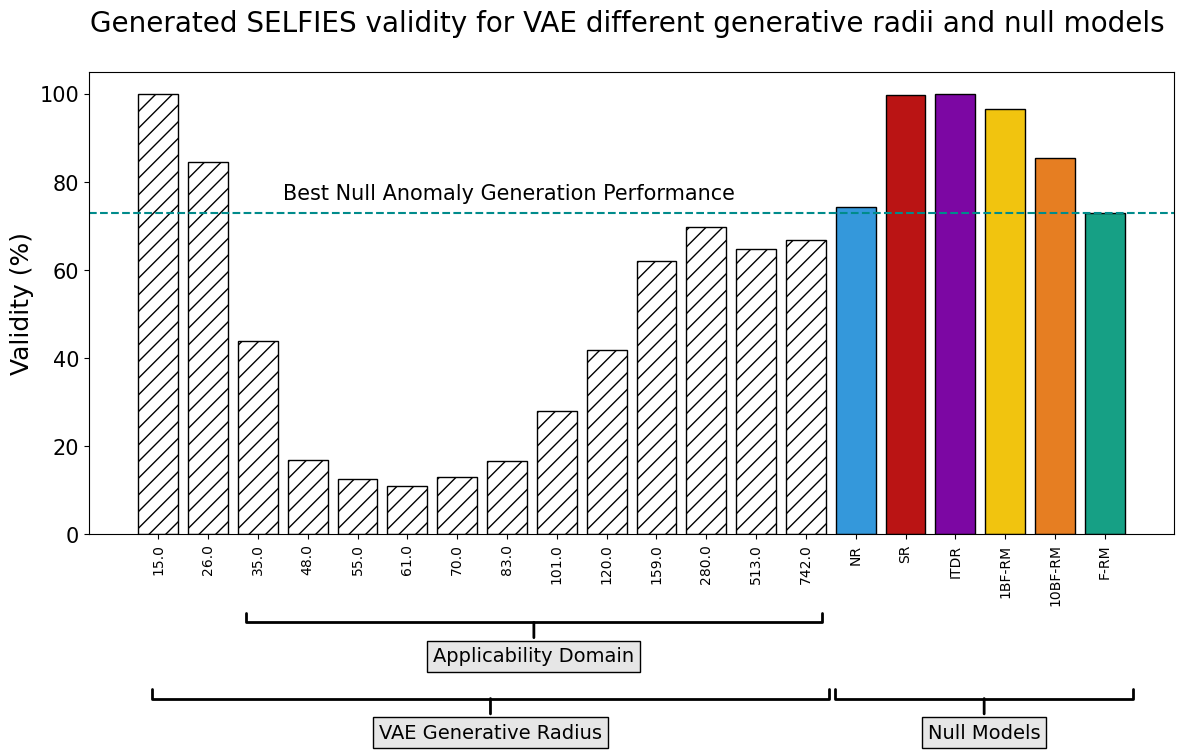

In [142]:
str_radius_list =  [str(rad) for rad in radius_list] + ['NR', 'SR', 'ITDR', '1BF-RM','10BF-RM', 'F-RM']
all_val_vect = radius_validity_list + [naive_validity, shuffle_validity, itdr_validity, one_bit_validity, ten_bit_validity, full_mutation_validity]
plt.figure(figsize=(14,6))
custom_palette = ['#FFFFFF'] * 14 + ['#3498DB', '#ba1414', '#7c07a3', '#F1C40F', '#E67E22', '#16A085']
hatches = ['//'] * 14
bars = plt.bar(str_radius_list, all_val_vect, color=custom_palette, edgecolor = 'black', linewidth=1)
plt.axhline(y = full_mutation_validity, color = 'darkcyan', linestyle = '--')


for i in range(14):
    bars[i].set_hatch(hatches[i])

plt.ylabel('Validity (%)', fontsize=18)
plt.title('Generated SELFIES validity for VAE different generative radii and null models \n ', fontsize=20)
plt.text(2.5, 76, 'Best Null Anomaly Generation Performance', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=90)
    
plt.annotate('Applicability Domain', xy=(0.410, -0.185),xytext=(0.410,-0.285),fontsize=14, ha='center', va='bottom',xycoords='axes fraction', bbox=dict(boxstyle='square',fc='0.9'),arrowprops=dict(arrowstyle='-[, widthB=14.8, lengthB=.5',lw=2.0))
plt.annotate('VAE Generative Radius', xy=(0.370, -0.35),xytext=(0.370,-0.45),fontsize=14, ha='center', va='bottom',xycoords='axes fraction', bbox=dict(boxstyle='square',fc='0.9'),arrowprops=dict(arrowstyle='-[, widthB=17.4, lengthB=.5',lw=2.0))
plt.annotate('Null Models', xy=(0.825, -0.35),xytext=(0.825,-0.45),fontsize=14, ha='center', va='bottom',xycoords='axes fraction', bbox=dict(boxstyle='square',fc='0.9'),arrowprops=dict(arrowstyle='-[, widthB=7.65, lengthB=.5',lw=2.0))


plt.show()

### Displaying examples of valid and invalid SELFIES strings generated from various radii of the VAE latent space

#### Radius 1: 15.0

#### Valid Examples

In [111]:
for s in valid_selfies_example_per_radius[15.0][0:5]:
    print(s)
    print('\n')

[C][#C][C][=C][Branch2][Ring2][Ring1][=C][N][Branch1][=Branch2][C][C][C][O][C][=O][NH1][Ring1][=Branch1][C][C][C][Branch1][C][O][Branch1][=Branch1][C][C][C][=C][C][=C][C][=C][Ring1][=Branch1][C][=C][C][=C][C][Branch1][Branch1]


[C][C][C][C][=C][C][Branch2][Ring2][Ring2][N][Branch1][=Branch1][C][=O][C][=C][C][Ring1][=Branch1][=C][Ring1][=Branch1][N][C][C][C][Branch1][P][S][=Branch1][C][=O][C][=C][C][Branch1][C][C][C][=Branch1][C][=O][O]


[O][=C][N][C][=C][C][=C][Ring1][=Branch1][Branch1][=Branch2][C][=C][C][C][N][=C][Ring1][Ring1][N][C][=N][C][=C][Ring2][=C][Ring1][=Branch1][O][C][=C][N][Ring1][Ring2][C][Branch1][#Branch2][C][C][=C][NH1][C][Ring2][Ring1][Branch1][C][C][=C][C][=C][C][=C][Ring1][=Branch1]


[C][C][=C][C][=C][Branch1][N][C][=N][N][C][Branch2][Ring1][S][C][Branch1][C][C][C][=C][Ring1][=Branch2][C][=C][Branch1][C][N][C][=C][C][=C][Branch1][C][Cl][C][C][=Branch1][C][=O][C][=C][C][=C][C][=C][Ring1][=Branch1][C][=C][Ring1][Ring1][C][=C][Ring2][Ring1][Ring1]


[C][C][=C][C][=C

#### Invalid Examples

In [112]:
for s in invalid_selfies_example_per_radius[15.0][0:5]:
    print(s)
    print('\n')

[O][=C][C][C][Branch1][N][C][N][C][=C][C][=C][C][=C][Ring1][=Branch1][N][C][Branch1][Branch1][C][C][Ring1][C].[K+1][=O][=Branch2][C][=Branch1][C][=C][Branch1][Ring1][Cl]


[O][=C][N][C][Ring2][C][Branch1][=Branch1][C][N][C][=Branch1][C][=O][N][C][=C][C][=C][Branch1][N][C][C][Branch1][C][C][Ring1][C][O][C][=C][C][C][C][C][Ring1][=Branch1].[K+1][=C]


[C][C][Branch1][=Branch1][C][=Branch1][C][=O][C][C][N][Branch1][S][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][C][Ring1][#C].[Na+1][C][C][C][=C][Ring1][=Branch1][C][C][Ring1]


[O][=C][C][C][=C][C][Branch1][N][C][=C][C][Branch1][=Branch2][C][=C][C][=C][C][=C][C][=Ring1][C][Branch1][=Branch2][C][=C][Ring1][=C].[K+1][=C][C][=C][Ring1][=Branch1][=C][Ring2][Ring1][Branch2][N][Branch1][=C][Branch1][C]


[C][C][C][=Branch1][C][=O][C][C][NH1][C][=Ring1][Branch1][C][=N][C][Branch1][C][C][C][C][=C][Branch1][=Branch1][C][=O][C][C][C][C][S][=Branch1][C][=O][O-1].[K+1][Ring2][Ring1][Ring1][Ring2][Ring1]




#### Radius 2: 26.0

#### Valid Examples

In [113]:
for s in valid_selfies_example_per_radius[26.0][0:5]:
    print(s)
    print('\n')

[C].[Cl].[Cl].[Cl][=S][=Branch1][C][=N+1][NH1][C][=C][Ring1][Branch1].[Cl][Br][Cl][C][Ring1][Branch2][=Branch1][C][C][Ring1][=Branch1]


[C][C][C][=Branch2][Ring1][Ring1][Branch1][NH1][C][Branch1][C][F][C][Branch1][C][Br][O-1][=Ring1][=N-1][Branch1][C][C][C][C][C][C][Ring1][=Branch2][C][C][Branch2][Ring1][Ring1][N][C][C][C][=C][C][=C][C][=N+1][Ring1][=Branch1].[Cl]


[O][=C][C][C][Ring1][C][Ring1][Ring1][N+1][Ring1][C][=O][O].[Cl][C][Ring1][Ring1][Branch1][C][Cl][Cl][=C][O][C][=Ring1][Branch1][C][C][N][Branch2][Ring1][Ring1][C][Ring1][Branch1].[O][=N+1][Branch1][=O][O-1]


[C][C][C][C][=C][C][Ring1][Branch1][C][Branch1][C][O-1][=C][C][=Branch1][C][C][Ring1][Ring1][Branch1][C][C][C][C][C][Ring1][Ring1][N][S][C][Ring1][Branch1][=C][Ring2][Ring1][Ring1][NH1][C][=Ring1][=Branch2][C][=N+1][Ring1][C][O-1][O-1][Branch1][O-1][Ring2][Ring1][Ring1]


[C][C][S][Branch1][C][O-1].[C][=C][C][=Branch2][Ring1][Ring2][NH1][NH1][Ring1][Branch1][Br][=Branch1][Cl][C][Branch1][C][Cl][S][=Branch1][C][=O][N]

#### Invalid Examples

In [114]:
for s in invalid_selfies_example_per_radius[26.0][0:5]:
    print(s)
    print('\n')

[C][C][S][=Branch1][C][=Branch1][C][C][=Branch1][C][=O][C][C][N][Ring2][Ring1][Ring1][O-1][C][=C][C][=C][Branch1][=Branch2][S].[Na+1][=O].[Cl].[O-1][Ring2][Ring1][C][Br][C][C][Ring1][=N][=Branch1][C][=O][O-1][=C][Ring2][Ring1][=Branch2][C][Branch1][C][C].[Na+1][=C][C][Branch1][C][F][Ring1][#Branch1]


[C][O][C][=Branch1][C][=O][C][C][=C][C][=C][Ring2][C][Ring1][=Branch2][=Ring1][Branch1][O-1][#N][C][C][Branch2][Ring1][C][S][=Branch1][C][=O][C][Branch1][O-1].[K+1].[Cl].[K+1][=O][Ring1][Ring1][N][=Ring2][Ring1][Ring1]


[C][C][Branch1][Ring1][C][O-1][O-1][C][NH1][C][Branch2][Branch1][C][=C][C][Branch1][=Branch1][C][#N][C][=C][N][Branch1][C][=C][NH1][C][=Ring1][=Branch2][Ring1][Branch1].[Cl].[K+1][Ring1]


[Cl].[C][C][C][=C][Branch1][Branch1][O][N+1][Ring1][=Branch1][N][=Branch1][C][Br][O-1][Ring1][C][O-1][C][=Ring1][Branch2][C][=N+1][O][O-1][=N+1][Ring2][Ring1][Ring1][N+1].[K+1][O-1].[Na+1].[Na+1].[Na+1]


[Cl].[O][=C][C][C][=C][C][Branch1][=Branch1][=O][=C][=C][C][=C][Ring1][C][Cl][Cl][

#### Radius 3: 35.0

#### Valind Examples

In [115]:
for s in valid_selfies_example_per_radius[35.0][0:5]:
    print(s)
    print('\n')

[O][=C][C][C][=C][Ring2][Branch2][Ring1][Branch2][Ring1][C][C][Branch1][C][C][=N][C][Ring1][#Branch1][Ring1][C][=C][C][Branch1][Ring1][N+1][Ring1][C][=O][C][=C][C][=C][Ring2][Ring1][Ring1][C][=Ring1][Ring2][Ring1][C][O-1][K+1]


[O][=C][=C][C][=C][Branch1][O][C][=C][NH1][C][Branch1][Branch1][C][Ring1][=Branch1][N+1][=N-1][O][Br][O-1][Cl+3][K+1].[O-1][O-1][O-1][O-1][=N+1][O-1][O][O-1][Cl+3][O-1].[K+1]


[C][#C][C][C][C][C][Ring1][Ring1][Branch2][Ring1][Ring1][NH1][C][Branch1][=Branch1][C][=C][Branch1][=Branch1].[Cl].[Cl][=C][O][C][Ring1][Ring2][=C][=Branch1][C][=C][N][Ring1][Ring2][Ring1][Branch1].[Cl]


[C][#C][C][=C][Branch2][Ring1][Ring1].[N+1][Ring1][O][O-1][C][PH0][=Branch1][C][=S][Ring1][Branch1][Branch1][C][O-1][O-1][C].[I-1][Branch1][C][Cl][Cl][C][Ring2][Ring1][Ring1][Branch2][Ring1][Ring2].[O][=C][Branch1][=Branch1][Ring2][Ring1][Branch1][O-1][O-1][O-1][Ring1][O-1][NH1][C][=Ring1][Branch1][C][Ring2][Ring1][=S][Cl+3][C][O-1][O-1]


[C][C][=C][C][Branch2][Ring1][Ring1][Ring1][N+1

#### Invalid Examples

In [117]:
for s in invalid_selfies_example_per_radius[35.0][0:5]:
    print(s)
    print('\n')

[C][C][S][C][=O].[C][=C].[C][=N+1][Ring1][Ring1][Ring1][=Branch2][Ring1][Ring1][O-1][=S][C][C][Ring1][Ring1][O][Branch1][Ring1][C][=O][C][Ring1][Branch2].[Cl][C][=S][C][C][=N+1][Ring1][Ring1][Branch1].[Na+1][Na+1][K+1]


[C][C][C][C][Branch2][Ring1][Branch1].[N+1][=Ring1][C][O-1][O].[N][C][=N+1][Ring1][Branch1][C][O-1][C][Branch1][O][N+1][=Ring1][=Branch1][O-1][=C][N][Ring2][Ring1][Ring1][N][=Ring2][Ring1][=Branch2][N+1][=N+1][=N-1][C][=N+1][Ring1][Branch1][O-1][O-1][O-1][O-1][O-1][O-1][C][Ring1][Ring1][=N][C][=C][Ring2][Ring1][Ring1][C][C][Ring2][Ring1][C][=Ring1][Branch1][=O][O-1].[K+1][Ring1][Ring1]


[C][C][Branch1][C][O][Branch1][Ring1][C][#N][O][C][=C][C][=N+1][Branch1][C][Br][=N+1][Ring1][C][Br][C][Ring1][C].[K+1][=S][C][O-1][C][=Ring1][Branch1][C][=S][C].[Na+1][=Ring1][C][=C][Ring2][NH1][C][=N+1][=N-1].[Na+1][O-1]


[Cl].[C][=C][C][=C][N][=C][Branch1][=Branch1][C][Branch1][C][C][=O][Branch1][Ring1][C][Br][Ring2][Ring1][Ring1][Ring1][C][=N+1][C][Branch1][NH1][C][Ring1][=Branch1]

#### Radius 4: 48.0

#### Valid Examples

In [118]:
for s in valid_selfies_example_per_radius[48.0][0:5]:
    print(s)
    print('\n')

[C][C][S][S][Ring1][Ring1][Ring1].[O-1].[O-1][O-1][S]..[O-1][Cl+3][=N-1][Ring1].[O-1][Cl]..[O-1][=N+1][Ring1][O-1][C][=C][Ring2][Ring1][Ring1][Ring2][Ring1][Ring1].[O-1][Cl+3][Branch1][C][O-1][Branch1][O-1][O-1][O-1][O-1][O-1][Ring1][O-1][C].[O-1][=Ring1][O-1][O-1]


[C][O][S][C][Ring1][=N-1][=N-1].[=P][Ring1].[O-1][=N+1][Ring1][C].[C][=N+1][Ring1][Ring1]..[O-1][=C][NH1][C][=Ring1][Branch1][=C][=N][C][Ring1][Ring1][Ring1][Ring2][=N+1][Ring1].[O-1][=Ring1][Ring1][=N+1][=N+1][Ring1][O-1][O-1][O-1][=N+1][Ring1][K+1][=S][O-1][=N+1][=N-1][O-1][=N][O][NH1][Ring2][Ring1][Ring1]..[O-1][Ring1][Na+1][=Ring1][Ring1][O][Ring2][Ring1][C][C][Ring1][=O].[O-1][Cl+3][Branch1][Na+1][O-1][O-1][Branch1][C][O-1][O-1][=Ring1][=N-1]


[O][=C][C][C][Ring1][Ring1][Ring1][Ring1][=N+1][Branch1][C][Br][C][=C][NH1][C][=N+1][=N+1][Branch1][Ring1][C][O-1][O-1][C][NH1][C][Branch1][C][Br][=C][C][=Ring2][Ring1][Ring1][Ring2][Ring1][Branch1].[O-1][Cl+3][Branch1].[O-1][=Ring2][O-1][O-1][Branch1][K+1][O-1][O-1][Cl+3][Ring

#### Invalid Examples

In [119]:
for s in invalid_selfies_example_per_radius[48.0][0:5]:
    print(s)
    print('\n')

[O][=C][C][C][Ring1][Ring1][Ring1][=N+1][O-1][=Ring1][K+1][O-1][O-1][O][P].[O-1][=N+1][Ring1][Branch1].[O-1][N+1][Branch1][O][C][=Ring1][Branch1][Branch1][C][Cl][C][Ring1][Branch2][Ring2][Ring1][Ring1].[O-1][Cl+3][Branch1][O-1][=N+1][=N-1][O-1][O-1][K+1][K+1][Cl][=S].[Na+1][=Ring1][Ring1][Ring1].[O-1][O-1][Na+1]


[O][=C][C][C][Ring1][Ring1][Ring1][Branch1][N+1][=N+1][=Branch1][Br][=Ring1][=Branch2][Ring1].[O-1][=Ring1][Ring1][=Ring1][#Branch1].[Na+1][=N+1][NH1][Na+1][=Ring1][Na+1][=Ring1][K+1][O-1][=N+1][Ring1][#C][=N+1][Ring1][Ring1].[O-1][=Ring1][=N-1][O-1][O-1][=N-1][O-1][O-1][O-1].[O-1][=S][O-1].[K+1]..[O-1][Cl+3][=N-1][O-1][O-1][O-1].[C][=Ring1][C][O][O-1][=Ring1][Branch1][Branch1][C][C][O-1][C][Ring1][Branch2][Branch1][Ring1][C][O][C][Ring1]


[O][=N+1][Branch1][Branch1][O-1][O-1][C][N+1][Branch1][C][=O][Branch1][C][C][=N+1][=N+1][Branch1][K+1][=S].[O-1][Cl+3][Branch1][O-1][O-1][P][=Branch1][C][=N+1][=N+1][Ring1][C][O-1][O-1][Branch1][C][O-1][=N+1][Ring1][C][Br][Branch1][K+1][O-

#### Radius 5: 55.0

#### Valid Examples

In [120]:
for s in valid_selfies_example_per_radius[55.0][0:5]:
    print(s)
    print('\n')

[O][=C][=C][C][Ring1][Ring1][Ring1][Ring1][=N+1][Branch1][C][O-1][O][Ring1][Ring1][=N+1][O-1][=N+1][=N+1][Ring1].[O-1][O-1][=C][NH1][Ring2][Ring1][P][=N+1][=N+1][O-1][=N+1][Ring1][Ring1][Ring2][=N+1][Ring1].[O-1][=N+1][=N-1][=Branch2][O-1][O-1][O-1][O-1][O-1][=N-1][K+1][O-1][O-1].[K+1].[K+1].[O-1].[O-1][Cl+3][Cl+3].[O-1][=S][Ring1][=Ring1][Ring1][O][Ring2][Ring1][Branch1][O-1][O-1][=Ring1][=O][O-1][O-1][O-1][Ring1]


[O][=P][=P][=Ring1][Ring1][=P][=Ring1][=P][=N+1][=N+1][Ring1][Branch1][Cl][K+1][C][=N+1][Ring2][Ring1][Branch1][O-1][C][=C][Branch1][Ring1][Ring2][=N+1][O][Ring1][O].[C][C][N][=N+1][Ring1][Ring1].[O-1][=N+1][=N-1][=N+1][Ring1][O-1][Branch1][O-1][O-1][Branch1][O-1][O-1][O-1][O-1][O-1][O-1][Na+1][O-1][Ring2][Ring1][=Ring1][Branch1][Ring2][Ring1][Ring1]


[O][=C][Branch1][C][Ring1][Ring1][O-1][=N-1][=N+1][=Ring1][Ring1][Ring1][C][=N+1][Ring2][Ring1][Ring1][O-1][C][=C][C][=N+1][Ring2][=N+1].[O-1][=N+1][=N+1][=N+1][Branch1][O-1][O-1][O-1][Ring1][K+1][O-1][Cl+3][Ring1][C][O-1][B

#### Invalid Examples

In [121]:
for s in invalid_selfies_example_per_radius[55.0][0:5]:
    print(s)
    print('\n')

[O][=N+1][Branch1][Ring1][Ring1][=N+1][C][P][Ring1][=N+1][=N+1][Ring1].[O-1][S+1][Ring1][Ring1].[Cl][=C][Ring2][Ring2][Ring1][Ring1][=N+1][Ring1][O-1][=O][O-1][=N+1].[K+1].[O-1].[K+1][O-1][=N-1][=N-1][=N-1][K+1][Branch1][K+1].[K+1][Branch1][Branch1].[O-1][Cl+3][Cl+3][Branch1][O-1][O-1][O-1][O-1].[O-1][O-1][O-1][Cl+3].[O-1].[K+1].[K+1][O-1].[K+1]


[C][S][S][Ring1][Ring1].[N+1][O].[O-1][=N+1][Ring1][C][=C][Ring2][Ring1][Ring1][O-1][O-1][O-1].[O-1].[Na+1][=N-1][K+1].[O-1][Branch1][O-1][Branch1].[O-1][O-1][C][=Ring1][Branch2][O-1][C][Branch1][C][C][Ring2][Ring1][C][=N+1][=N+1][Ring1][Na+1][=Ring1][Na+1][=N-1][O-1][O-1][O-1][Branch1].[O-1][O-1][Cl+3].[O-1].[O-1].[K+1]


[Cl].[C][C][O][C][=N+1][=N+1][=Branch2][N+1][=N+1][=N+1][=Ring1][=N-1].[O-1]...[O-1][Ring1][=N-1].[K+1].[O-1][=N-1][K+1].[K+1][K+1].[O-1][Cl+3][C][Ring1][=C][=Branch2][Ring1][Ring1][Ring1][#Branch2].[Na+1].[Na+1][Na+1][O-1].[O-1][O-1].[K+1][K+1][Ring1][O-1][O-1][O-1]


[O][=N+1][Branch1][C][O-1][Ring1][Ring1][=N+1][Ring1][C

#### Radius 6: 61.0

#### Valid Examples

In [122]:
for s in valid_selfies_example_per_radius[61.0][0:5]:
    print(s)
    print('\n')

[C][#C][S][=C][Ring1][=N-1][Ring1][Ring1][=N+1][Ring1][C][O-1][=N+1][Ring1][=N+1].[=N+1][=N+1][Cl+3][=Ring1][Na+1][=Ring1][K+1][K+1].[K+1][=Ring1][Ring1][C][Branch1][C][C][Ring1][N][=Ring2][=N+1][Ring1][C][O-1][=Ring1][=N-1][#Branch1][O-1][=Ring1][O-1][O-1][O-1][Branch1].[O-1][=S][Ring1][O][N+1][Ring1][S][O-1][=Ring2][Branch1].[O-1][O-1].[O-1]..[O-1][O-1][=Ring1][O-1]...[O-1][O-1].[O-1][=O]


[C][O].[Branch2][Ring1][=N-1][=P][=N-1][=N-1][=N-1][O-1][O-1][=N+1][Ring1][Ring1][Ring1][O-1][=Ring1][=N-1][Branch1][O-1][O-1][C][=C][Ring2][Ring1][Ring1][Branch2][Ring1][Branch1][N+1][=N+1][Ring1][=N-1][Ring1][Ring1][=N-1].[O-1][=N+1].[O-1][=N+1][Branch1][O-1][O-1][O-1][Cl+3][K+1][O-1][=S][O-1][Cl+3][=N-1][O-1][O-1][=N+1][Ring2][=Ring2][Ring2][Ring1][C][O-1][O-1][=N+1][Ring1][Ring1][C][=N+1][Ring2][=N+1][Ring1].[O-1][O-1][Cl+3].[O-1][=Ring1][O-1][O-1]


[C][O][C][S+1][Ring1][Ring1][Si][=N+1][=N-1][=N+1][=N-1][C].[C].[C][=N+1][C][Ring1][=N+1][=N-1][=N-1][=N-1].[O-1][=Ring1]..[O-1].[Cl+3].[O-1].[K+

#### Invalid Examples

In [123]:
for s in invalid_selfies_example_per_radius[61.0][0:5]:
    print(s)
    print('\n')

[C][C][Branch1][Ring1][C][=O][O][C].[O-1][=N+1][Ring1][P].[=N+1][=N+1][=N-1][K+1][O-1][O-1][O-1][=N+1][Ring1][C][N+1].[K+1][=S][O-1][Cl+3][O-1][O-1][=S].[K+1].[Na+1][=N-1][K+1].[K+1][K+1].[K+1][Cl+3][Ring2][NH1][Ring2][Cl+3][Ring1][O-1][O-1][Ring2][Ring1][Ring1][Branch1].[O-1][O-1].[K+1].[K+1][K+1].[K+1]


[C][C][=C][C][=N+1][Ring1][=N-1][=N-1][=N+1][Ring1][Ring1][=N-1][O-1][=Ring1][=N-1].[O-1].[O-1].[O-1][=N+1][C][=N+1][Ring1][Ring1][Ring2][Ring1][=Ring1][=Ring1][=Ring1][=Ring1].[Cl+3][=Ring1].[O-1][=Ring1].[O-1][K+1]..[Ring2][Ring1].[O-1][=N+1].[Na+1][=Ring1].[O-1][=Ring1].[O-1][Branch1][O-1][O-1][Ring1][Branch1][O-1].[K+1].[O-1][Cl+3][O-1][O-1][Branch1][O-1][=Ring2][Ring1]


[O][=P][Branch1][#Branch2][=C][C][Ring1][=N-1][=P][=Ring1].[O-1][Cl+3][Branch1][C][O-1][C][=C][Ring2][Ring1][C][K+1]..[K+1][=N+1][Ring1][Ring2][NH1][Ring2][=N+1][Ring2][=N+1][Ring2][=N+1][=N+1][Ring1].[O-1][=N+1][Ring1][Branch1].[K+1].[Na+1][Cl+3].[Na+1][=N-1][Branch1][K+1][K+1][Na+1][=Ring1][Branch1].[Na+1].[K+

#### Radius 7: 70.0

#### Valid Examples

In [124]:
for s in valid_selfies_example_per_radius[70.0][0:5]:
    print(s)
    print('\n')

[C-1][#N+1][C-1][=P][=P][=P][=P][#N+1][=Ring1].[O-1][=S][O-1][O-1][O-1][=Ring1][O-1][O-1][O-1].[K+1].[=N+1][=N+1][Cl+3][=N-1][=N+1][=N-1][Na+1][=N-1].[O-1][O-1].[K+1].[K+1].[O-1][=N+1][Ring1].[O-1][=N+1][Ring1][Ring1][Ring2][NH1][Ring2][Ring1][Ring1][=N+1][=N+1][O-1][=N-1][=P][O-1][Ring1].[O-1][O-1][O-1][O-1][O-1][O-1][O-1][O-1][O-1][O-1][O-1][Ring1].[O-1][=Ring1].[O-1][Cl+3][Branch1].[O-1][O-1][Cl+3][Cl+3][O-1][O-1]


[C][O][C][Branch2][Ring1][Ring2][O-1][=Ring1][=Ring1][Ring1].[O-1][Cl+3][Ring1][=N-1][=N+1][O-1][=N+1][=N-1][=N-1].[O-1][O-1][=N-1][=N-1][=N-1][=N-1][=N-1][=N-1][=N-1][=N-1][=N-1][O-1][=N+1][Branch1][Ring1][O][Ring2][=N-1][Branch1].[Na+1].[K+1].[=N-1][O-1].[=N-1][=N-1][K+1][O-1][O-1][Cl+3][=N-1][=N-1]...[Cl+3][Cl+3].[O-1][O-1][Cl+3][O-1][O-1].[Cl][O-1]..[O-1][O-1][O-1]


[C][C][=C][C][Ring1][Ring1][=N-1][=N-1][=P][Ring1][=N-1][O-1][O-1].[K+1].[O-1][=N+1][=N+1][Ring1][O-1][O-1][O-1][Branch1][=N+1][O-1][=Ring1][Ring1][K+1][O-1][O-1][=Ring1][=N+1][=N+1][=N+1][=N+1][Ring1].[

#### Invalid Examples

In [125]:
for s in invalid_selfies_example_per_radius[70.0][0:5]:
    print(s)
    print('\n')

[O][=C][Branch1][Ring1][Ring1][Ring1][=N-1][Ring1][Cl][=N+1][Ring1][Ring1][Branch2][=N+1][=N+1][=N-1][=N-1].[C][=N+1][Ring2][Ring1][Ring1][C][C][NH1][N][=N+1][=N-1][=N+1][=N+1][O-1][O-1][O-1].[O-1][O-1][O-1][=N-1][=N-1][Cl+3][=N-1][K+1][O-1][=N+1][Branch1][C][Ring2][=N+1][Ring1][Ring1][Branch1][O-1][O-1][=N-1]..[O-1]..[O-1][=N+1][Ring1][P][Ring2][Ring1][C][=Ring1][Ring1].[O-1][Cl+3][K+1]


[O][=P][=P][Ring1][Ring1][Ring1].[O-1][O-1][Cl+3][O-1].[O-1][Cl+3][Cl+3][Cl+3][Cl+3][=N+1][=N+1][Ring1][C][=S][Br][=N+1][Branch2][Ring1][Branch1][=N+1][Ring1][=N-1][O-1][=N-1][=Branch2][=N+1][Ring2][=N+1][Ring1].[O-1][=N+1][=N+1][=N+1][=N-1][=N+1].[O-1][O-1][Branch1].[K+1].[O-1][=Ring1][=N-1][O-1][=N+1][C][=N+1][Ring2][Ring1][=N][=N+1][=N+1][Ring2][=N+1][=Branch2][=Ring1].[O-1][Cl+3][=N+1][O-1].[O-1][Branch1][O-1].[O-1][O-1][Branch1].[O-1][O-1].[O-1].[O-1]


[C-1][#N+1][C][=N-1][=N-1][=N-1][=N-1].[Ring1][Ring1][=N+1][Ring1][=N-1].[Ring1][Ring1][=N-1][K+1]...[O-1][=N+1][O-1][=N-1][Ring1][Ring1][O-1][O

#### Radius 8: 83.0

#### Valid Examples

In [126]:
for s in valid_selfies_example_per_radius[83.0][0:5]:
    print(s)
    print('\n')

[O][=S][Branch1][=P][=N+1][Cl+3][C][O-1][Ring1][Ring1][Ring1][=N+1][=N+1][=N-1][=N-1][=N-1][=N-1][O-1][O-1][O-1][Cl+3][O-1][O-1][O-1][=N-1][=N-1][Cl+3].[K+1].[O-1][=N-1][=N-1][=N-1][=N-1][=N-1][=N-1][Cl+3][Cl+3][Cl+3][Cl+3][=N-1][O-1]..[Cl+3].[Cl][Cl+3][O-1][O-1][Cl+3][K+1][O-1][Cl+3][=Ring1][K+1]..[Cl+3].[O-1][Cl+3].[Cl+3][Cl+3][O-1]...[O-1].[O-1][=Ring1][Ring1][Ring1].[O-1][=N+1][Cl+3].[O-1].[O-1][Cl+3][O-1][O-1]


[C][C][=Branch1][C][C][Ring1][Ring1][Ring1][C][NH1][C][=N+1][=N-1][O-1][N+1][Ring1][=Branch1][=N+1][=N+1][=Ring1][=N-1][O-1][=N-1][O-1][=N-1][Cl+3].[Na+1].[O-1][O-1][O-1][O-1].[O-1][Cl+3][Cl+3].[O-1][O-1][Cl+3][O-1][Cl+3][Cl+3][Cl+3][Cl+3][O-1][O-1][Cl+3][Ring1][O-1][O-1][Cl+3][O-1][O-1][O-1][Ring1].[O-1][Cl+3][Cl+3].[O-1][Cl+3][Cl+3][C][O-1][O-1].[O-1][Cl+3][=N+1][O-1][Branch1].[O-1][O-1][O-1][O-1]


[C-1][#N+1][C-1][=N-1][Cl+3][=N-1][=N-1][=N-1][=N-1][=N-1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][=N-1][Cl+3][Cl+3][O-1][O-1][O-1][=N-1][=N-1][O-1][Cl+3][O-1][O-1][O-1][O-1][O-1][O-1]

#### Invalid Examples

In [127]:
for s in invalid_selfies_example_per_radius[83.0][0:5]:
    print(s)
    print('\n')

[C][C][Branch1][C][O][=S][=N+1][O-1][=Ring1][=N-1][K+1][Cl+3][K+1][Cl][Cl+3][Cl+3][Na+1][Cl][Cl].[Cl][=S].[O-1][=N+1][O-1][Cl+3][=Ring1][=N-1][Cl+3][=N-1].[O-1][=Ring1][Cl+3].[Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][=N-1][K+1][Cl+3].[O-1][O-1][Cl+3][=N+1][NH1][=Ring2][=N+1][=N+1][=N-1][=N-1][O-1][O-1][O-1][O-1][=Ring1][=N-1][#C][O-1][=N-1][K+1][O-1][O-1][=N-1][=N-1][O-1]..[O-1][=N-1][O-1].[K+1][Cl+3].[Na+1][=Ring1].[O-1][O-1][O-1][O-1][O-1]


[O][=P][=P][=P][Ring1][Ring1][Ring1][Ring1][C][Br][O-1][Branch1][O-1][O-1][O-1][O-1][=N+1][=N-1][=N+1].[Na+1][=N+1].[O-1][Cl+3][K+1][O-1][K+1].[K+1].[Na+1][=N+1][=N-1][=N-1][=N-1][=N-1][=N-1][=N-1][=N-1][=N-1][=N-1][O-1][=Ring1].[O-1][Cl+3][Cl+3][O-1][O-1][K+1][O-1].[K+1].[O-1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][=N-1][=N-1][=N-1][O-1][Cl+3][Cl+3][Cl+3][K+1][O-1][O-1][Ring2].[O-1][Cl+3][O-1][=Ring1][O-1][Branch1][O-1][O-1]


[C][S][=P][=P][Ring1][=N-1][=P][=P][=P][O-1][=P][=N-1][=N-1].[O-1][Cl+3][Cl+3][Cl+3][O

#### Radius 9: 101.0

#### Valid Examples

In [128]:
for s in valid_selfies_example_per_radius[101.0][0:5]:
    print(s)
    print('\n')

[O][=P][Cl+3][=P][=P][=P][O-1][=P][Cl+3][Ring1].[O-1][Branch1].[=N-1][=N-1][=N-1][O-1][Cl+3][Cl+3][=Ring1][=Ring1][O-1].[=N-1][=N-1][=N-1][Cl+3][Cl+3][=Ring1][=Ring1][O-1][K+1][K+1][Cl+3][K+1][O-1][O-1]..[O-1][O-1].[O-1][Cl+3][O-1][O-1][=N-1][Cl+3][Cl+3][Na+1][Cl+3][Cl+3][Cl+3][Cl+3][O-1][Cl+3][Cl+3][Ring1].[O-1][O-1][O-1][=N-1][=N-1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][#N][K+1][Cl+3].[Cl+3][Cl+3][Cl+3][Cl+3][=N-1][Cl+3][Cl+3][O-1][O-1][O-1][O-1][Cl+3][K+1]


[C-1][#N+1][#N+1][=P][Cl+3][=Ring1][=N-1][=N+1][=N-1][Cl+3][=Ring1][=Ring1][Cl+3][Cl+3][Cl+3][Cl+3][Cl][O-1][Cl+3][Cl+3][O-1][O-1][Cl+3][Cl][Cl][Cl][Cl+3][Cl+3][O-1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][K+1][O-1][=Ring1][=N-1][=Ring1][=Ring1][=N-1][=Ring1][Cl+3][Cl+3][Cl+3][Cl+3][O-1][O-1][Cl][Cl+3][K+1].[O-1][=Ring1][#Branch2][K+1].[N+1][Branch1][Branch1].[O-1][=Ring1][=N+1][K+1][Ring2][=Ring1][K+1][=Ring1][C][=S][=C][Ring2][Ring1][Ring2][Branch1][C][O-1][C][Ring2][Ring1][Branch2][Ring1][=N][=Ring1].[O-1][=Ring1][O-1]


#### Invalid Examples

In [129]:
for s in invalid_selfies_example_per_radius[101.0][0:5]:
    print(s)
    print('\n')

[C][=S][Branch1][C][Cl][=N+1][Ring1][O].[=N-1][=N+1][=N-1]..[Cl+3][Cl+3][Cl+3][=N-1][=N+1][=N+1].[Cl+3][Cl+3][Na+1][Cl+3][=N-1][=N-1][Cl+3][=N-1][Cl+3][=N-1][Na+1][=Ring1][Cl+3].[Na+1][Cl+3][Na+1].[Cl+3][Cl+3][Cl+3][O-1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][=Ring1][O-1][O-1][Cl+3][O-1][Cl+3][O-1][Cl+3][Cl+3][O-1][O-1][O-1][Cl+3].[Cl+3].[K+1][O-1].[Cl+3].[O-1][Cl+3][O-1].[O-1][=Ring1][Ring2][O-1][=N-1].[O-1].[K+1].[O-1][=Ring1][=N-1].[O-1][=Ring1]


[C-1][#N+1][C-1][=N-1][=N-1][=N-1][=N-1][=P][=N-1][=P][=N-1][=P][=N-1][O-1][O-1][#C-1][=N-1][=N-1][O-1][O-1][Cl+3][Cl+3][Cl+3][Cl][O-1][O-1][O-1][O-1][O-1][O-1][O-1][O-1][K+1][K+1][=N-1][K+1][Cl+3][Cl+3][Cl+3][K+1][K+1][O][K+1][K+1][O-1][Cl+3][=N-1][O-1].[O-1][O-1][O-1][O-1][O-1][O-1][O-1][O-1][O-1][O-1].[O-1][O-1][K+1][Cl+3][O-1][O-1][O-1][O-1][O-1][=N-1][K+1][K+1][K+1][K+1].[K+1][Cl+3][K+1][O-1][O-1][=N-1][=N-1][O-1][=N-1][K+1][O-1][Branch1][K+1][K+1][O-1][O-1]


[C-1][#N+1][=N-1][#C-1][Cl][Cl+3][Cl+3][Cl+3][Cl+3][Na+1][Cl+3][Cl+3][Cl+3][=N-1][Cl

#### Radius 10: 120.0

#### Valid Examples

In [130]:
for s in valid_selfies_example_per_radius[120.0][0:5]:
    print(s)
    print('\n')

[C-1][#N+1][=P][=N-1][=N-1][=N-1][=P][=N-1][=N-1][=N-1][Cl+3][K+1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][=N-1][Cl+3][Cl+3][Cl+3][O-1][=N-1][Cl+3][O-1][O-1][Cl+3][=N-1][=N-1][=P][Cl+3][Cl+3][O-1][Cl+3][Cl+3][=P][O-1][Cl][Cl+3][Cl][O-1][O-1][O-1][=S][Cl+3][=N-1][=N-1][=N-1][=N-1][Cl+3][Cl+3][=Ring1][=N-1][=N-1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][O-1][Cl+3][Cl+3][Cl+3][O-1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][O-1][Cl+3][Cl+3][O-1][Cl+3][Cl+3][Cl+3][Cl+3][O-1][Cl+3][Cl+3][Cl+3][O-1][Cl][Cl]


[C-1][#N+1][#N+1][=P][=P][=P][Ring1][=P][O-1][=Ring1][Na+1][Cl+3][O-1][O-1][Cl+3][K+1][O-1][K+1][O-1][Cl+3][O-1][O-1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][O-1][Cl][Cl+3].[O-1].[=N-1][Cl+3][=S].[O-1][=N-1][=N-1][=N-1][=N+1][=N+1][=N-1][=N-1][O-1][O-1][Cl+3][=P][=P][=P][Cl+3][Cl+3][=N-1][=N-1][O-1][Cl+3][O-1][O-1][O-1][Cl+3][Cl+3][Cl+3][=N-1][O-1][Cl+3][=Ring1][Cl+3][=N-1][=N-1][=Ring1][=N-1][O-1][=Ring1][O-1][=N-1][O-1].[O-1][=Ring1][O-1][O-1][O-1][Ring1][=N+1][=N+1][Na+1][=Ring1].


[O

#### Invalid Examples

In [131]:
for s in invalid_selfies_example_per_radius[120.0][0:5]:
    print(s)
    print('\n')

[C-1][#N+1][C-1][C-1][Cl+3].[=N-1][=Ring1][=N-1][=P][=N-1][=N-1][=Ring1][Cl+3][Cl+3][Cl+3][=Ring1][=N-1][=P][O-1][Cl][O-1][O-1][=Ring1][Cl+3][=Ring1][O-1][O-1][O-1][O-1][O-1][O-1][=Ring1][Cl][=Ring1][Cl+3][=Ring1][Cl+3][=Ring1][=Ring1][O-1][Cl+3][Cl+3][Cl+3][K+1][O-1][Cl+3][Cl+3][Cl+3][=Ring1][O-1][O-1][Cl+3][Cl+3][=Ring1][Cl+3][=Ring1][K+1][K+1][K+1].[Cl+3][Cl+3][=Ring1][=Ring1][=Ring1][=Ring1][=Ring1][=Ring1][=N-1][Cl+3][Cl+3][Cl+3][Cl+3][K+1][Cl+3][Cl+3][=Ring1][Cl][Cl+3].[Cl][O-1][Cl][Cl][O-1]..[K+1][K+1][Ring1]


[O][=P][=C][C][Ring1][Ring1][=N+1][Ring1][O-1][Br][K+1][Na+1][=N-1][Ring1].[K+1][Ring1][=N-1][K+1][=Ring1][Cl+3][K+1][K+1][Cl+3][Cl+3][Cl+3][Cl+3][K+1][K+1][=N-1][Cl+3][Cl+3][Cl+3][=Ring1][Cl+3][Cl+3][Cl+3][=N-1][Cl+3][Cl+3][=Ring1][=Ring1][Cl+3][Cl][Cl+3][=N-1][=N-1][O-1][=N-1][=N-1][=N-1][K+1][=N-1][Cl+3][Cl+3][Cl+3][K+1][K+1][=N-1][K+1][K+1][K+1][K+1][K+1][Na+1][=Ring1][=Ring1][=Ring1][Na+1][=Ring1][Na+1][=Ring1][O-1].[O-1][=N-1][O-1].[O-1][O-1][=N-1][=N-1][Ring1][O-1]

#### Radius 11: 159.0

#### Valid Examples

In [132]:
for s in valid_selfies_example_per_radius[159.0][0:5]:
    print(s)
    print('\n')

[O][=P][S+1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][=N-1][K+1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][=P][=P][=P][=P][Cl+3][O-1][Cl+3][=P][=N-1][O-1][O-1][O-1][O-1][O-1][O-1][Cl+3][O-1][Cl+3][O-1][O-1][O-1][O-1][Cl][Cl+3][Cl+3][Cl+3][=Ring1][O-1][O-1][Cl+3][O-1][Cl+3][Cl+3][Cl+3][Cl+3][K+1][Cl+3][Cl+3][Cl+3][Cl+3][Ring1][N+1][O-1]


[O][=S][Branch1][S+1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][=P][=Ring1][=N-1][=N-1][=N-1][Cl+3][=N-1][Cl+3][Cl+3][=N-1][Cl+3][Cl][Cl+3][=Ring1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][K+1][K+1].[Cl][O-1][O-1][O-1][Cl+3][O-1][O-1][O-1][O-1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][O-1][=Ring1][Cl+3][Cl+3][Cl+3][O-1][O-1][O-1][O-1][=Ring1][=Ring1][=Ring1][=Ring1][Cl+3][=N-1][O-1][Cl+3][C

#### Invalid Examples

In [133]:
for s in invalid_selfies_example_per_radius[159.0][0:5]:
    print(s)
    print('\n')

[O][=P][S+1][Cl+3][=P][=P][=P][=P][=P][Cl+3][Cl+3][=P][K+1][=P][=Ring1][Branch2][=Ring1][Ring1][=N-1][=N-1][=N-1][=N-1][O-1][Cl+3][O-1][=Ring1].[O-1][=N-1][Ring1][=N-1].[=Ring1][O-1][O-1][=Ring1][O-1][O-1][Cl+3][Cl+3][O-1][=Ring1][=Ring1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3].[Cl+3][Cl+3][Cl+3][Cl+3][=N-1][=N-1][=N-1][=N-1][=Ring1][=Ring1][=Ring1][=N-1][=N-1][=N-1][=N-1][O-1][Cl+3][=N-1][Cl+3][Cl+3][Cl+3][O-1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][=Ring1][=Ring1][=Ring1][O-1][=N-1][=N-1][K+1][Cl+3][Cl+3][Cl+3]


[O][=P][=P][Ring1][=N+1][Ring1][=P][=P][Cl+3][=N-1][O-1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][=Ring1][Cl+3][Cl+3][Na+1][=Ring1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][=Ring1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][=Ring1][=N-1][Cl+3][=Ring1][O-1][K+1][=Ring1][=C][O-1][Cl+3][Cl+3][K+1].[K+1]..[K+1][O-1].[K+1].[K+1][=Ring1].[O-1][Cl+3].[=Ring1][Cl+3]..[K+1][=Ring1][Cl+3][K+1][K+1][Cl+3][=N-1][=N-1][K+1]...[=P][=Ring1][=P][Cl+3][Cl+3][Cl+3][Cl][Cl][=N-1][=

#### Radius 12: 280.0

#### Valid Examples

In [134]:
for s in valid_selfies_example_per_radius[280.0][0:5]:
    print(s)
    print('\n')

[C][N][S+1][C-1][Ring1][=Ring1][=P][Cl+3][Cl+3][Ring1][Ring1][Cl][=Ring1][Cl][Ring1][Ring1][Cl][Cl+3][O-1][O-1][Cl+3][O-1][Cl+3][Cl+3][Cl+3][Cl+3][=Ring1][=Ring1][O-1][Cl+3][=Ring1][=Ring1][O-1][Cl+3][Cl+3][O-1][Cl+3][Cl+3][K+1][Cl+3][Cl+3][K+1][Cl+3][=Ring1][=P][Cl+3][Cl+3][=P][=Ring1][Cl+3][=P][=P][=P][=Ring1][=Ring1][Cl+3][=Ring1][K+1][K+1][Cl+3][Ring1][=P][=P][Ring1][K+1][=P][=P][=P][=P][O-1][=P][=P][=P][=P][Cl+3][=P][Cl][=P][K+1][Cl+3][=P][O-1][=P][=Ring1][=P][=P][=P][=P][Cl+3][=Ring1][=P]


[O][=P][S+1][=P][=P][Cl+3][=P][=P][=P][=P][=P][=P][Cl+3][=P][=P][=P][=N-1][=N-1][#C-1][=N-1][=P][=P][=P][=P][=P][=P][Cl+3][=P][=P][Cl+3][#C-1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][#C-1][=PH0][=PH0][Cl+3][Cl+3][Cl+3][Cl+3][=P][#C-1][#C-1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][=N-1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+

#### Invalid Examples

In [135]:
for s in invalid_selfies_example_per_radius[280.0][0:5]:
    print(s)
    print('\n')

[C-1][C-1][C-1][#N+1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][=P][=P][Ring1].[=Ring1][Cl+3][Cl+3][=N-1][=N-1][=N-1][=N-1][=Ring1][=Ring1][=Ring1][Cl+3][=Ring1][Cl+3][Cl+3][=N-1][=N-1][=N-1][Cl+3][Cl+3][=N-1][Cl+3][=N-1][=Ring1][Cl+3][Cl+3][=Ring1][Cl+3][Cl+3][#C-1][=N-1][#C-1][=N-1][=P][=N-1][=N-1][=N-1].[Cl+3][Cl+3][Cl+3][=Ring1][=Ring1][Cl+3][K+1][=P][=P][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][#C-1][#C-1][#C-1][=P][Cl+3][#C-1][#C-1][#C-1][Cl+3][#C-1][=P][Cl+3][K+1][Cl+3][Cl+3][Cl+3][=P][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl][Cl+3][Cl]


[O][=P][=P][=P][=P][=P][=P][=P][=P][=P][=P][Cl+3][=Ring1][=P][=P][Cl+3][Cl+3][K+1][Cl+3][Cl+3][Cl+3][Cl+3][=P][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][=P][Cl+3][#C-1][=P][=P][#C-1][#C-1][#C-1][#C-1][#C-1][O-1][=P][O-1][=P][=P][Ring1][=P][O-1][=P][=P][=P][O-1][Branch2][=P][O-1][O-1][O-1][Ring1][O-1][Ring1][Ring1][O-1][Ring1][=P][#C-1][O-1][O-1][O-1][O-1][=N-1][O-1][K+1][K+1].[Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][K+1][Cl+3][O-1][Cl+3]

#### Radius 13: 513.0

#### Valid Examples

In [150]:
for s in valid_selfies_example_per_radius[513.0][0:5]:
    print(s)
    print('\n')

[C-1][C-1][C-1][C-1][C-1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][=Ring1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl][Cl+3][Cl+3][Cl][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][=N-1][=N-1][=N-1][=N-1][#N+1][=P][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][=P][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][=Ring1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][=Ring1][=Ring1][C-1][Cl+3][Cl+3][Cl+3][=P][Cl+3][Cl+3][Cl+3][#C-1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3]


[C-1][C-1][C-1][C-1][Cl+3][Cl+3][Cl+3][Ring1][Cl+3][Cl+3][=P][Cl+3][Cl+3][=Ring1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][=P][=Ring1][Cl+3][Cl+3][Cl+3][=P][=Ring1][Cl+3][=Ring1][Cl+3][Cl+3][=Ring1][Cl+3][Cl+3][Cl+3][=P][=P][=P][Cl+3][Cl+3][Cl+3][=P][Cl+3][Cl+3][Cl+3][K+1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][K+1][Cl][Cl+3][Cl+3][Cl+3][C-1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][=P][=P][=P][Cl+3][=P][Cl+3

#### Invalid Examples

In [151]:
for s in invalid_selfies_example_per_radius[513.0][0:5]:
    print(s)
    print('\n')

[O][=P][=P][=P][=P][=P][=P][=P][=P][=P][=P][=P][K+1][O-1][#N+1][=P][=P][=P][=P][=P][=P][=P][=P][=P][Cl+3][Cl+3][=P][=P][Cl+3][Cl+3][=P][=P][=P][Cl+3][Cl+3][Cl+3][#C-1][Cl+3][#C-1][#C-1][Cl+3][Cl+3][=P][=P][=P][Cl+3][=P][=P][Cl+3][Cl+3][#C-1][#C-1][#C-1][=P][=P][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][K+1][Cl+3][=P][Cl+3][Cl+3][=P][=P][Cl+3][Cl+3][=P][=P][Cl+3][Cl+3][=P][Cl+3][=P][=P][Cl+3][Cl+3][Cl+3][=P][=P][=P][=P][Cl+3][Cl+3][=P]


[C-1][C-1][C-1][K+1][=N-1][Cl+3][Cl+3][Cl+3][K+1][Cl+3][Cl+3][Cl+3][=P][K+1][C-1][Cl+3][=P][=P][Ring1].[=P][=P][=P][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][=P][Cl+3][Cl+3][Cl+3][=P][Cl+3][Cl+3][Cl+3][=N-1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][#C-1][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3][Cl+3]


[C-1][C-1][C-1][C-1][C-1]